In [ ]:
# !brew install svn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys


import sys

sys.path.append("/content/drive/MyDrive/Denoising Code/Denoising_Tutorial")
# sys.path.append("/content/drive/MyDrive/CVPR2024/sam_code/utils")

In [ ]:
# ! ls '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial'

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch
import os

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
noise_scale = noise_std = 0.1

In [ ]:
import torch.utils.data as udata


class PieceWiseConstantDataset(udata.Dataset):

    def __init__(self, n_data = 1000, n_signal = 40, prob=0.3, fix_datapoints = True,
                  min_val = 0, max_val = 1, min_sep = 20, min_diff=0.4, use_circular_shift=True, circular_shift_get_item= False, seed=0, shift_item = False):
        super(PieceWiseConstantDataset, self).__init__()

        assert(min_sep > 0)
        self.n_data = n_data;
        self.n_signal = n_signal;
        self.prob = prob
        self.fix_datapoints = fix_datapoints;
        self.min_val = min_val;
        self.max_val = max_val;
        self.min_sep = min_sep;
        self.min_diff = min_diff
        assert min_diff < (max_val-min_val)/2

        self.use_circular_shift = use_circular_shift
        self.circular_shift_get_item = circular_shift_get_item
        self.shift_item =shift_item

        np.random.seed(seed)

        if self.fix_datapoints:
            self.data_list = [None] * self.n_data;
            for i in range(self.n_data):
                # self.data_list[i] = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
                self.data_list[i] = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

    def __len__(self):
        return self.n_data

    def circular_shift_shift(self, signal, shift):
        return np.roll(signal, shift)

    def circular_shift(self, signal, shift):
        if shift > int(self.n_signal/2):
          return np.flip(signal).copy()
        else:
          return signal


    def gen_piecewise_constant(self, n, prob, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        min_diff = self.min_diff
        signal = np.zeros(n)
        val = np.random.uniform(min_val, max_val);
        ind = np.random.randint(n)
        for i in range(n):
            signal[ind] = val
            if np.random.rand() < prob:

                new_val = np.random.uniform(min_val, max_val)
                # Ensure the new value differs from the old value by at least min_diff
                while abs(new_val - val) < min_diff:
                    new_val = np.random.uniform(min_val, max_val)
                val = new_val
                # val = np.random.uniform(min_val, max_val);
            ind = np.mod(ind + 1,n)
        return signal

    def gen_piecewise_constant_minsep(self, n, prob, minsep, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        signal = np.zeros(n)
        ind = 0
        val = np.random.uniform(min_val, max_val);
        while ind < n:
            if ind + minsep > n:
                signal[ind:] = val
                break
            if ind == 0 or np.random.rand() < prob:
                val = np.random.uniform(min_val, max_val);
                sep = np.random.randint(1, minsep+1) if ind == 0 else minsep;
                if ind + sep > n:
                    signal[ind:] = val
                    break
                else:
                    signal[ind:(ind+sep)] = val
                    ind += sep
            else:
                signal[ind] = val
                ind += 1
        if self.use_circular_shift:
          shift = np.random.randint(n)
          # print(signal)
          signal = self.circular_shift(signal, shift)
        return signal

    def __getitem__(self, index):

        if self.fix_datapoints:
            signal = self.data_list[index];
        else:
            # signal = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
            signal = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

        if self.circular_shift_get_item:
          shift = np.random.randint(self.n_signal)
          if not self.shift_item:
            signal = self.circular_shift(signal, shift)
          else:
            signal = self.circular_shift_shift(signal, shift)



        return torch.from_numpy(signal).unsqueeze(0).type(torch.FloatTensor)

In [ ]:
# def get_noise(data, noise_std = 0.1):
#     noise = torch.randn_like(data);
#     noise.data = noise.data * noise_std;
#     return noise

def get_noise(signal, noise_std=0.1, noise_scale=1, max_noise=1,  mode='G'):
    if mode == 'poisson':
        scaled_signal = signal * noise_scale
        noise_sample = torch.tensor(np.random.poisson(scaled_signal.numpy()))
        noise = (noise_sample - scaled_signal) / noise_scale
    else:
        noise = torch.normal(0, noise_std, size=signal.shape)

    noise = torch.clamp(noise, -max_noise, max_noise)
    return noise


In [ ]:
def validation_error(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction='sum');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += data.shape[0];

    return error_val/total_length

In [ ]:
def train_network_on_noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
path_to_saved_models = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/saved_models_picecewise_constant1/'
if not os.path.exists(path_to_saved_models):
    os.mkdir(path_to_saved_models)

In [ ]:
kernel_size = 3;
num_filters = 3;
center_list = np.arange(-2, 2, 0.05);
sigma_list = 0.1;
n_hidden = 5;
hidden_dim = 10;
# non_linear_func = 'rbf'
non_linear_func = 'nn'

In [ ]:
# noise_scale = noise_std = 1

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DnCNN(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True):
		super(DnCNN, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias = use_bias


		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			out = F.relu(out)

		out = self.last_layer(out);

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)



In [ ]:
net_nn_large = DnCNN(depth=10)

In [ ]:
# val_loss_dnn

In [ ]:
# net_nn = combined_network(kernel_size = kernel_size,
#                       num_filters = num_filters,
#                       center_list = center_list,
#                       sigma_list = sigma_list,
#                       n_hidden = n_hidden,
#                       hidden_dim = hidden_dim,
#                       non_lin_func = non_linear_func)
# n_hidden =
# net_nn = fully_connected_network(n_hidden = n_hidden, hidden_dim=hidden_dim, kernel_size=3)

In [ ]:
# net_nn

In [ ]:
signal_length = 100

In [ ]:
train_dataset = PieceWiseConstantDataset(n_data = 500, prob = 0.3, n_signal = signal_length, fix_datapoints = True, min_sep = 5, use_circular_shift=False, circular_shift_get_item=True);
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = 0.3, min_sep = 5, use_circular_shift=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
# train_loss_dnn

In [ ]:
# train_loss_dnn_large, val_loss_dnn_large = train_network_on_noise(net_nn_large, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 100,
#                        milestone = 50,
#                       lr = 1e-2)

In [ ]:
def visualize_denoising(source, net, noise_std, figsize=(10,10)):
    noise_sample = get_noise(source, noise_std);
    reconstructed = net(source+noise_sample);

    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=figsize);
    axes[0].plot(source.data.numpy().reshape(-1))
    axes[0].set_title('Sigal')

    axes[1].plot(noise_sample.data.numpy().reshape(-1))
    axes[1].set_title('Noise Sample')

    axes[2].plot((source+noise_sample).data.numpy().reshape(-1))
    axes[2].set_title('Noisy')

    axes[3].plot(reconstructed.data.numpy().reshape(-1))
    axes[3].set_title('Reconstructed')

    plt.show()
def visualize_coeffs_and_denoising(source, net, noise_std, figsize=(10,20)):
    noise_sample = get_noise(source, noise_std)
def visualize_filter(net):
    n = net.num_filters;

    fig, axes = plt.subplots(n, 2, sharex=True, sharey=True, figsize=(10, 5));
#     plt.setp(axes.flat,  adjustable='box-forced');

    if n==1:
        axes[0].stem(net.get_forward_filter_list()[0])
        axes[1].stem(net.get_inverse_filter_list()[0])
    else:
        for i in range(n):
            axes[i][0].stem(net.get_forward_filter_list()[i])
            axes[i][1].stem(net.get_inverse_filter_list()[i])

    plt.show()

In [ ]:
net_nn = DnCNN(depth=2, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)

In [ ]:
net_nn

DnCNN(
  (first_layer): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (hidden_layer_list): ModuleList()
  (last_layer): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [ ]:
train_loss_dnn, val_loss_dnn = train_network_on_noise(net_nn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)

0 train error:  2.0170588760375976 val error:  2.0123528653383254
1 train error:  0.7056449203491211 val error:  0.7240148240327835
2 train error:  0.5939965152740478 val error:  0.588671886920929
3 train error:  0.5194882736206055 val error:  0.5283799886703491
4 train error:  0.47578652381896974 val error:  0.48213883087038995
5 train error:  0.43620389175415036 val error:  0.4434500879049301
6 train error:  0.4198641414642334 val error:  0.4099319030344486
7 train error:  0.4102498149871826 val error:  0.41286671072244646
8 train error:  0.3992893543243408 val error:  0.3954662503302097
9 train error:  0.39895736503601076 val error:  0.39245576709508895
10 train error:  0.39400323486328126 val error:  0.39965769052505495
11 train error:  0.39719250679016116 val error:  0.3841998086869717
12 train error:  0.39447223949432375 val error:  0.4080905294418335
13 train error:  0.39782899188995363 val error:  0.4037627209722996
14 train error:  0.39391159248352053 val error:  0.39641171514

In [ ]:
import matplotlib.pyplot as plt

def plot_side_by_side_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, wiener_star_loss, save_path='side_by_side_losses.pdf', title1='DNN without Batch Normalization', title2='DNN with Batch Normalization'):


    y_min = 0  # Replace with your desired minimum value
    y_max = 1  # Replace with your desired maximum value
    # Create a figure with two side-by-side subplots that share the y-axis
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Plotting for the first experiment on the first subplot
    ax1.plot(train_loss, label='Train Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='green')
    ax1.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')
    ax1.set_title('Linear Net Loss Curves', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax1.set_ylim(y_min, y_max)

    # Plotting for the DNN experiment on the second subplot
    ax2.plot(train_loss_dnn, label='Train Loss (DNN)', color='blue', linestyle='-.')
    ax2.plot(val_loss_dnn, label='Validation Loss (DNN)', color='green', linestyle='-.')
    ax2.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')
    ax2.set_title('DNN Loss Curves', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax2.set_ylim(y_min, y_max)

    # Ensure a tight layout and save
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [ ]:
train_loss_dnn

array([0.06940526, 0.01021665, 0.0067475 , 0.00559289, 0.0049751 ,
       0.0046534 , 0.00434572, 0.00412529, 0.00414057, 0.00397849,
       0.00394012, 0.00401035, 0.00391526, 0.00394699, 0.00395695,
       0.00395756, 0.00387182, 0.00385498, 0.00381383, 0.00391064,
       0.00395354, 0.00384889, 0.0037513 , 0.00387495, 0.00378508,
       0.0037675 , 0.00379703, 0.00374951, 0.00376223, 0.00379331,
       0.00377279, 0.00377295, 0.0037538 , 0.00379841, 0.00371096,
       0.00380423, 0.00375245, 0.00370406, 0.00372837, 0.00368715,
       0.00373586, 0.0036957 , 0.00362949, 0.00367318, 0.00364677,
       0.00360154, 0.00370802, 0.00360622, 0.00363354, 0.00367773,
       0.00367391, 0.00365258, 0.00362767, 0.0036114 , 0.00358831,
       0.00357874, 0.00359225, 0.00361612, 0.00357992, 0.00363697,
       0.00357271, 0.00361664, 0.00351165, 0.00358445, 0.00364582,
       0.00355627, 0.00362779, 0.00358017, 0.00360168, 0.00360799,
       0.00360843, 0.00360179, 0.00359651, 0.00357107, 0.00358

In [ ]:
val_loss_dnn

array([2.03738693, 0.71535732, 0.61351433, 0.5207807 , 0.48980371,
       0.45816226, 0.40729075, 0.40416366, 0.39585585, 0.40051023,
       0.39785409, 0.40671976, 0.38284753, 0.39170763, 0.40163688,
       0.38198489, 0.39226988, 0.38825858, 0.39455313, 0.39299788,
       0.39588978, 0.40192996, 0.38083218, 0.38675703, 0.40032738,
       0.37698706, 0.36711981, 0.36791933, 0.36778905, 0.37923207,
       0.39419172, 0.37617363, 0.37680811, 0.36985218, 0.38347088,
       0.37708589, 0.36432977, 0.36611237, 0.36547521, 0.37201195,
       0.37085413, 0.37002851, 0.37511032, 0.35900912, 0.37628131,
       0.36467287, 0.357095  , 0.37753504, 0.37308619, 0.36508034,
       0.37292613, 0.35078838, 0.3635157 , 0.37109137, 0.35840836,
       0.35641954, 0.36978701, 0.37427664, 0.36629866, 0.36350005,
       0.36478726, 0.35778212, 0.35933387, 0.34645646, 0.3645312 ,
       0.35645681, 0.35582027, 0.36116432, 0.35703404, 0.35133775,
       0.36457835, 0.35813528, 0.36610169, 0.35373957, 0.36584

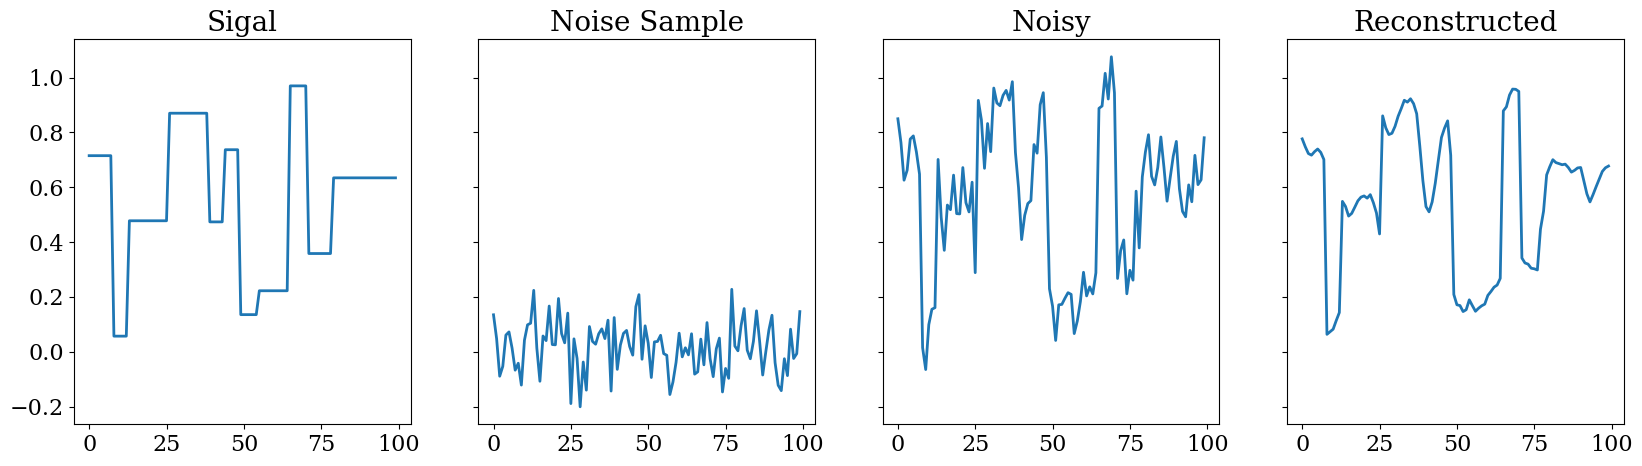

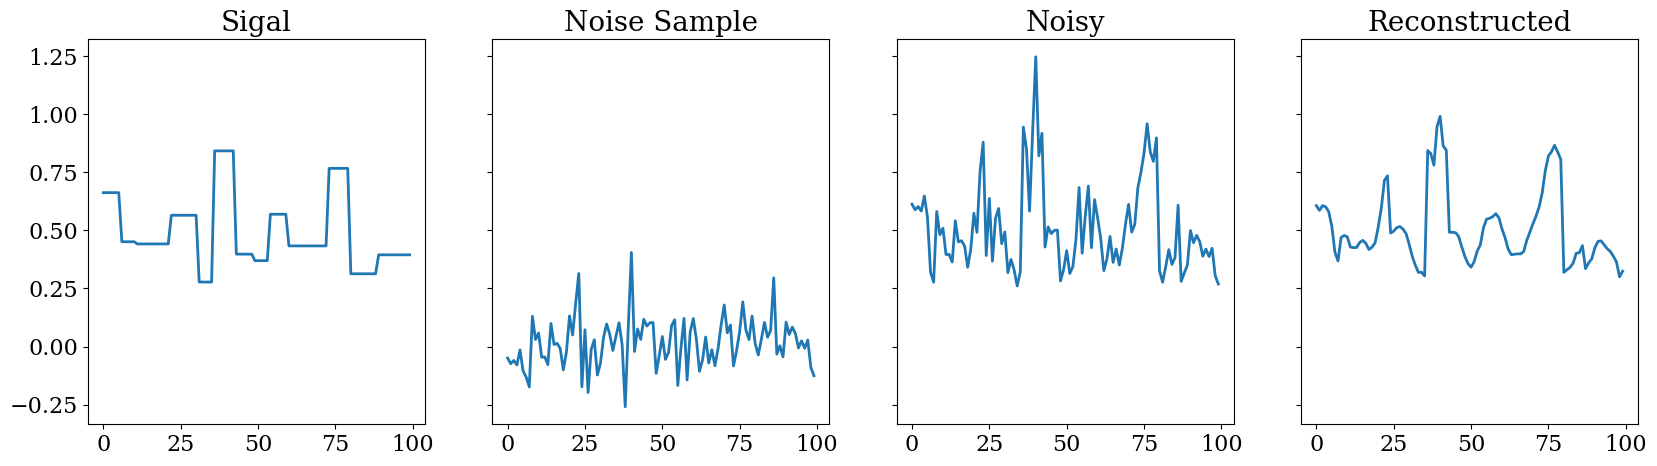

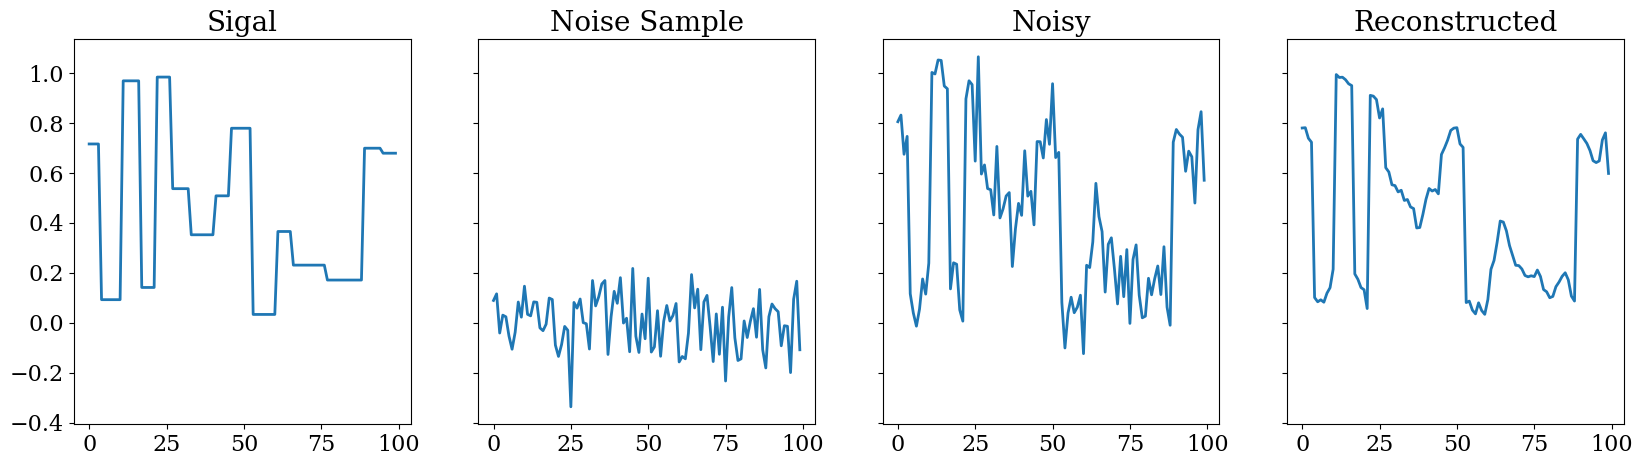

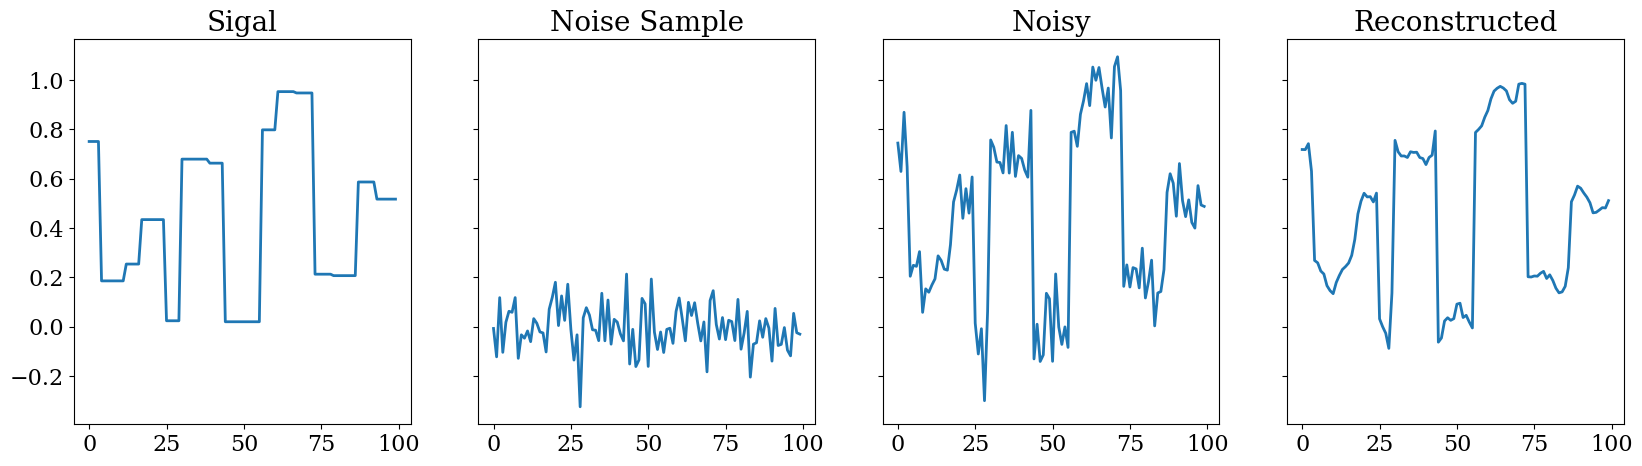

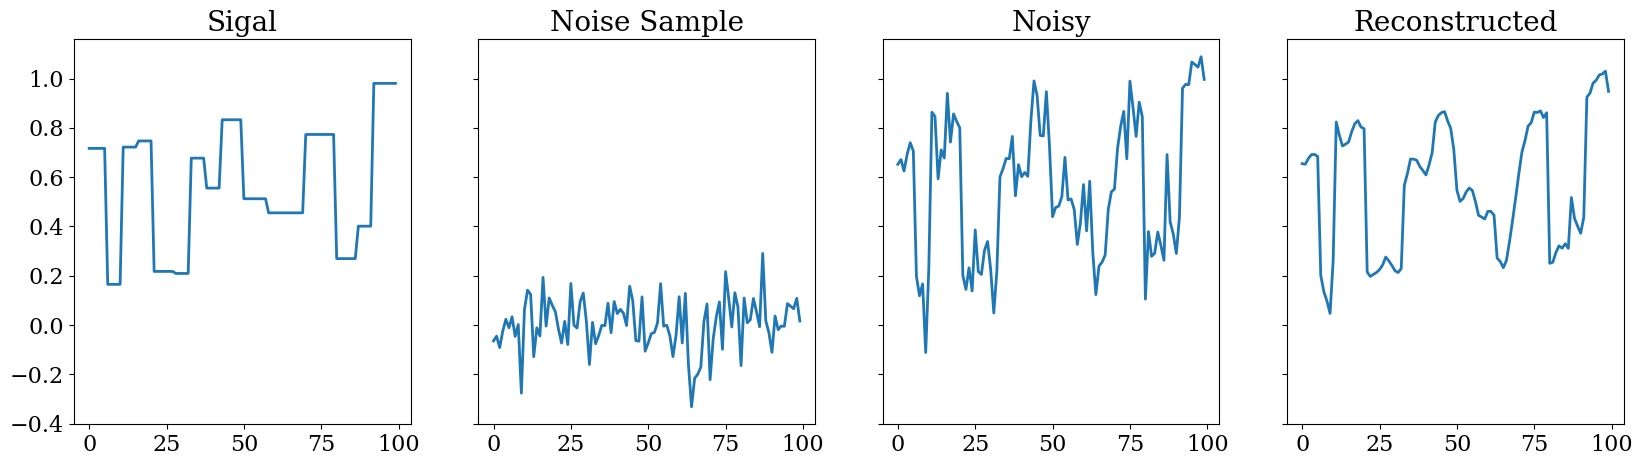

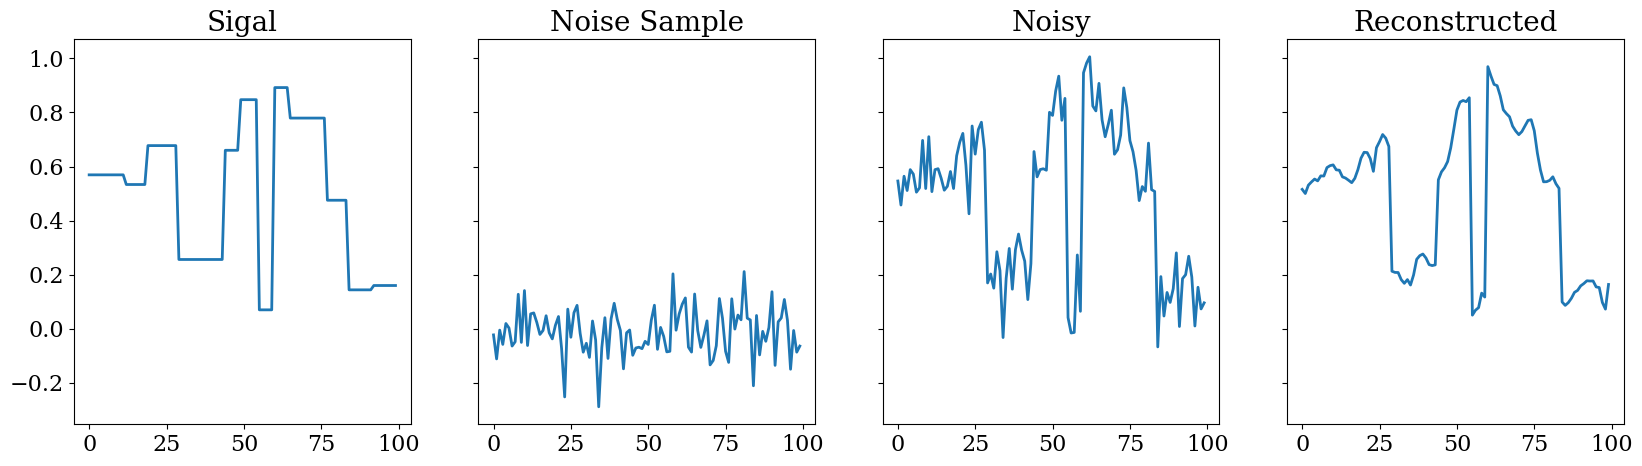

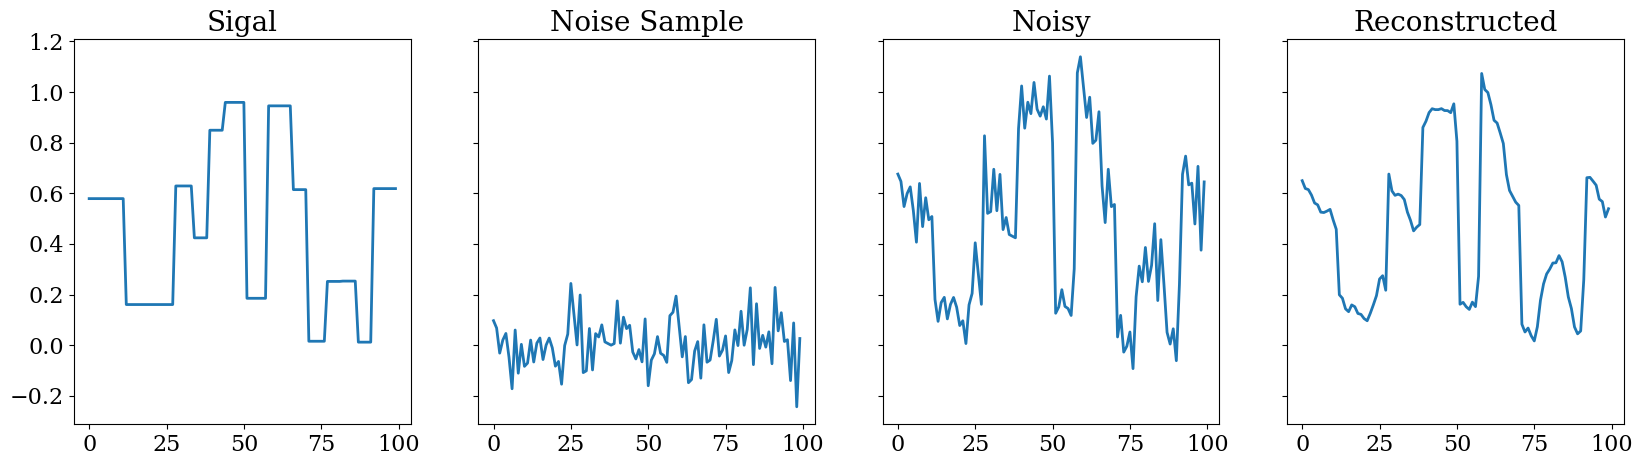

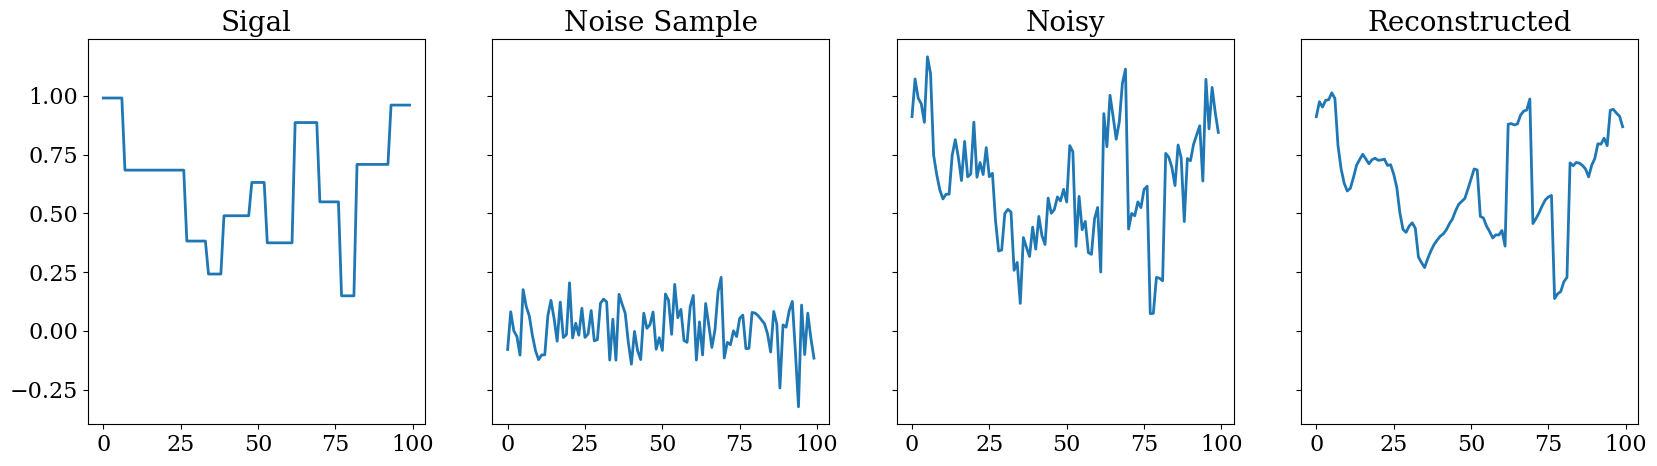

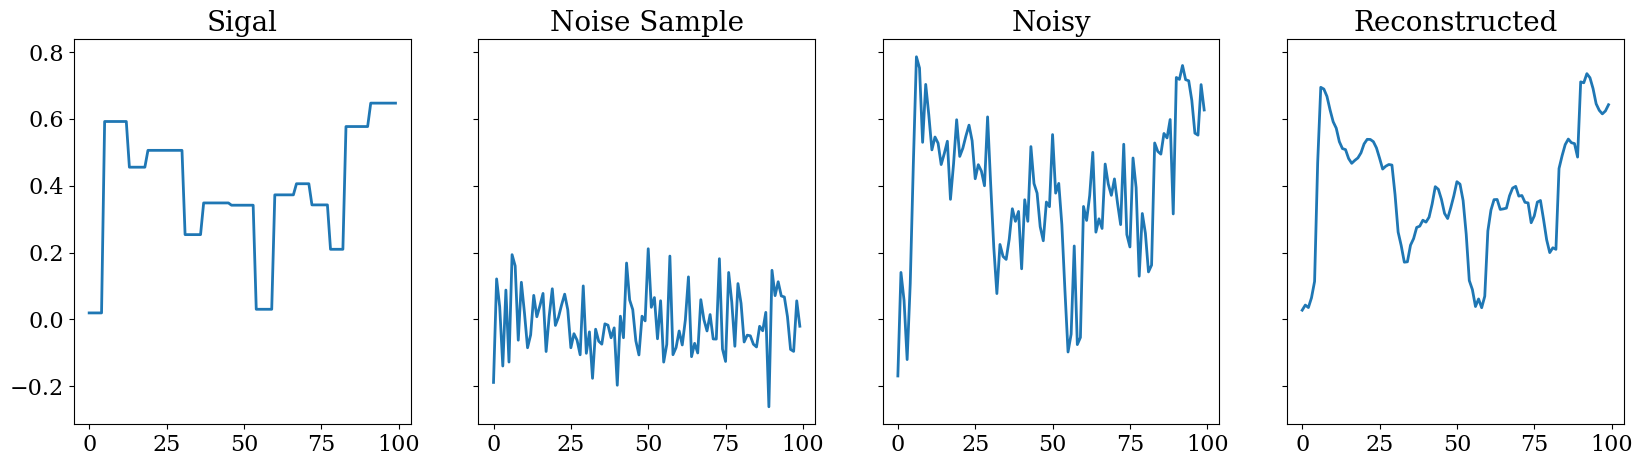

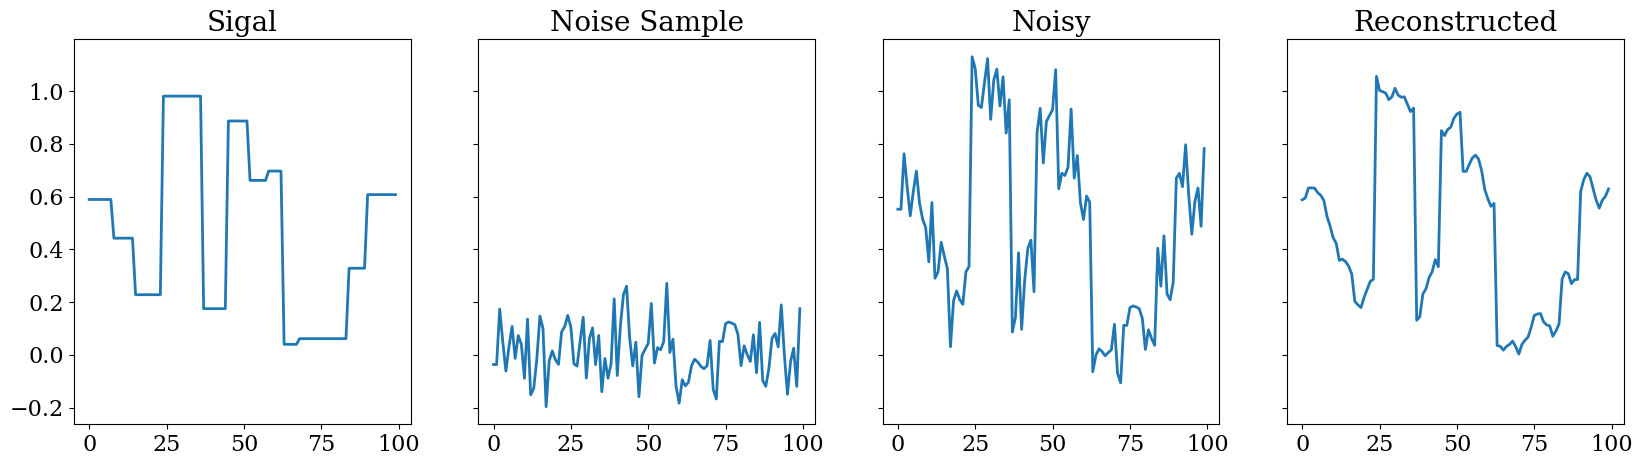

In [ ]:
for i in range(10):
    visualize_denoising(val_dataset[i].unsqueeze(0), net_nn, noise_std=noise_std, figsize=(20, 5))


In [ ]:
import os

from PIL import Image

import numpy as np
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

import cv2
# from skimage.measure.simple_metrics import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import glob
import pickle

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import argparse
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
sys.path.append('/scratch/kl3141/Denoising_Tutorial/electron-microscopy-denoising')
import data
import models
import utils

In [ ]:
device = torch.device('cpu')

In [ ]:
kernel_size = 2
# noise_std_array = [float(10)/255, float(25)/255, float(55)/255];

n_examples = 3 #number of examples to plot

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet')
sys.path.append('/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/image_wavelet/multiscale_py/')

import image_dataset
import haar_soft_threshold_2d_net
import linearcnn

In [ ]:
# net = linearcnn.linearcnn(kernel_size=3);

### Plot Function for Filter

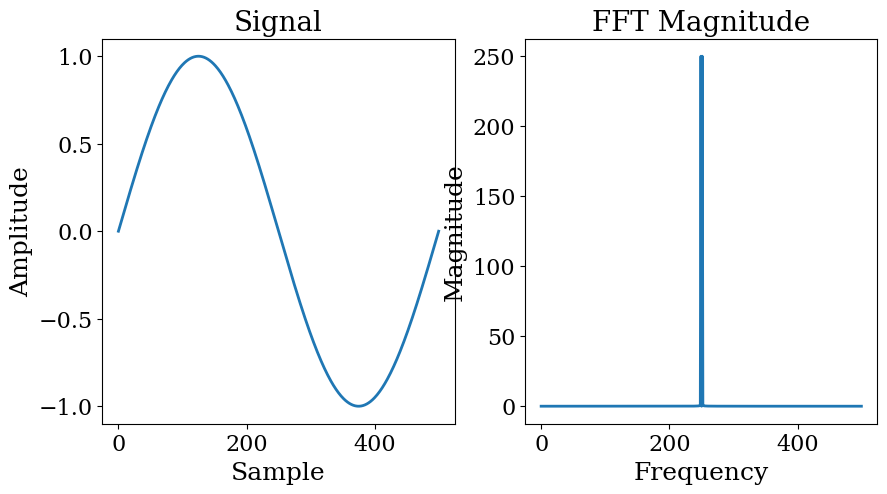

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signal_and_fft(signal, ax=None, title_string=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

    ax[0].plot(signal)
    ax[0].set_title('Signal')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel('Amplitude')

    fft_values = np.fft.fftshift(np.fft.fft(signal))
    fft_magnitude = np.abs(fft_values)

    ax[1].plot(fft_magnitude)
    ax[1].set_title('FFT Magnitude')
    ax[1].set_xlabel('Frequency')
    ax[1].set_ylabel('Magnitude')

    if title_string is not None:
        ax[0].set_title(title_string + ' - Signal')
        ax[1].set_title(title_string + ' - FFT')

def visualize_filters_1d(net):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 5))

    # Assuming net.first_layer.weight.cpu().data.numpy()[0] gives us the 1D filter.
    filter_1d = net.first_layer.weight.cpu().data.numpy()[0]

    plot_signal_and_fft(filter_1d, ax, "Filter")

    plt.show()

# Example usage: Replace 'your_net' with the actual network instance.
# visualize_filters_1d(your_net)

# Example usage
signal = np.sin(2 * np.pi * np.linspace(0, 1, 500))  # Replace this with your 1D signal
plot_signal_and_fft(signal)


### Creating Dataloader

n_val random images are set for validation while rest of the images are in training

In [ ]:
# n_val = 25;
# files_source = glob.glob(os.path.join(path_to_image_data, '*.png'))
# files_source = np.sort(files_source)
# list_val_images = files_source[-n_val:]
# list_train_images = list( set(files_source) - set(list_val_images));

In [ ]:
# list_train_images

In [ ]:
# import torch.utils.data as udata

# class PieceWiseConstantDataset(udata.Dataset):

#     def __init__(self, n_data = 1000, n_signal = 50, prob=0.3, fix_datapoints = False):
#         super(PieceWiseConstantDataset, self).__init__()

#         self.n_data = n_data;
#         self.n_signal = n_signal;
#         self.prob = prob
#         self.fix_datapoints = fix_datapoints;

#         if self.fix_datapoints:
#             self.data_list = [None] * self.n_data;
#             for i in range(self.n_data):
#                 self.data_list[i] = self.gen_piecewise_constant(self.n_signal, self.prob);

#     def __len__(self):
#         return self.n_data

#     def gen_piecewise_constant(self, n, prob):
#         signal = np.zeros(n)
#         val = np.random.uniform(-1, 1);
#         ind = np.random.randint(n)
#         for i in range(n):
#             signal[ind] = val
#             if np.random.rand() < prob:
#                 val = np.random.uniform(-1, 1);
#             ind = np.mod(ind + 1,n)
#         return signal

#     def __getitem__(self, index):

#         if self.fix_datapoints:
#             signal = self.data_list[index];
#         else:
#             signal = self.gen_piecewise_constant(self.n_signal, self.prob);

#         return torch.from_numpy(signal).unsqueeze(0).type(torch.FloatTensor)



In [ ]:
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_loader = val_loader
test_dataset = test_loader.dataset

# Image Statstics

In [ ]:
import numpy as np

def find_expected_coeff_square_1d(train_dataset):
    n = len(train_dataset)
    print(n)
    abs_coeff_sum = 0
    processed_samples = 0

    for i in range(n):
        sample = train_dataset[i]
#         print(sample)

#         # Check if sample is a NumPy array or needs to be converted
#         if not isinstance(sample, np.ndarray):
#             sample = np.array(sample)

#         print(sample)
#         # Debugging: Print the shape and type
#         print(f"Shape: {sample.shape}")
#         print(f"Type: {type(sample)}")

#         if len(sample.shape) != 1:
#             print(f"Skipping sample {i} as it is not 1D.")
#             continue

        # Perform FFT and accumulate
        temp = np.fft.fftshift(np.fft.fft(sample))
        abs_coeff_sum += np.abs(temp) ** 2
        processed_samples += 1

    if processed_samples == 0:
        print("No 1D samples processed.")
        return None

    abs_coeff_avg = abs_coeff_sum / processed_samples
    return abs_coeff_avg


# Example usage, adapt based on how you've structured your Dataset class
# expected_coeff_square = find_expected_coeff_square_1d(train_dataset)


# Example usage:
# Assuming 'dataset_1d' is an instance of a PyTorch Dataset containing your 1D signals
# This part depends on how you've structured your Dataset class
# If your dataset returns a tensor wrapped in some other data structure, you might need to adapt this code.

# expected_coeff_square = find_expected_coeff_square_1d(dataset_1d)


In [ ]:
mean_coeff_sq = find_expected_coeff_square_1d(train_dataset)

500


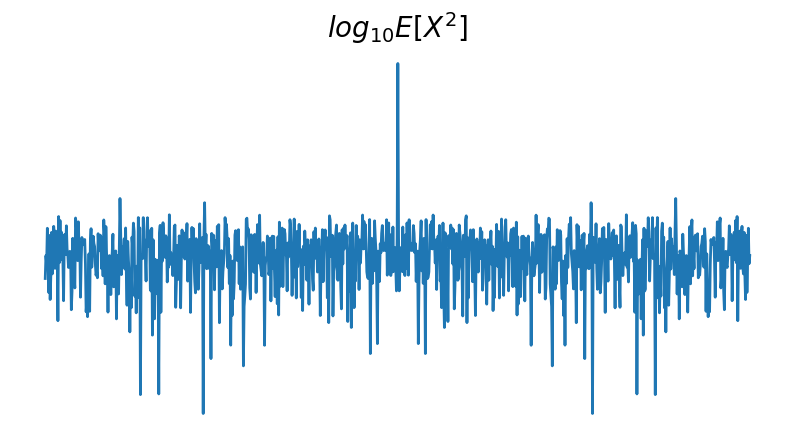

In [ ]:
def plot_signal_values(ax=None, signal=None, title_string=None, ax_off=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    ax.plot(np.log10(signal))

    ax.set_xlabel('Frequency')
    ax.set_ylabel('Log Magnitude')

    if title_string is not None:
        ax.set_title(title_string)

    if ax_off:
        ax.axis('off')

# Example usage
mean_coeff_sq = np.abs(np.fft.fftshift(np.fft.fft(np.random.rand(1000)))) ** 2  # Replace this with your mean_coeff_sq
plot_signal_values(ax=None, signal=mean_coeff_sq, title_string='$log_{10}E[X^2]$', ax_off=True)


## Look at Examples

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def batch_PSNR_1D(signals, clean_signals, data_range):
    Signals = signals.data.cpu().numpy().astype(np.float32)
    CleanSignals = clean_signals.data.cpu().numpy().astype(np.float32)
    PSNR = 0.0

    for i in range(Signals.shape[0]):
        PSNR += compare_psnr(CleanSignals[i, :], Signals[i, :], data_range=data_range)

    return PSNR / Signals.shape[0]

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def batch_PSNR(signals, clean_signals, data_range):
    Signals = signals.data.cpu().numpy().astype(np.float32)
    CleanSignals = clean_signals.data.cpu().numpy().astype(np.float32)
    PSNR = 0.0

    for i in range(Signals.shape[0]):
        PSNR += compare_psnr(CleanSignals[i, :], Signals[i, :], data_range=data_range)

    return PSNR / Signals.shape[0]

In [ ]:
from torch.distributions import Poisson

In [ ]:


def tensor_to_signal_1D(torch_signal, low=0.0, high=1.0, clamp=False):
    if clamp:
        torch_signal = torch.clamp(torch_signal, low, high)
    return torch_signal[0].cpu().data.numpy()


In [ ]:
def plot_1d_log_fft(signal, ax=None, ax_off=True, title_string=None):
    fft_shifted = np.fft.fftshift(np.fft.fft(signal))
    mat = np.log10(np.abs(fft_shifted) + 1e-9)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if ax_off:
        ax.axis('off')

    ax.plot(mat)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude (Log Scale)')

    if title_string is not None:
        ax.set_title(title_string)

    return mat


In [ ]:


def get_noise(data, noise_std = 0.1,mode='G', max_noise=5e-1,noise_scale=1):
    noise = torch.randn_like(data);
    noise.data = noise.data * noise_std;
    return noise

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume batch_PSNR and get_noise are defined elsewhere
# Assume tensor_to_image for 1D is also defined elsewhere

def plot_1d_log_fft(signal, ax=None):
    fft = np.fft.fftshift(np.fft.fft(signal))
    mat = np.log10(np.abs(fft) + 1e-9)
    ax.plot(mat)
    ax.set_title('Log FFT')
    return mat

def visualize_denoising(source, net, noise_std=0.1, noise_sample=None, noise_scale=1.0, figsize=(20, 5)):
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    axes[0].plot(tensor_to_signal_1D(source))
    axes[0].set_title('Original')

    if noise_sample is None:
        noisy = source + get_noise(source, noise_std=noise_std, noise_scale=noise_scale)

    axes[1].plot(tensor_to_signal_1D(noisy))
    axes[1].set_title(f'Noisy - PSNR: {batch_PSNR_1D(noisy, source, 1.0):.2f}')

    denoised = net(noisy)
    axes[2].plot(tensor_to_signal_1D(denoised))
    axes[2].set_title(f'Denoised - PSNR: {batch_PSNR_1D(torch.clamp(denoised, 0.0, 1.0), source, 1.0):.2f}')

    plt.subplots_adjust(wspace=0.4)
    plt.show()

# Example usage:
# Let's assume `source` is your 1D piecewise constant signal tensor and `net` is your denoising model.
# visualize_denoising(source, net)


### Visalizing Before Training

In [ ]:
val_dataset[0]

tensor([[0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.0567,
         0.0567, 0.0567, 0.0567, 0.0567, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777,
         0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.8701,
         0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701,
         0.8701, 0.8701, 0.8701, 0.4736, 0.4736, 0.4736, 0.4736, 0.4736, 0.7369,
         0.7369, 0.7369, 0.7369, 0.7369, 0.1352, 0.1352, 0.1352, 0.1352, 0.1352,
         0.1352, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223,
         0.2223, 0.2223, 0.9698, 0.9698, 0.9698, 0.9698, 0.9698, 0.9698, 0.3582,
         0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.6343, 0.6343,
         0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343,
         0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343,
         0.6343]])

In [ ]:
train_dataset[0].size()

torch.Size([1, 100])

In [ ]:
net = linearcnn.linearcnn(kernel_size=3)

1


In [ ]:
import torch.nn as nn

class LinearCNN1D(nn.Module):
    def __init__(self, kernel_size=3):
        super(LinearCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size, padding=(kernel_size-1)//2)
        print((kernel_size-1)//2)

    def forward(self, x):
        # Assuming input x is of shape (batch_size, signal_length)
        # Reshape to (batch_size, 1, signal_length) for 1D convolution
        x = x.unsqueeze(1)

        rec_img = self.conv1(x)

        # Reshape back to (batch_size, signal_length)
        rec_img = rec_img.squeeze(1)

        return rec_img



In [ ]:
net = LinearCNN1D()

1


In [ ]:
device = torch.device('cpu')

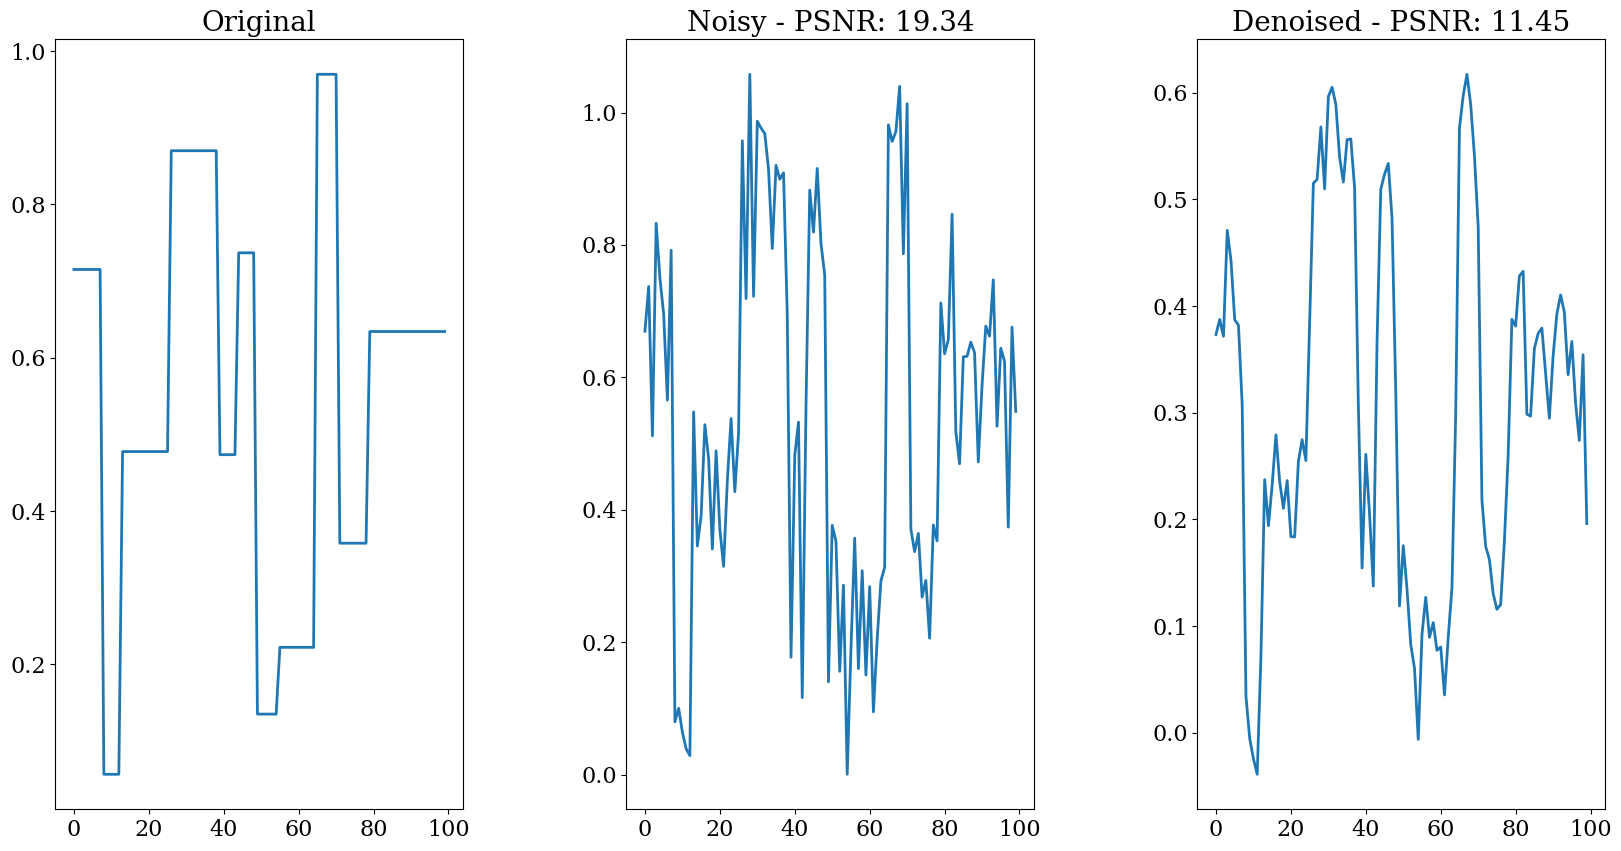

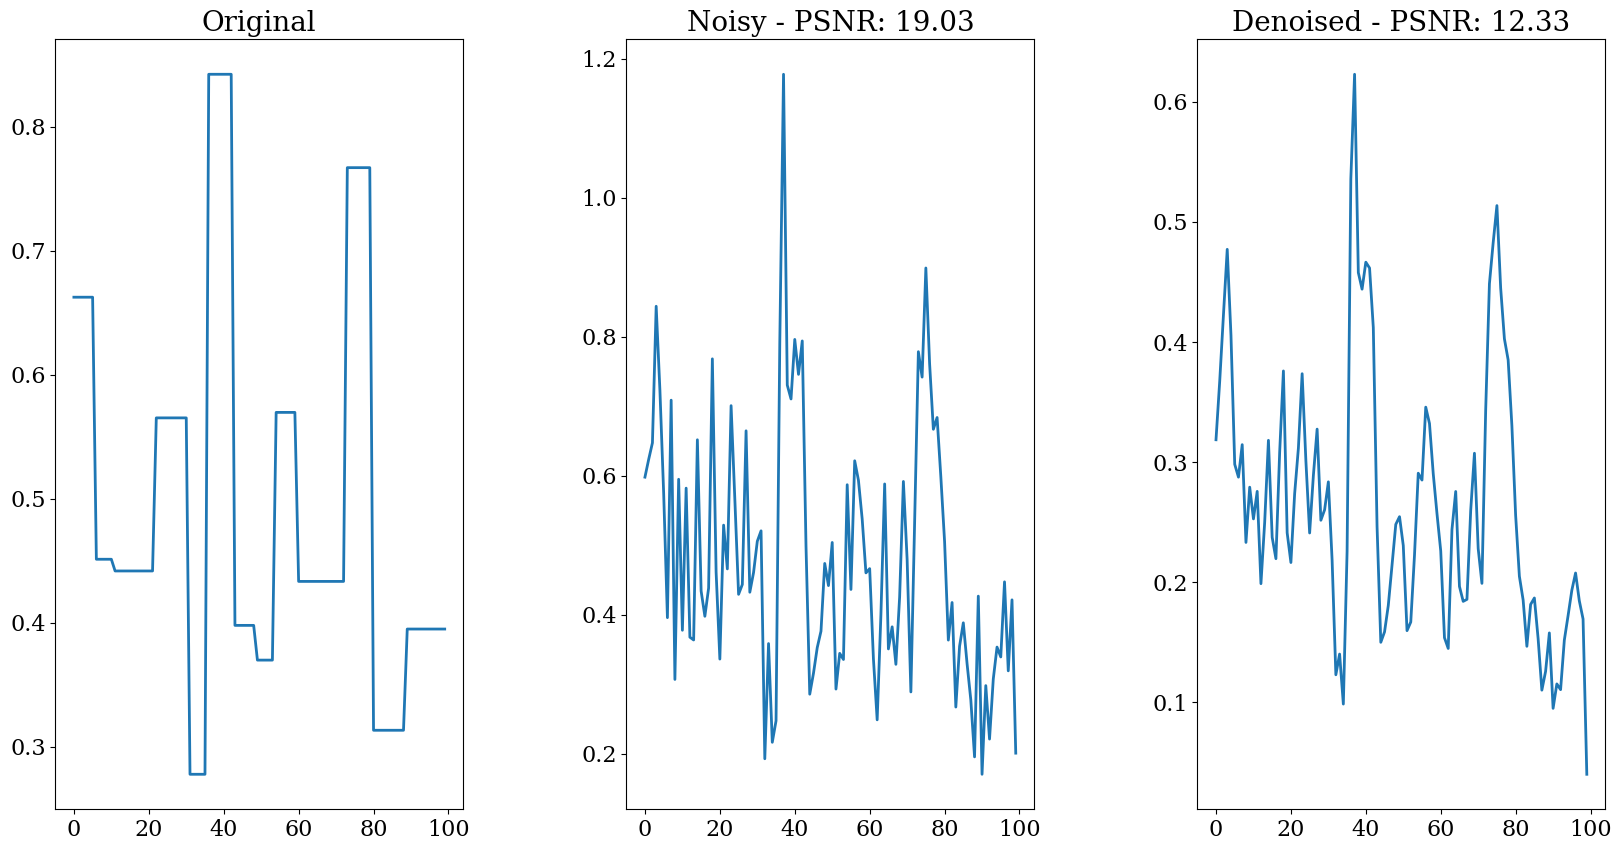

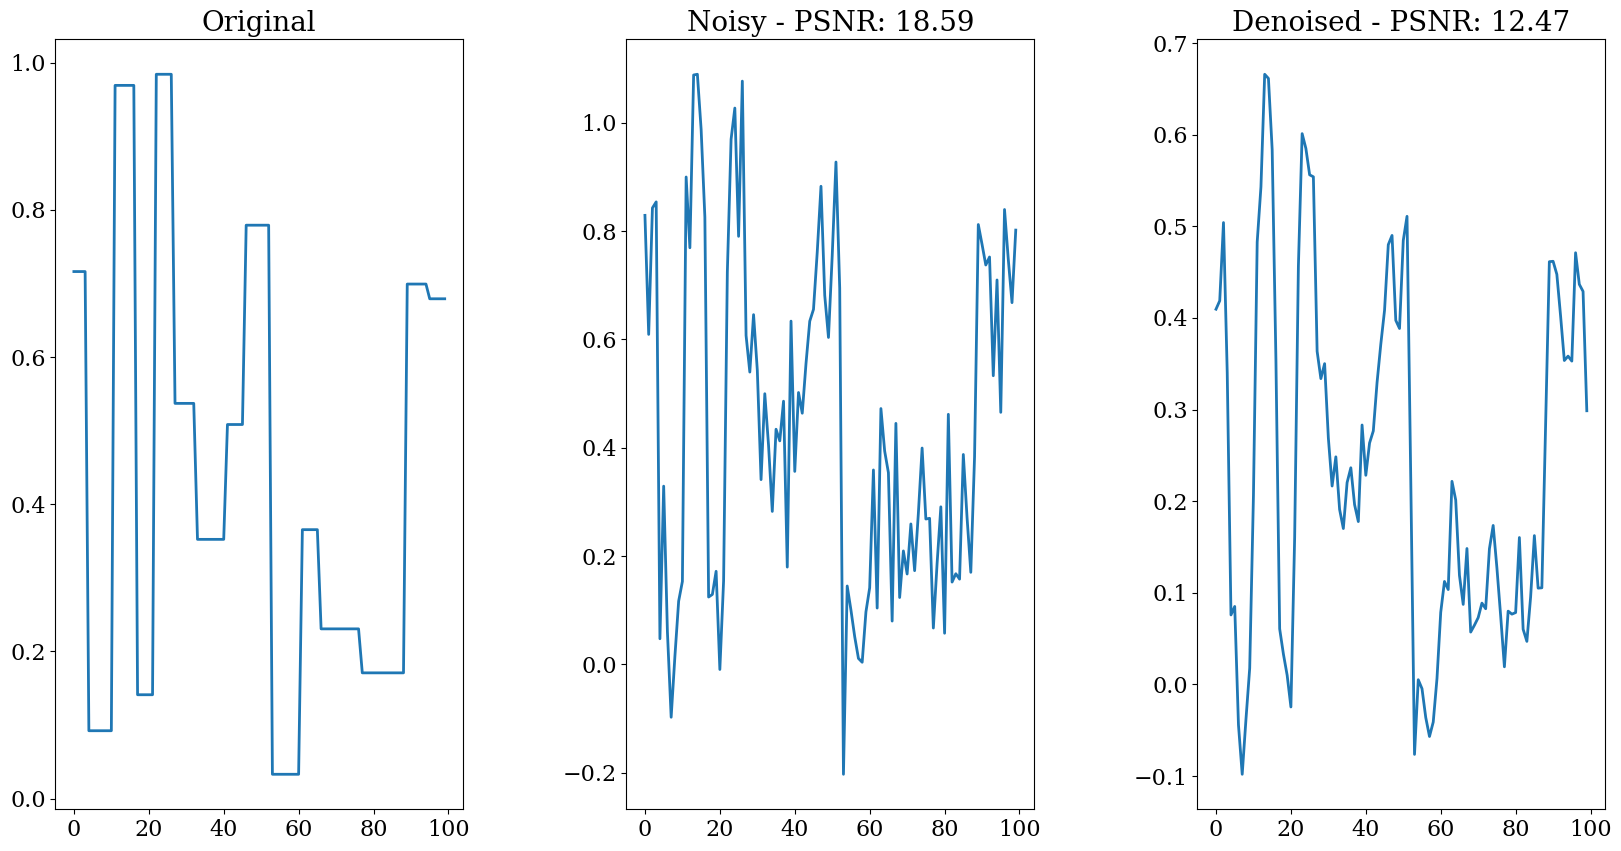

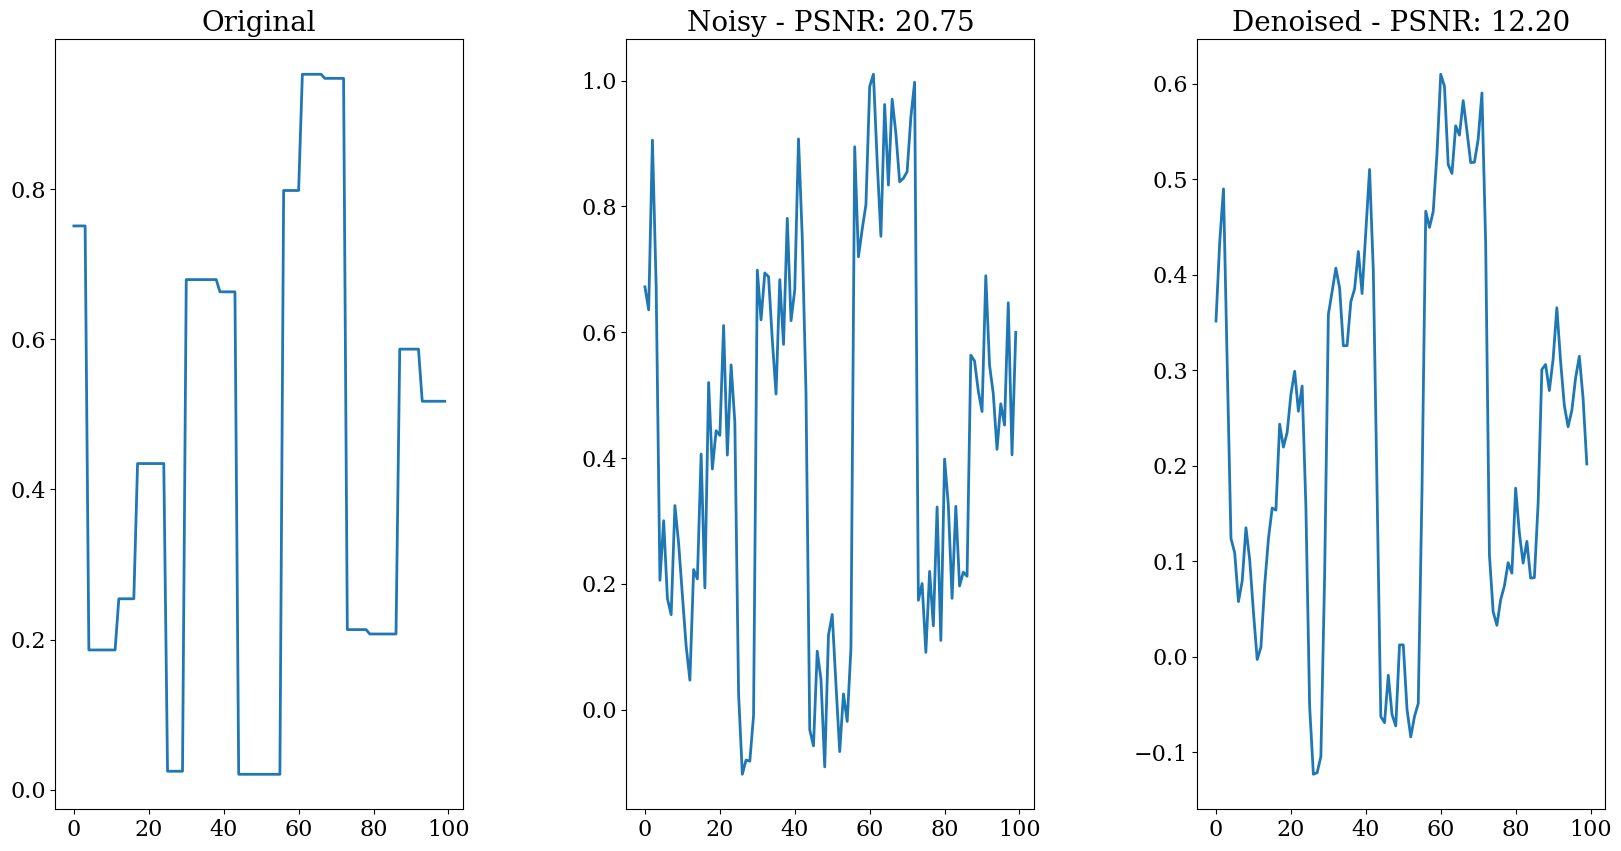

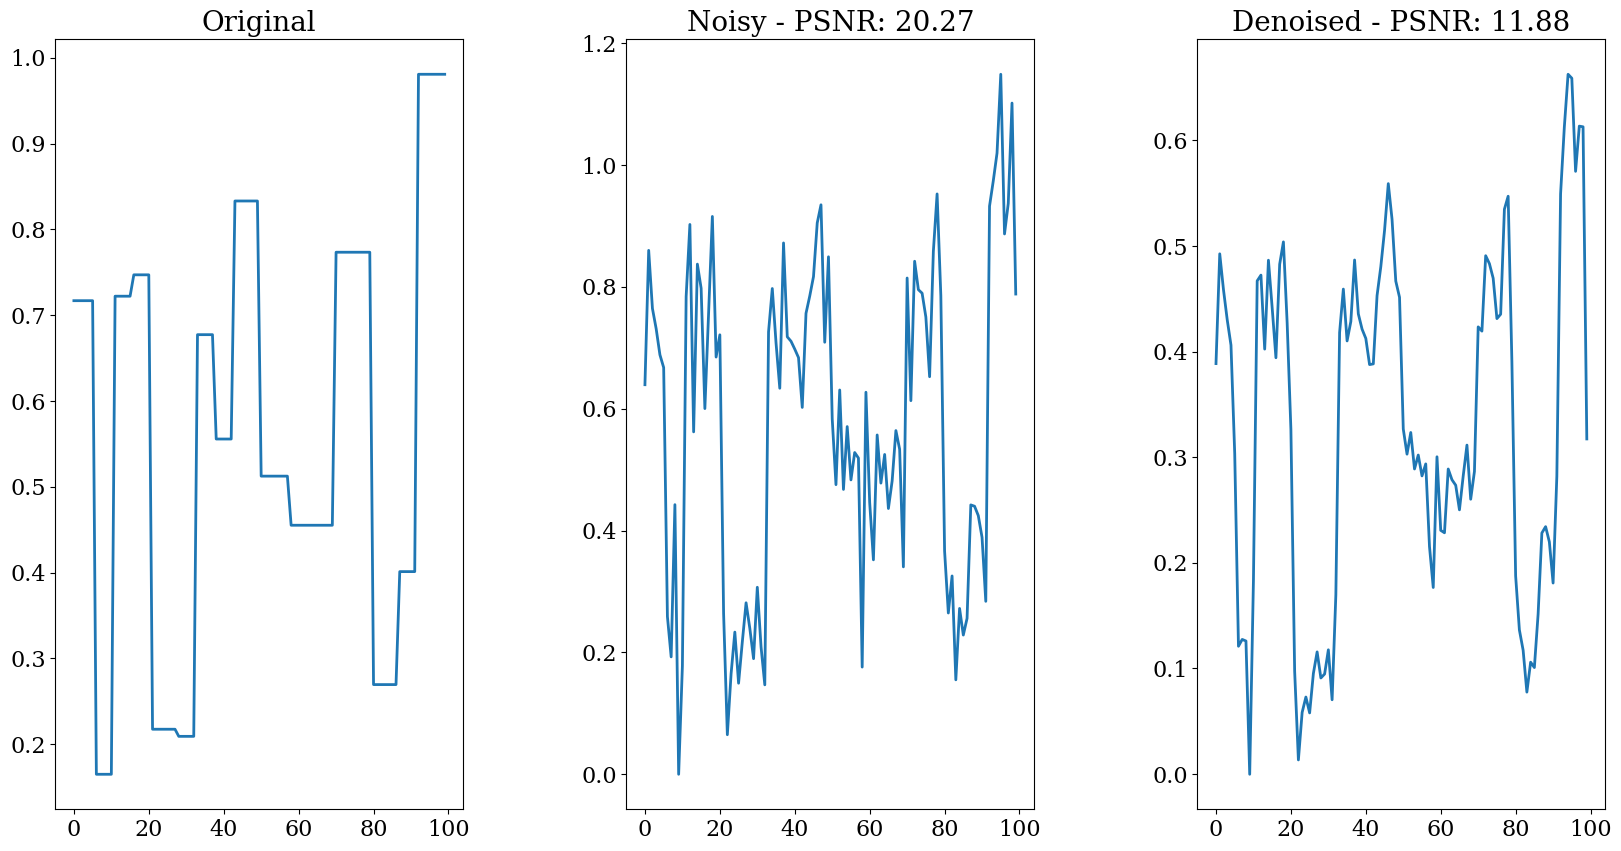

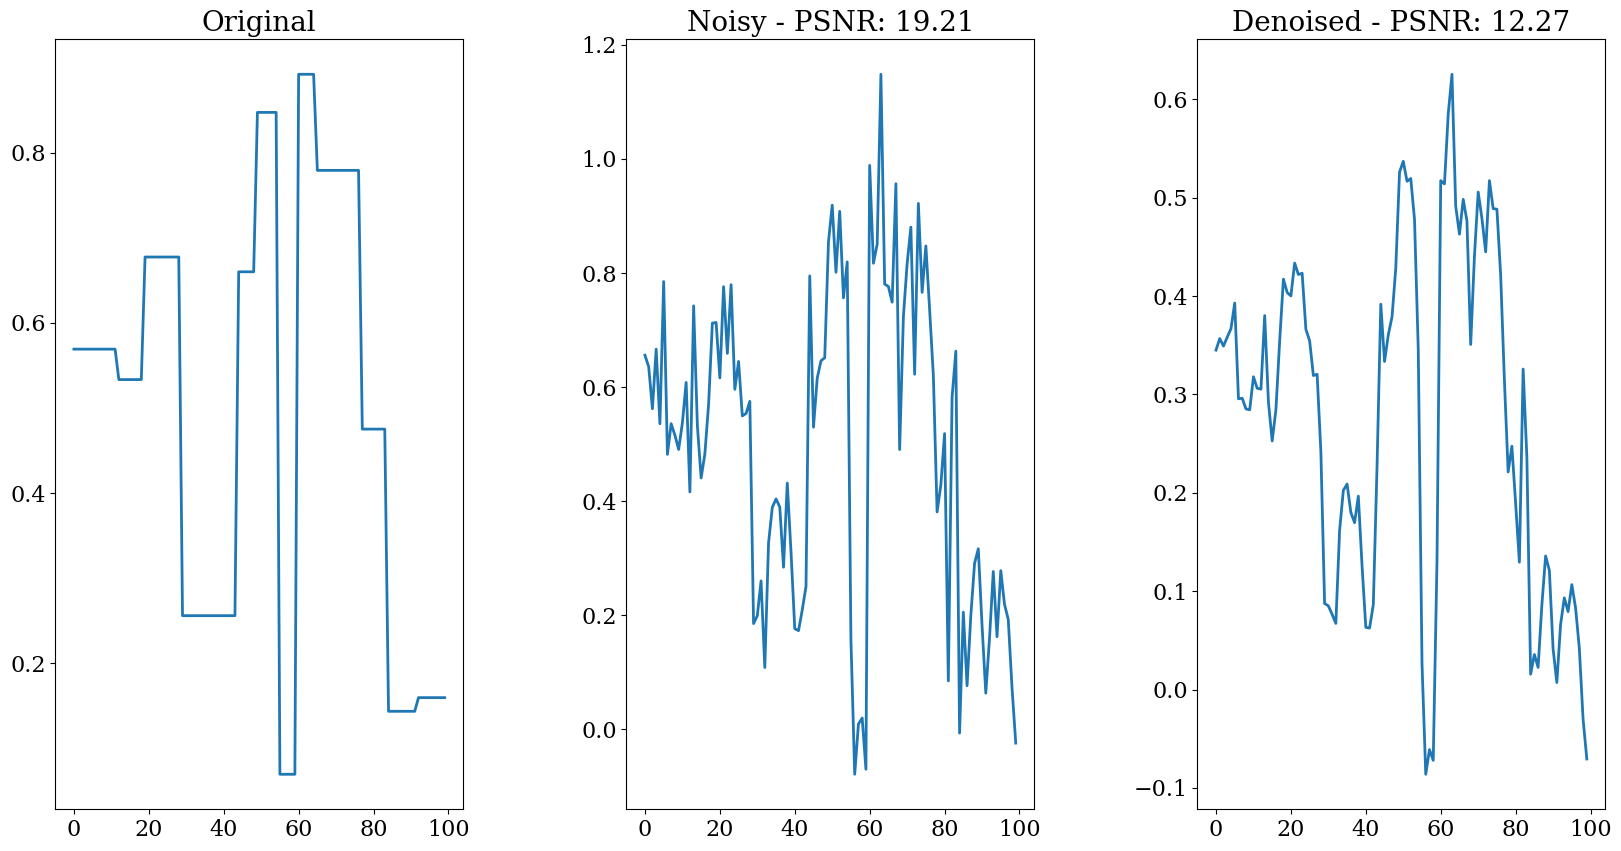

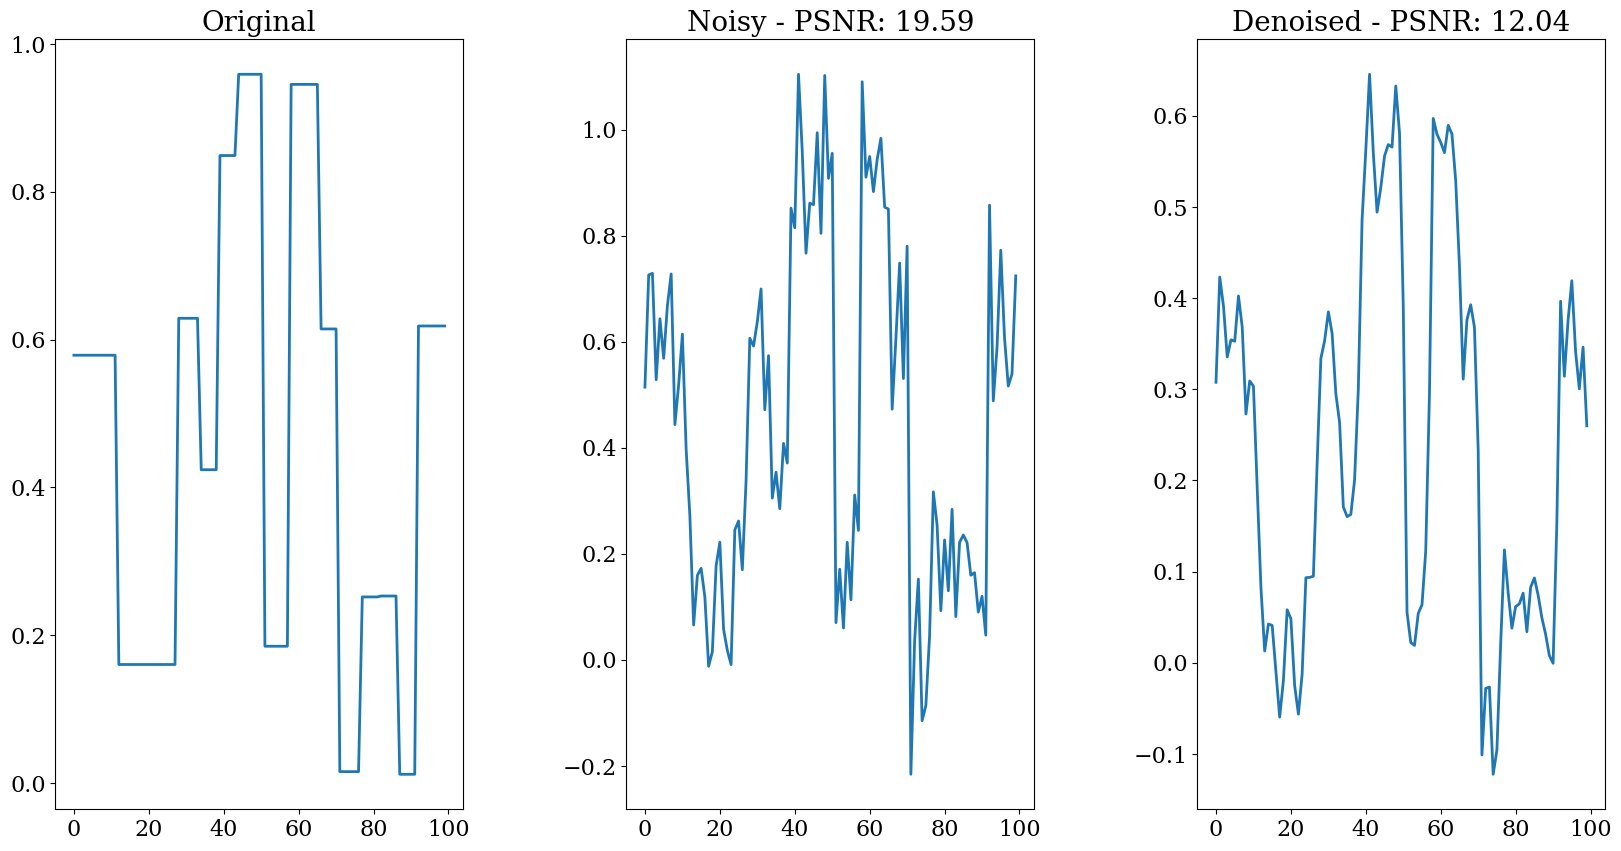

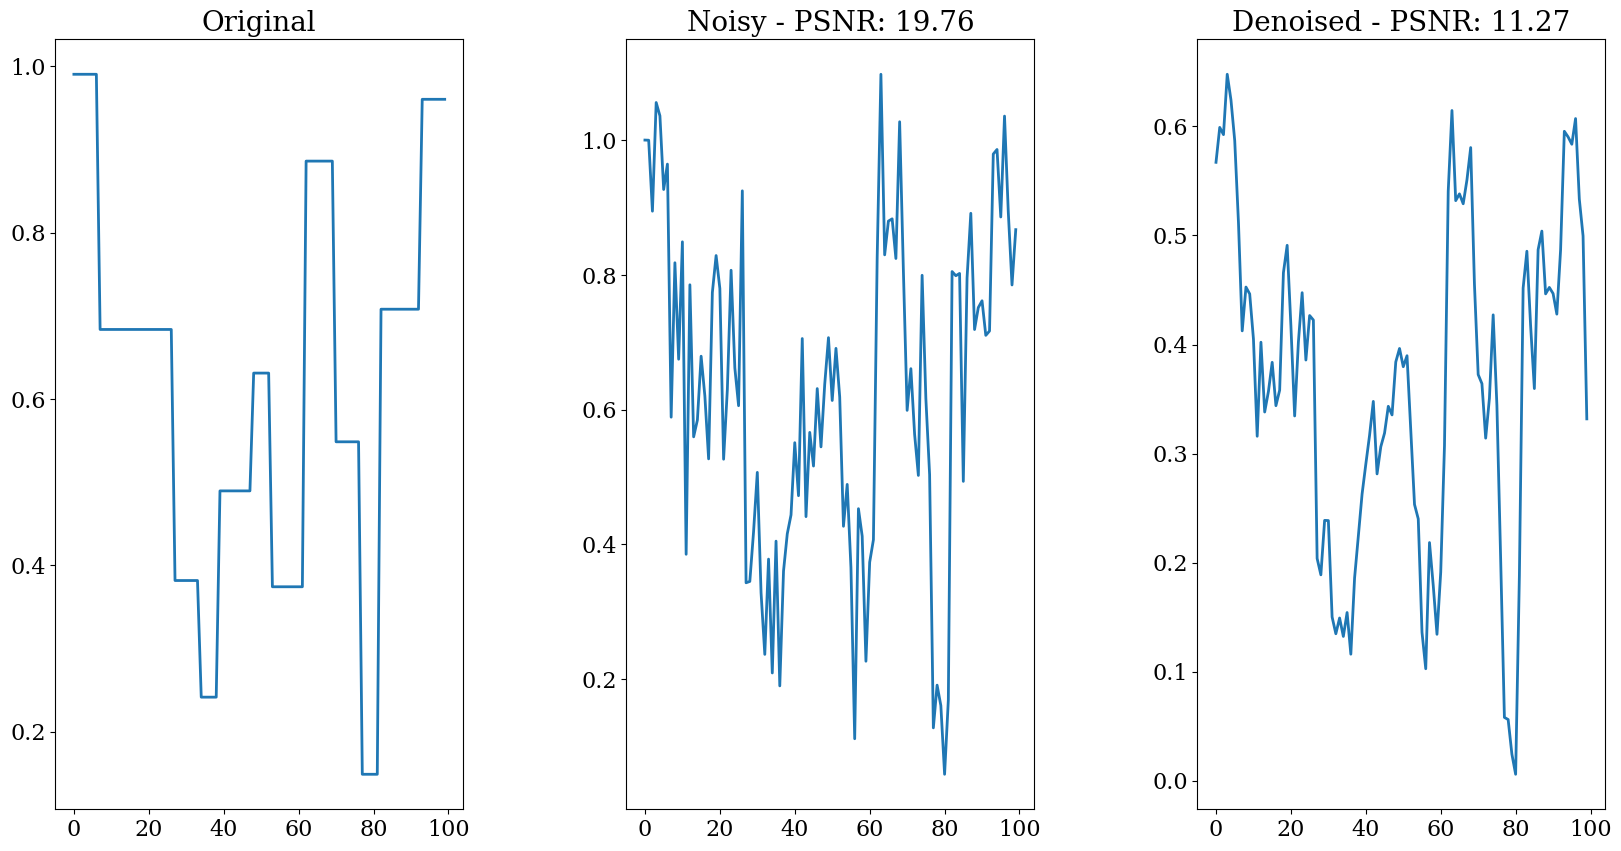

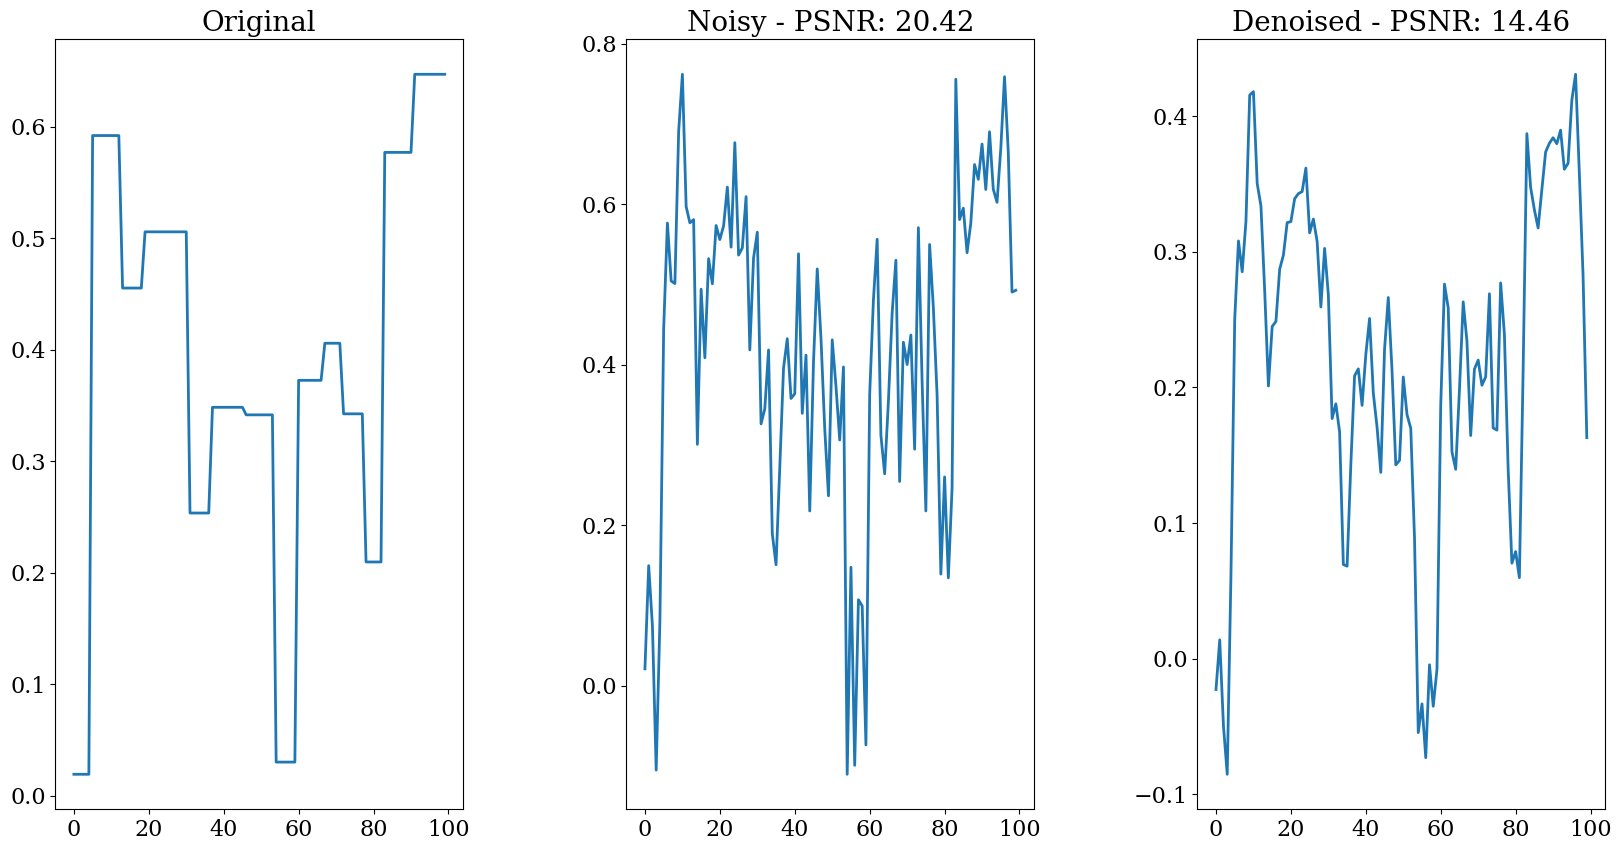

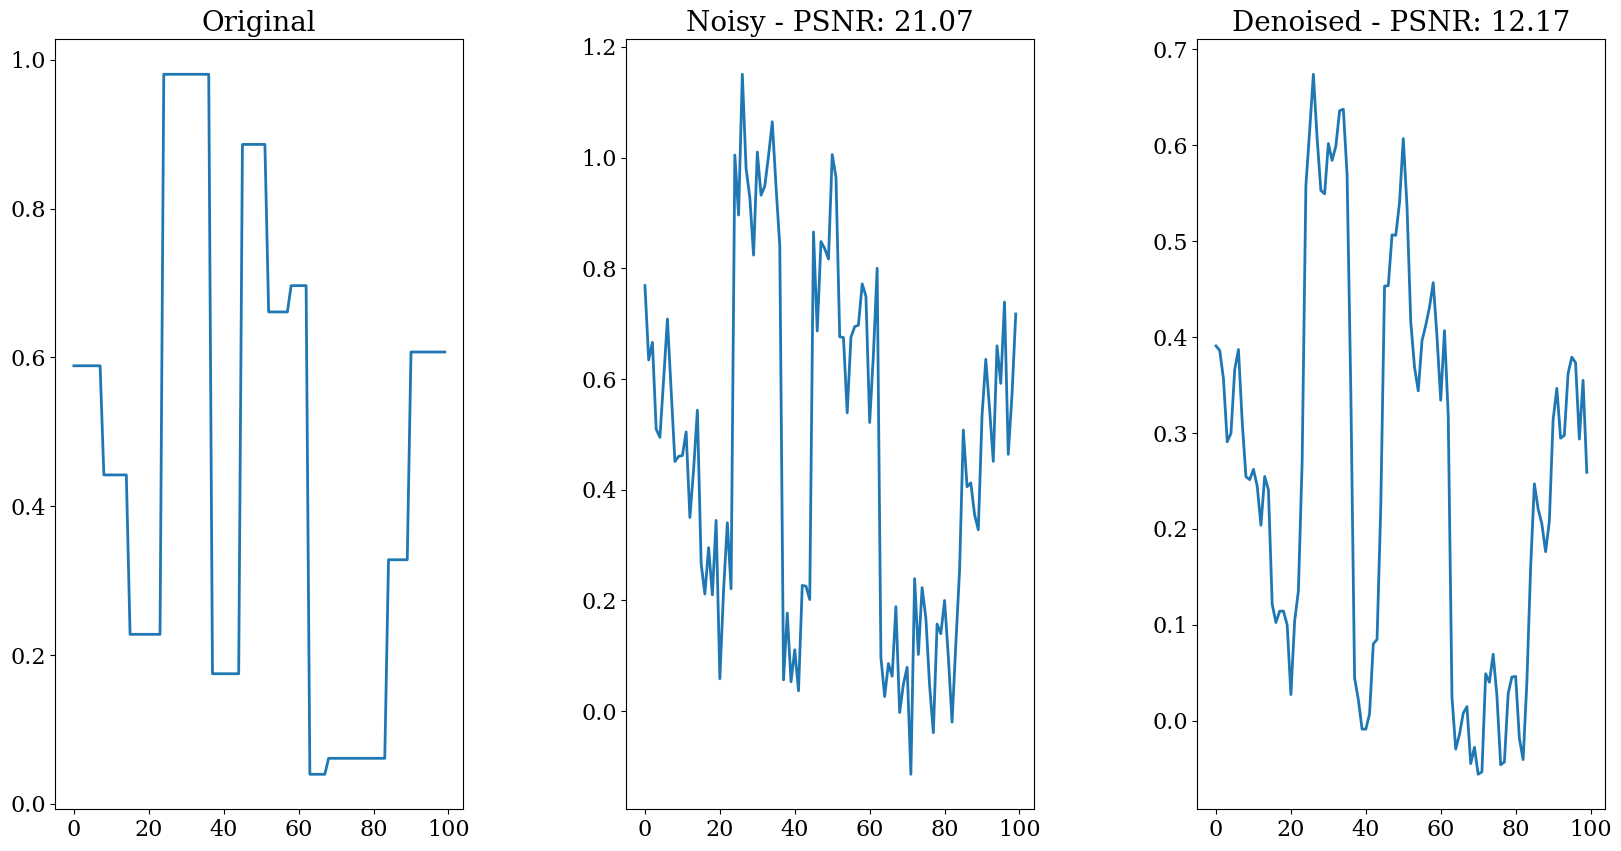

In [ ]:
# noise_std = np.random.choice(noise_std_array)
n_examples = 10
for i in range(n_examples):
    visualize_denoising(val_dataset[i].to(device), net.to(device), noise_std=noise_std, noise_scale=noise_scale, figsize=(20, 10))

## Theoretical Wiener Filter

In [ ]:
import numpy as np


def theoretical_wiener_from_data_1d(train_dataset, fft_shift=True, noise_std=0.1, fft_sample=100, n=10, noise_scale=50):
    first_sample = train_dataset[0].numpy()
    signal_squeeze = False

    # Check if it's a 1D array
    if len(first_sample.shape) != 1:
        signal_squeeze = True
#         print("Skipping: Not a 1D array.")
#         return None

    mean_coeff = np.fft.fft(first_sample, n=fft_sample) * 0.0

    for i in range(n):
        for x_tensor in train_dataset:
            if signal_squeeze:
                x_tensor = x_tensor.squeeze()
            x = x_tensor.numpy()

            if len(x.shape) != 1:
                print("Skipping: Not a 1D array.")
                continue
#             plt.figure()
#             plt.plot(x)
#             plt.show()
#             plt.close()
#             print(x.shape)
            noisy = x + get_noise(x_tensor, mode='G', noise_std=noise_std, noise_scale=noise_scale).numpy()
#             print(noisy.shape)
#             plt.figure()
#             plt.plot(noisy)
# #             print(np.min(noisy))
#             plt.show()
#             plt.close()

            noise_fft = np.fft.fft(noisy, n=fft_sample)
#             print(noise_fft)


            clean_fft = np.fft.fft(x, n=fft_sample)

            mean_coeff += clean_fft * np.conjugate(noise_fft) / (np.abs(noise_fft + 1e-8)**2)
#             print(clean_fft * np.conjugate(noise_fft) / (np.abs(noise_fft + 1e-8)**2))

    mean_coeff /= (n * len(train_dataset))
    mean_coeff = mean_coeff[0]
#     print(mean_coeff.shape)

    if fft_shift:
        return np.fft.fftshift(mean_coeff)
    else:
        return mean_coeff

# Sample usage with PyTorch tensors (Replace this with your actual dataset)
# import torch
# train_dataset = [torch.tensor([1.0, 2.0, 3.0]), torch.tensor([4.0, 5.0, 6.0])]

result = theoretical_wiener_from_data_1d(train_dataset,fft_sample=signal_length,noise_std=noise_std)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_number_line(ax, values, title=''):
    ax.set_title(title)
    ax.plot(values)

def plot_filter_and_fft_from_fft_1d(fft_vector, s=17):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title('Filter')
    axes[1].set_title('$log_{10}(FFT)$')

    filter_np = np.real(np.fft.ifft(np.fft.ifftshift(fft_vector), n=s))
    log_fft = np.log10(np.abs(fft_vector))

    plot_number_line(axes[0], filter_np)
    plot_number_line(axes[1], log_fft)

# Example usage:
# fft_vector = np.fft.fft(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))
# theoretical_wiener_from_data_1d(fft_vector)


### Visualizing filters

In [ ]:
noise_std

0.1

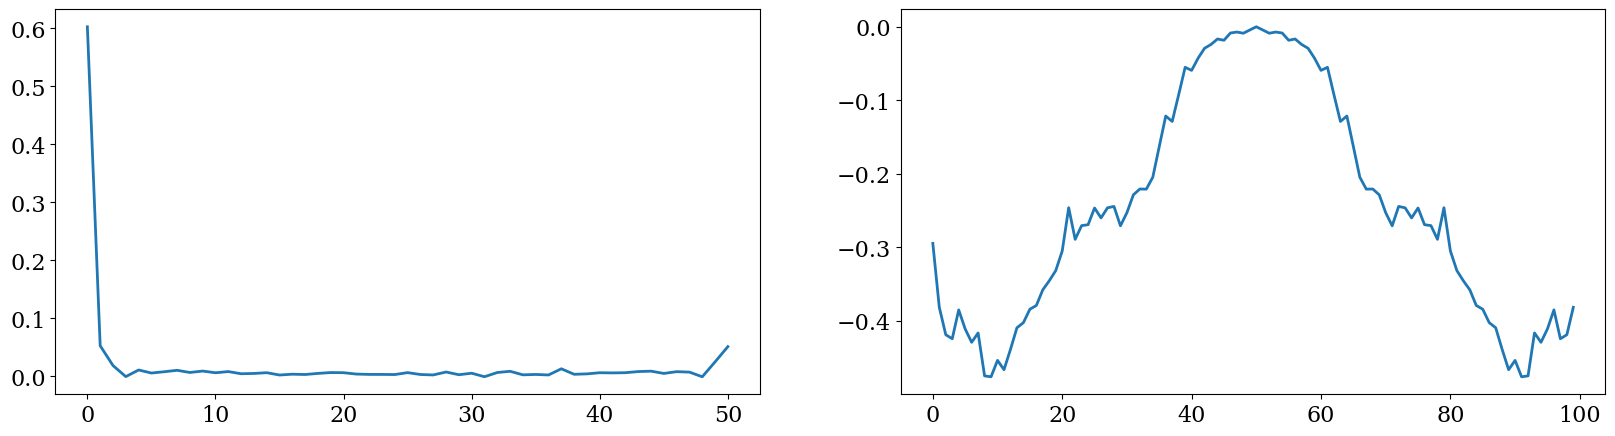

In [ ]:
wiener_star = theoretical_wiener_from_data_1d(train_dataset,fft_sample=signal_length,noise_std=noise_std,noise_scale=noise_scale)
#     wiener_star = theoretical_wiener_from_expected_coeff_sq(mean_coeff_sq, noise_std, len(train_dataset));
plot_filter_and_fft_from_fft_1d(wiener_star, s = 51)
plt.show()

In [ ]:
wiener_star

array([0.50759751+1.09626611e-13j, 0.41530554-1.21984702e-02j,
       0.38120881-8.05547318e-03j, 0.37600277+1.94399582e-02j,
       0.41142904+2.39881046e-02j, 0.38813535-1.04534503e-02j,
       0.37232918+3.24197946e-03j, 0.38336331+7.70610400e-03j,
       0.33401817+2.76675564e-02j, 0.33413432+8.72214942e-03j,
       0.3516164 -1.30321807e-02j, 0.34001751+3.42813843e-02j,
       0.36387031-1.40754033e-02j, 0.38970924+5.42966174e-04j,
       0.39596956-4.67186797e-03j, 0.41275265-1.42311320e-02j,
       0.41590315-4.02941788e-02j, 0.43891567-1.52133195e-03j,
       0.45042518-3.13863709e-02j, 0.46596005+1.27895587e-02j,
       0.4952246 -1.88182913e-02j, 0.56753274+5.30001583e-03j,
       0.51363579+2.01822838e-02j, 0.53610548-2.26375542e-02j,
       0.53806198-1.16758412e-02j, 0.56697669-9.03820298e-03j,
       0.54969699+3.18432934e-03j, 0.56736906-2.15528125e-03j,
       0.56966773-1.47717120e-02j, 0.53618257+8.85576659e-03j,
       0.55880852+3.48191239e-03j, 0.59093977+7.6291243

### Visualize Theoretical Wiener Denoising

In [ ]:
import numpy as np
from tqdm import tqdm
# Define your get_noise function here
# ...

# Placeholder for the compare_psnr function
def compare_psnr(img1, img2, data_range=1):
    mse = np.mean((img1 - img2) ** 2)
    psnr = 10 * np.log10((data_range ** 2) / mse)
    return psnr

def best_wiener_loss_and_psnr_1d(val_dataset, wiener_star, fft_sample=100, noise_std=0.1, noise_scale=50):
    mean_loss = 0
    mean_psnr = 0
    mean_noisy_psnr = 0;

    for idx in tqdm(range(len(val_dataset))):
        source = val_dataset[idx]
#         print(source.shape)
        if len(source.shape) != 1:
            source = source.squeeze()
        # Add noise to the source
        noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)

        # Convert to numpy if necessary
        source = source if isinstance(source, np.ndarray) else source.numpy()
        noisy = noisy if isinstance(noisy, np.ndarray) else noisy.numpy()

        # Perform FFT and denoising in the frequency domain
        source_fft = np.fft.fftshift(np.fft.fft(source, n=fft_sample))
        noisy_fft = np.fft.fftshift(np.fft.fft(noisy, n=fft_sample))
        denoised_fft = noisy_fft * wiener_star

        # Perform inverse FFT and clip values
        source_ifft = np.clip(np.real(np.fft.ifft(np.fft.ifftshift(source_fft), n=fft_sample)), 0., 1.)
        noisy_ifft = np.clip(np.real(np.fft.ifft(np.fft.ifftshift(noisy_fft), n=fft_sample)), 0., 1.)
        denoised_ifft = np.clip(np.real(np.fft.ifft(np.fft.ifftshift(denoised_fft), n=fft_sample)), 0., 1.)

        # Calculate loss and PSNR
        mean_loss += np.linalg.norm(denoised_ifft - source_ifft) ** 2
        mean_psnr += compare_psnr(source_ifft, denoised_ifft, data_range=1.)
        mean_noisy_psnr += compare_psnr(source_ifft, noisy, data_range=1.)
    print(mean_noisy_psnr/len(val_dataset))
    return mean_loss / len(val_dataset), mean_psnr / len(val_dataset)

# Replace val_dataset and wiener_star with your actual 1D data arrays and filters.
# mean_loss, mean_psnr = best_wiener_loss_and_psnr_1d(val_dataset, wiener_star)


In [ ]:
len(val_dataset)

100

In [ ]:
val_dataset[0]

tensor([[0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.0567,
         0.0567, 0.0567, 0.0567, 0.0567, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777,
         0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.8701,
         0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701,
         0.8701, 0.8701, 0.8701, 0.4736, 0.4736, 0.4736, 0.4736, 0.4736, 0.7369,
         0.7369, 0.7369, 0.7369, 0.7369, 0.1352, 0.1352, 0.1352, 0.1352, 0.1352,
         0.1352, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223,
         0.2223, 0.2223, 0.9698, 0.9698, 0.9698, 0.9698, 0.9698, 0.9698, 0.3582,
         0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.6343, 0.6343,
         0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343,
         0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343,
         0.6343]])

In [ ]:
# for source in tqdm(val_dataset):
#     pass

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from scipy.fft import fftshift, fft, ifft

# Define your get_noise function here
# ...

def compare_psnr(img1, img2, data_range=1):
    mse = np.mean((img1 - img2) ** 2)
#     psnr = 10 * np.log10((data_range ** 2) / mse)
    epsilon = 1e-10  # A small constant to prevent division by zero
    psnr = 10 * np.log10((data_range ** 2) / (mse + epsilon))
    return psnr

def plot_1d_log_fft(data, ax):
    fft_data = fftshift(fft(data))
    ax.semilogy(np.abs(fft_data))
    ax.set_title('Log FFT')

def visualize_best_wiener_denoising_1d(source, wiener_star, figsize=(20, 10), fft_sample=256, noise_std=0.1, noise_scale=50):

    if len(source.shape) != 1:
        source = source.squeeze()
    # Add noise to the source signal
    noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
#     print(noisy.shape)

    # Convert tensors to numpy arrays if necessary
    source = source if isinstance(source, np.ndarray) else source.numpy()
    noisy = noisy if isinstance(noisy, np.ndarray) else noisy.numpy()

    # Compute FFT
    source_fft = fftshift(fft(source, n=fft_sample))
    noisy_fft = fftshift(fft(noisy, n=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    # Compute inverse FFT and clip values
#     source_ifft = np.clip(np.real(ifft(fftshift(source_fft), n=fft_sample)), 0., 1.)
#     noisy_ifft = np.clip(np.real(ifft(fftshift(noisy_fft), n=fft_sample)), 0., 1.)
#     denoised_ifft = np.clip(np.real(ifft(fftshift(denoised_fft), n=fft_sample)), 0., 1.)

    source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
    noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
    denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))


    # Visualization
    fig, axes = plt.subplots(2, 3, sharex=True, figsize=figsize)
    axes[0, 0].plot(source_ifft)
    axes[0, 0].set_title('Original')

    plot_1d_log_fft(source_ifft, axes[1, 0])

    axes[0, 1].plot(noisy_ifft)
    axes[0, 1].set_title(f'Noisy, PSNR: {compare_psnr(source_ifft, noisy_ifft, data_range=1.):.2f}')

    plot_1d_log_fft(noisy_ifft, axes[1, 1])

    axes[0, 2].plot(denoised_ifft)
    axes[0, 2].set_title(f'Denoised, PSNR: {compare_psnr(source_ifft, denoised_ifft, data_range=1.):.2f}')

    plot_1d_log_fft(denoised_ifft, axes[1, 2])

    plt.tight_layout()
    plt.show()

# Replace source and wiener_star with your actual 1D data arrays
# visualize_best_wiener_denoising_1d(source, wiener_star)


In [ ]:
# len(signal_tensor)

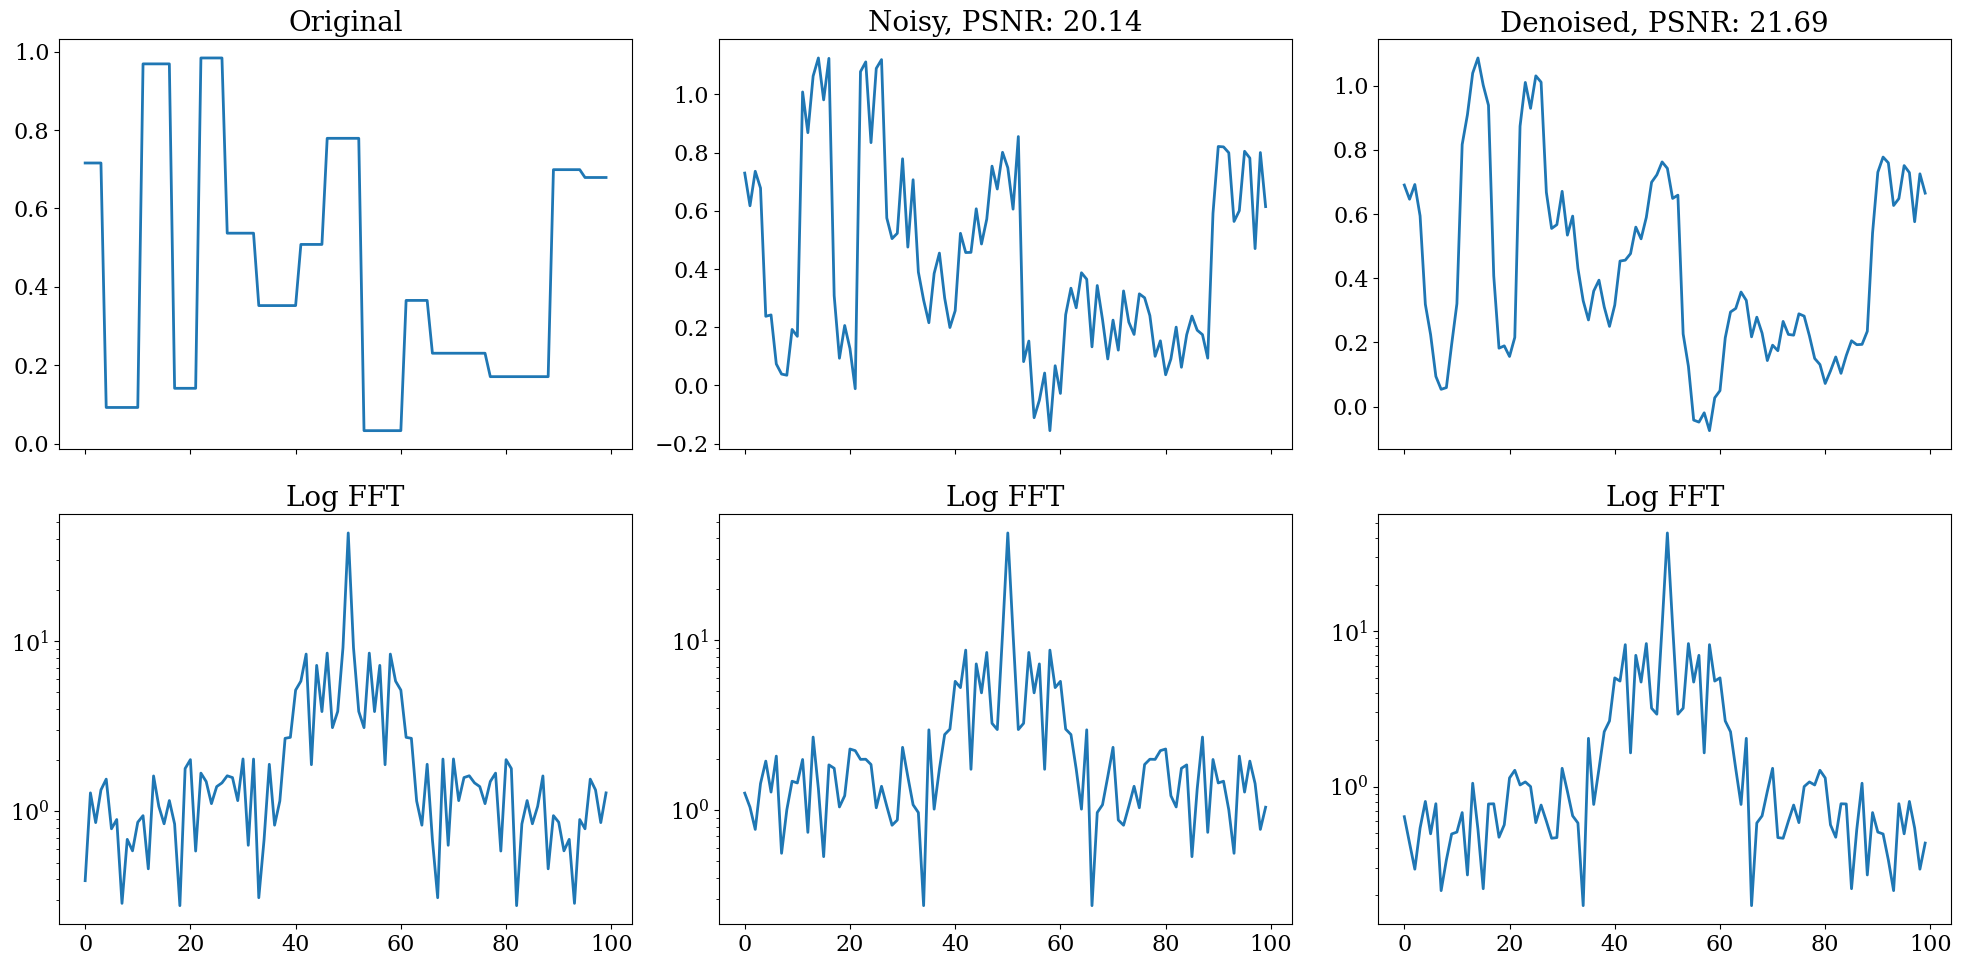

In [ ]:
# import numpy as np
# from PIL import Image
# import torch
# path = '/scratch/kl3141/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))


# image_tensor = torch.tensor(image_np).unsqueeze(0)
# clean_tmpt = image_tensor.unsqueeze(0)

# # for noise_std in noise_std_array:
# #     print('='*50 +'\n\n')
# #     print('Noise Std: ', noise_std)
signal_tensor = test_dataset[2]
signal_np = signal_tensor[0].numpy()

visualize_best_wiener_denoising_1d(signal_tensor, wiener_star, fft_sample=100,noise_scale=noise_scale)

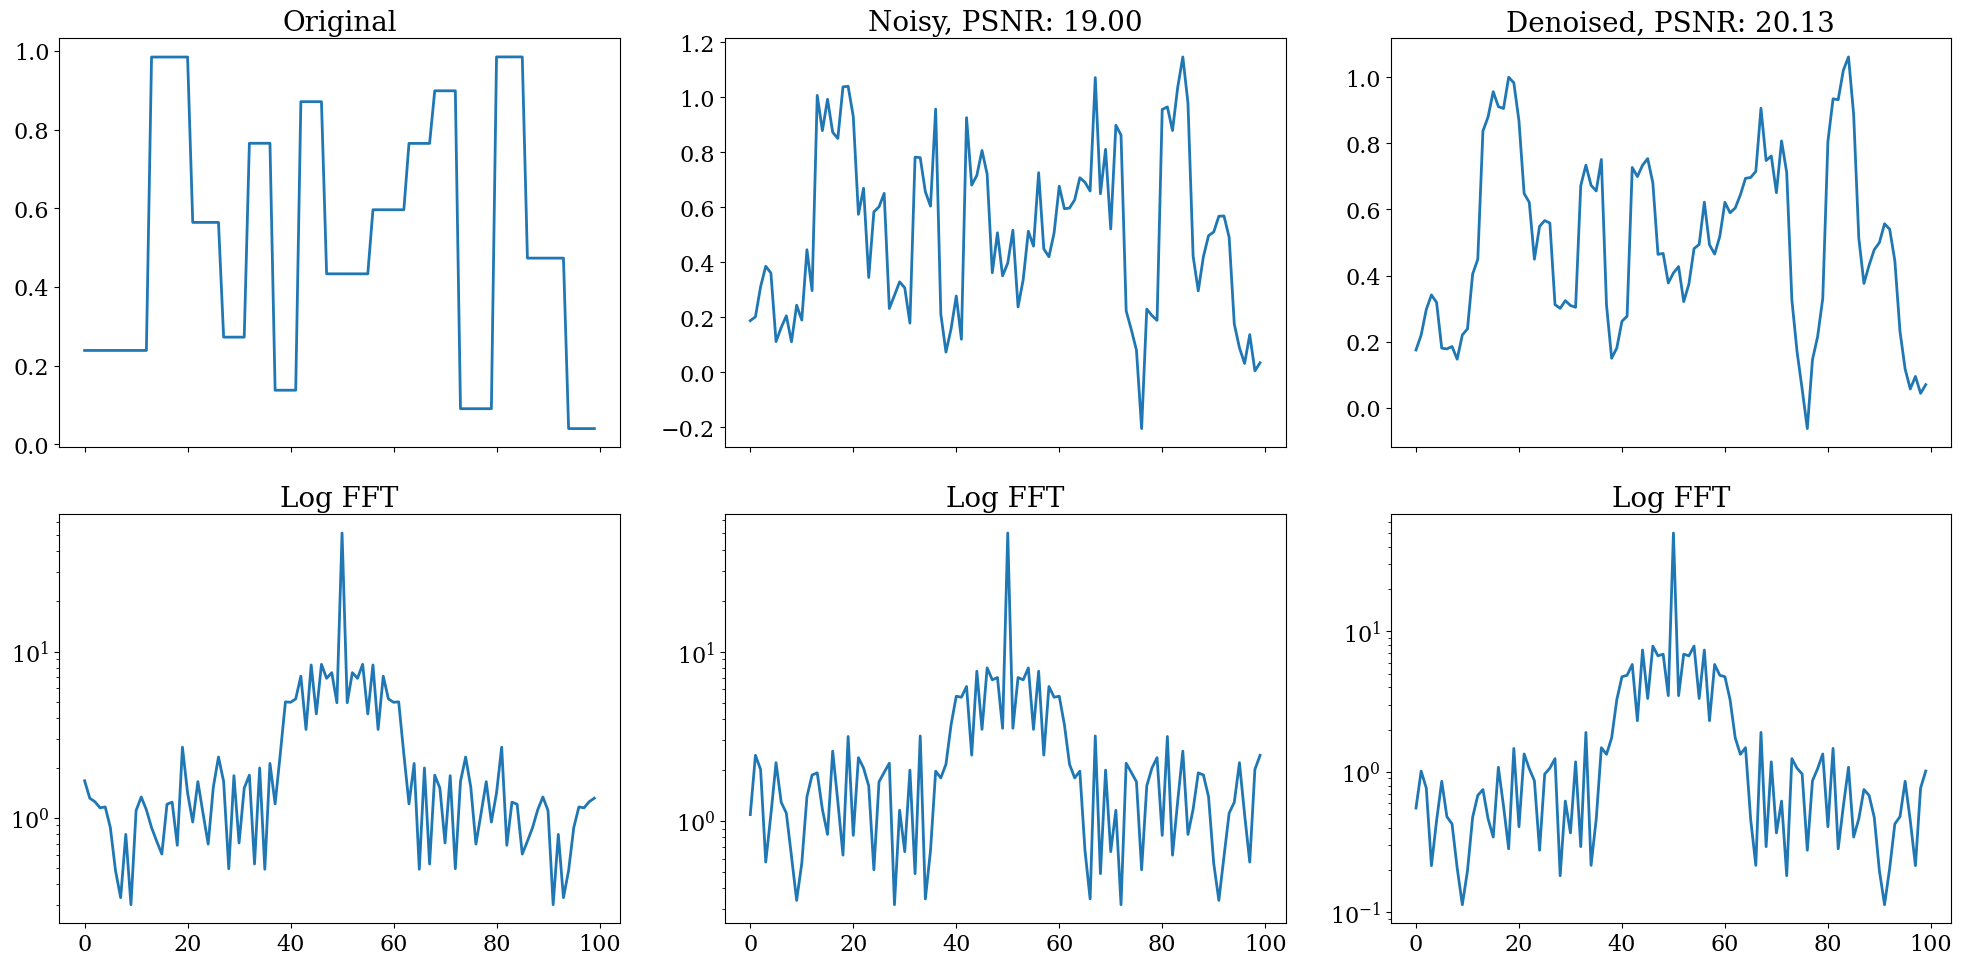

In [ ]:
# import numpy as np
# from PIL import Image
# import torch
# path = '/scratch/kl3141/Denoising_Tutorial/electron-microscopy-denoising/images/clean-images-for-paper/PtNp2-S1-2_2-S3_1_240slc_1024x1024_6nmDefocus.tif'
# image_np = np.array(Image.open(path).resize((256,256)))


# image_tensor = torch.tensor(image_np).unsqueeze(0)
# clean_tmpt = image_tensor.unsqueeze(0)

# # for noise_std in noise_std_array:
# #     print('='*50 +'\n\n')
# #     print('Noise Std: ', noise_std)
signal_tensor = test_dataset[10]
signal_np = signal_tensor[0].numpy()

visualize_best_wiener_denoising_1d(signal_tensor, wiener_star, fft_sample=signal_length,noise_scale=noise_scale)

In [ ]:
len(signal_tensor[0])

100

In [ ]:
len(val_dataset)

100

### Performance of Theoretical Wiener

In [ ]:
# wiener_star_psnr_val_dict = {}
# for noise_std in noise_std_array:
# print('noise std: ', noise_std)
wiener_star_loss, wiener_star_psnr = best_wiener_loss_and_psnr_1d(val_dataset, wiener_star, fft_sample = signal_length,noise_std=noise_std, noise_scale=noise_scale)
print('Loss: ', wiener_star_loss)
print('PSNR: ', wiener_star_psnr)
# wiener_star_psnr_val_dict[noise_std] = wiener_star_psnr
print('='*50 + '\n')

100%|██████████| 100/100 [00:00<00:00, 432.86it/s]

19.994931423940727
Loss:  0.605067652923447
PSNR:  22.26347576573603



# Training with DNN

## ablation on different piecewise constant training recipe

In [ ]:
import matplotlib.pyplot as plt

def plot_side_by_side_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, wiener_star_loss, save_path='side_by_side_losses.pdf', title1='DNN without Batch Normalization', title2='DNN with Batch Normalization', y_max=0.2):


    y_min = 0  # Replace with your desired minimum value
    y_max = y_max  # Replace with your desired maximum value
    # Create a figure with two side-by-side subplots that share the y-axis
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Plotting for the first experiment on the first subplot
    ax1.plot(train_loss, label='Train Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='green')
    ax1.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')
    ax1.set_title(title1, fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax1.set_ylim(y_min, y_max)

    # Plotting for the DNN experiment on the second subplot
    ax2.plot(train_loss_dnn, label='Train Loss', color='blue', linestyle='-.')
    ax2.plot(val_loss_dnn, label='Validation Loss', color='green', linestyle='-.')
    ax2.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')
    ax2.set_title(title2, fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax2.set_ylim(y_min, y_max)

    # Ensure a tight layout and save
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [ ]:
def train_network_on_noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
def train_network_on_fixed_noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001, seed=0, weight_decay=0):

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);
    torch.manual_seed(seed)

    noise_list = []
    for i, data in enumerate(train_loader):

      noise = torch.normal(0, noise_std, size=data.shape)

      # noise = torch.clamp(noise, -1, 1)

      noise_list.append(noise)

    # print(noise_list)


    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + noise_list[i]);

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
# net_nn_large = DnCNN(depth=10)
# train_loss_dnn_large, val_loss_dnn_large = train_network_on_noise(net_nn_large, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 100,
#                        milestone = 50,
#                       lr = 1e-1)

In [ ]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DnCNNskipcon(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True, non_linear=True):
		super(DnCNNskipcon, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias= use_bias
		self.non_linear = non_linear


		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		if self.non_linear:
			out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			if self.non_linear:
				out = F.relu(out)

		out = self.last_layer(out) + x;

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)



In [ ]:
# noise_std =0.05

In [ ]:
train_dataset = PieceWiseConstantDataset(n_data = 4, prob = 0.3, n_signal = signal_length, fix_datapoints = True, min_sep = 20, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = 0.3, min_sep = 20, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:

prob_val = 0.3
min_sep = 5
signal_length = 100
n_sample = 1
train_dataset = PieceWiseConstantDataset(n_data = n_sample, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

### continous noise or not

In [ ]:
val_dataset[0]

tensor([[0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.7152, 0.0567,
         0.0567, 0.0567, 0.0567, 0.0567, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777,
         0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.4777, 0.8701,
         0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701, 0.8701,
         0.8701, 0.8701, 0.8701, 0.4736, 0.4736, 0.4736, 0.4736, 0.4736, 0.7369,
         0.7369, 0.7369, 0.7369, 0.7369, 0.1352, 0.1352, 0.1352, 0.1352, 0.1352,
         0.1352, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223, 0.2223,
         0.2223, 0.2223, 0.9698, 0.9698, 0.9698, 0.9698, 0.9698, 0.9698, 0.3582,
         0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.3582, 0.6343, 0.6343,
         0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343,
         0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343, 0.6343,
         0.6343]])

In [ ]:
test_loader

In [ ]:
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_loader = val_loader
test_dataset = test_loader.dataset

In [ ]:
noise_std =0.1

In [ ]:
net_nn_wo_bn = DnCNN(depth=5, n_channels=256, image_channels=1, use_bnorm=False, kernel_size=5,  use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 10,
                       milestone = 50,
                      lr = 1e-3)


0 train error:  23.138080596923828 val error:  21.1926655960083
1 train error:  7.448116302490234 val error:  6.984004693031311
2 train error:  3.697511672973633 val error:  3.869368370771408
3 train error:  6.544125556945801 val error:  6.222444396018982
4 train error:  1.8819715976715088 val error:  1.9907676112651824
5 train error:  2.118368625640869 val error:  2.006319826245308
6 train error:  4.193283557891846 val error:  3.7353087389469146
7 train error:  4.617329120635986 val error:  4.239156038761139
8 train error:  4.006650924682617 val error:  3.4460092616081237
9 train error:  2.452064275741577 val error:  2.0516831159591673


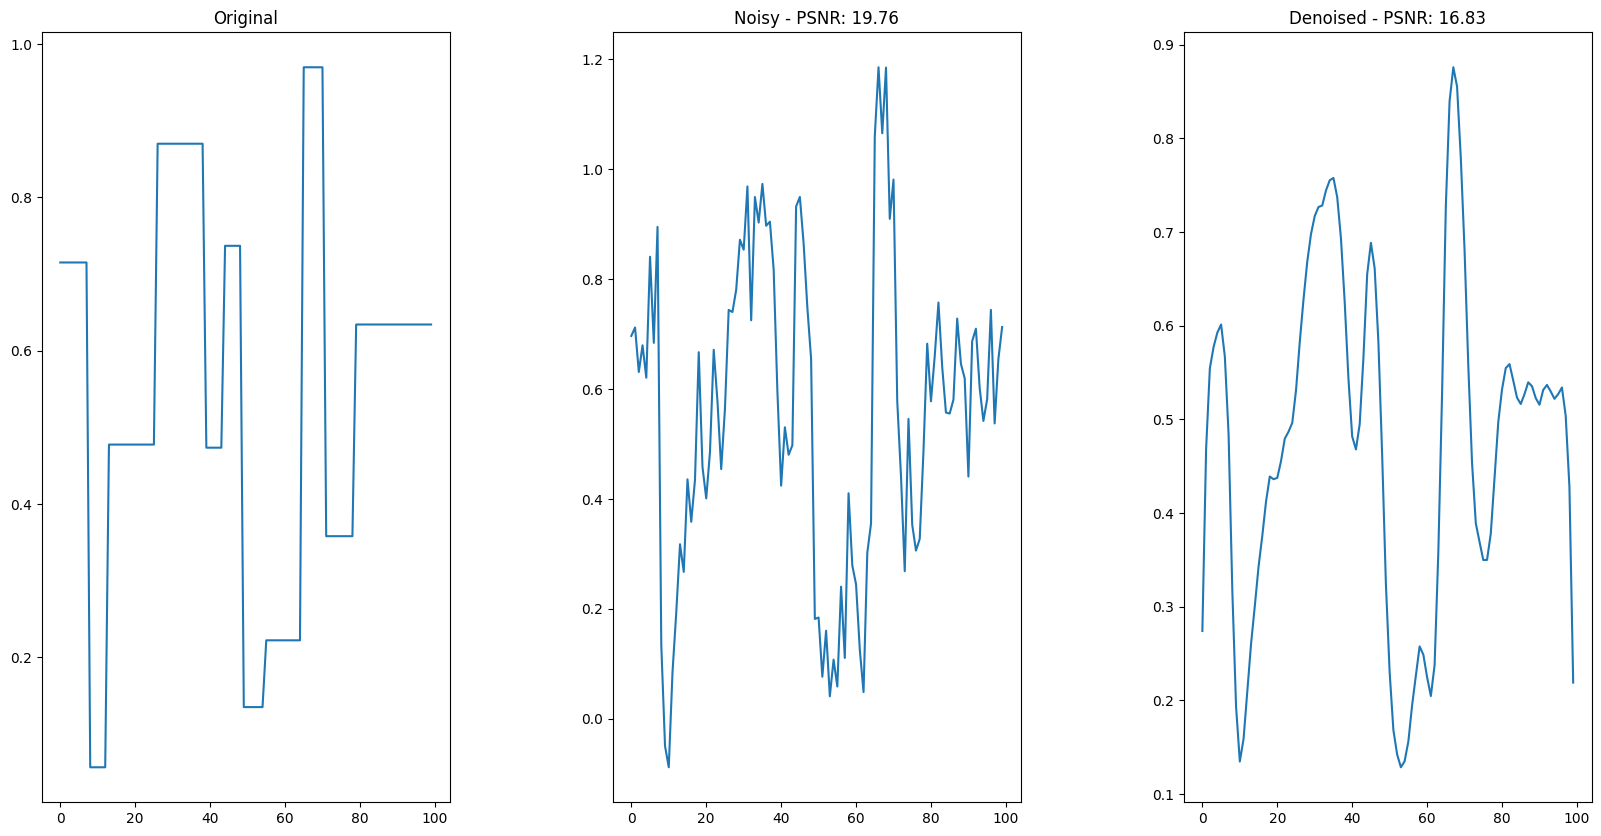

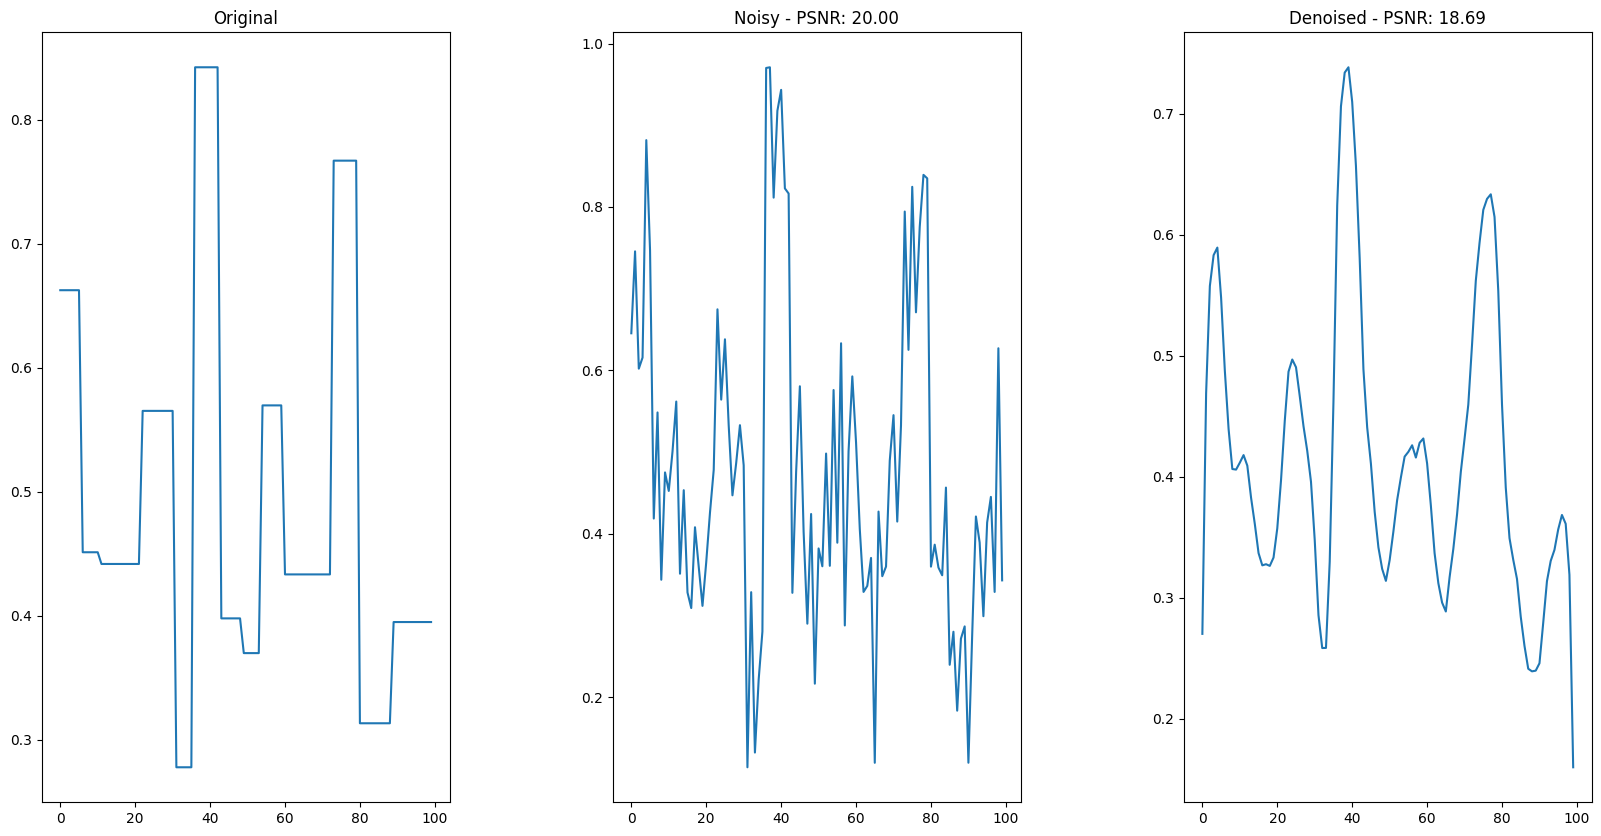

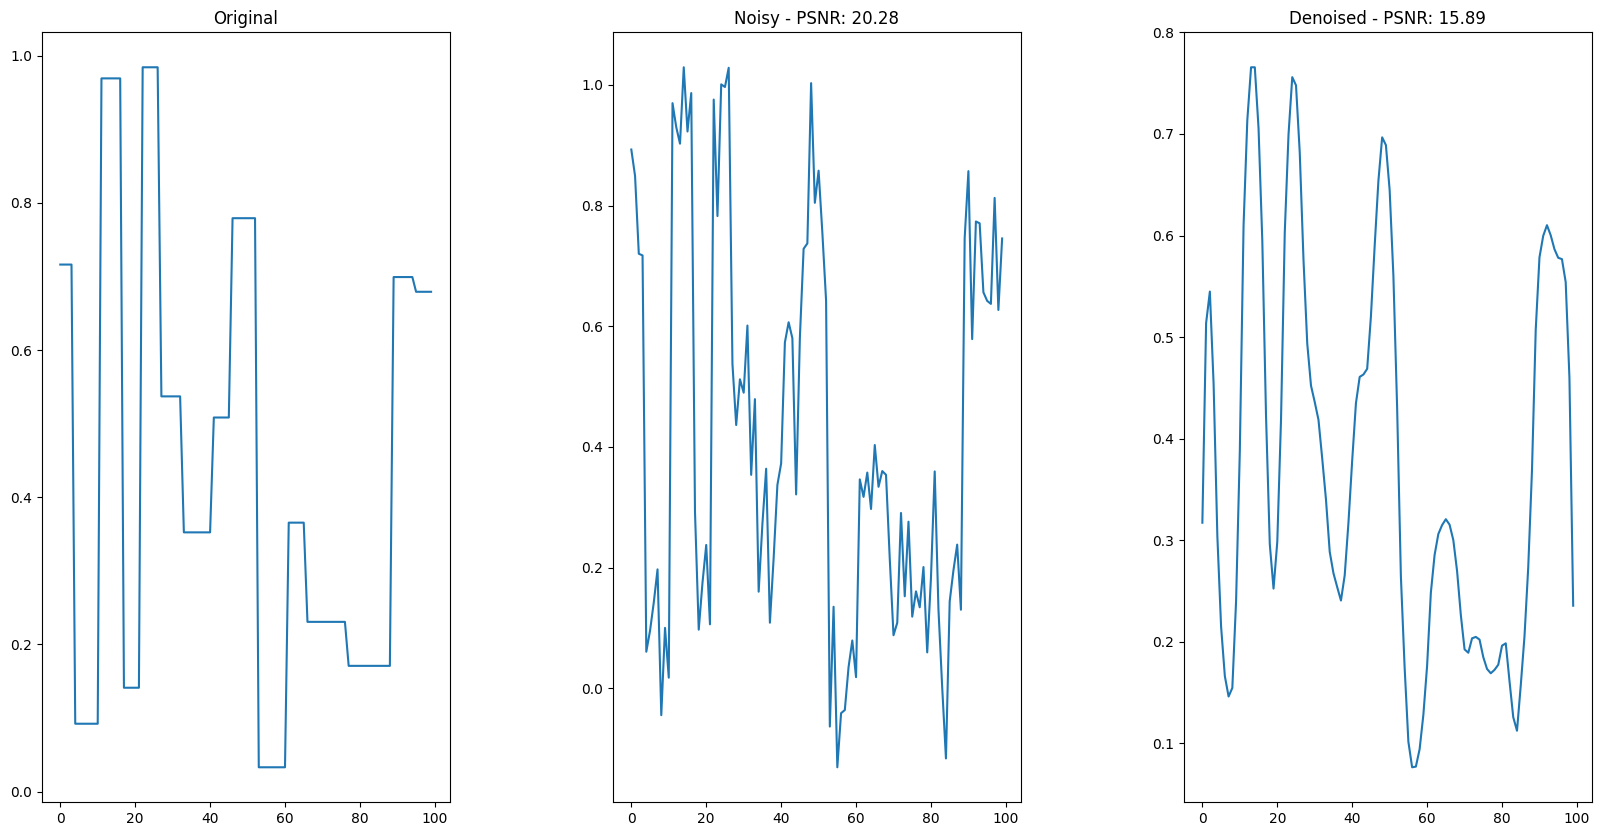

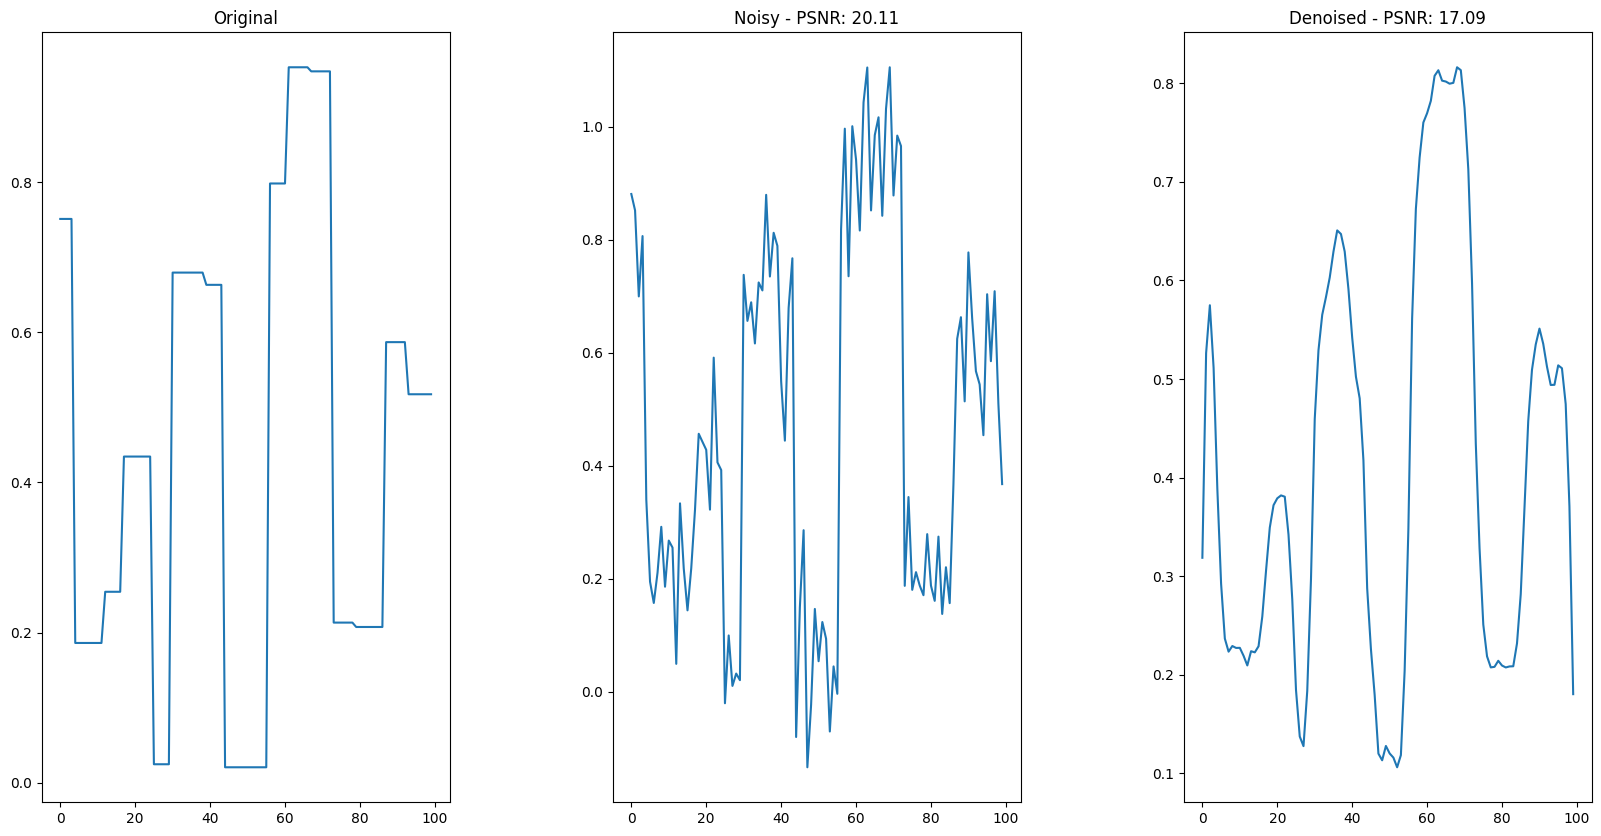

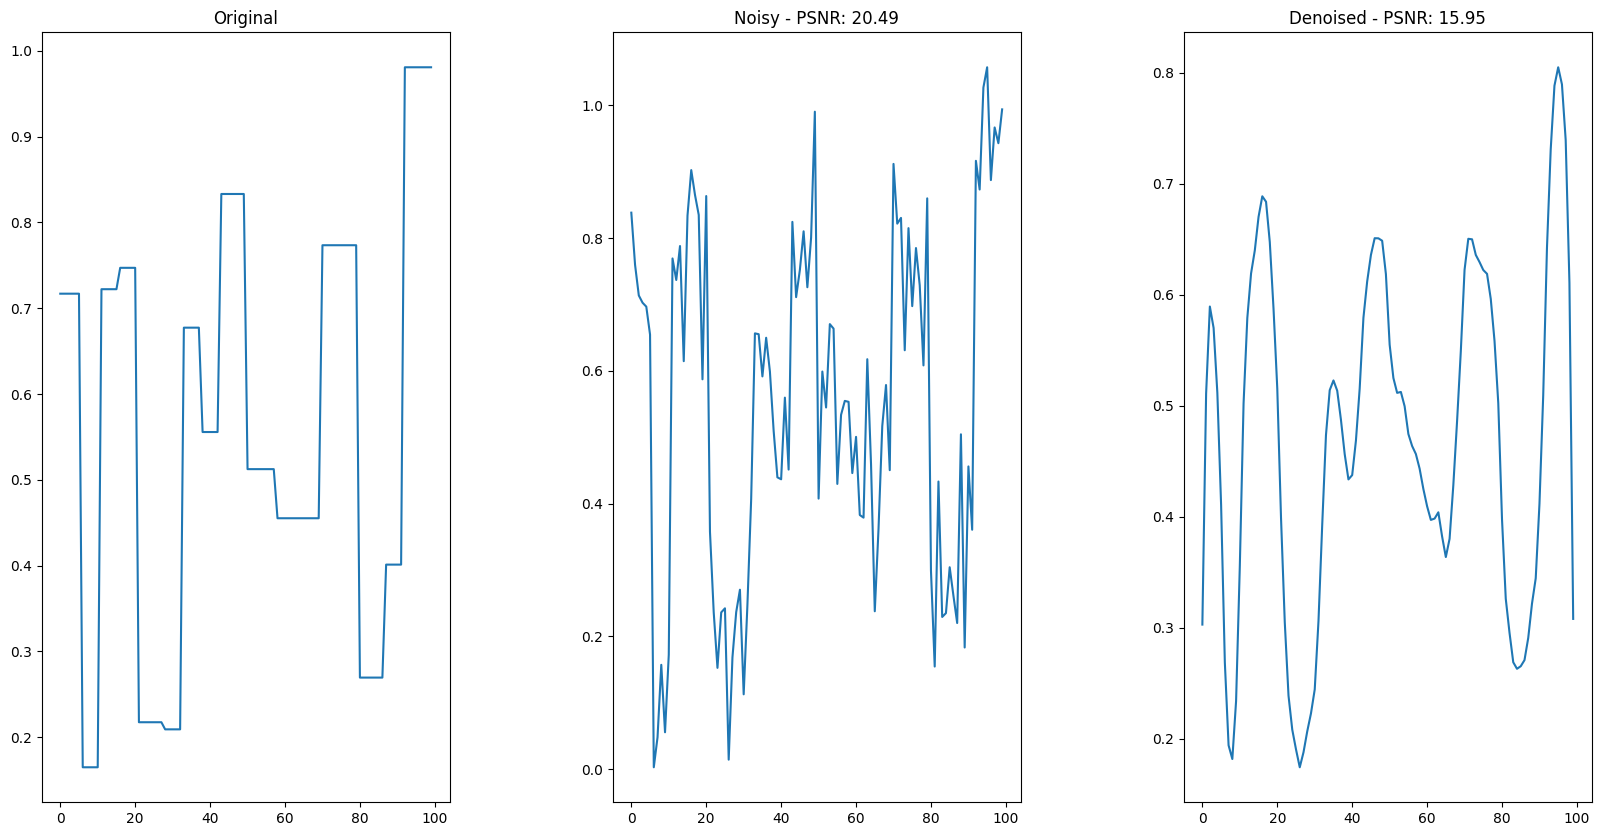

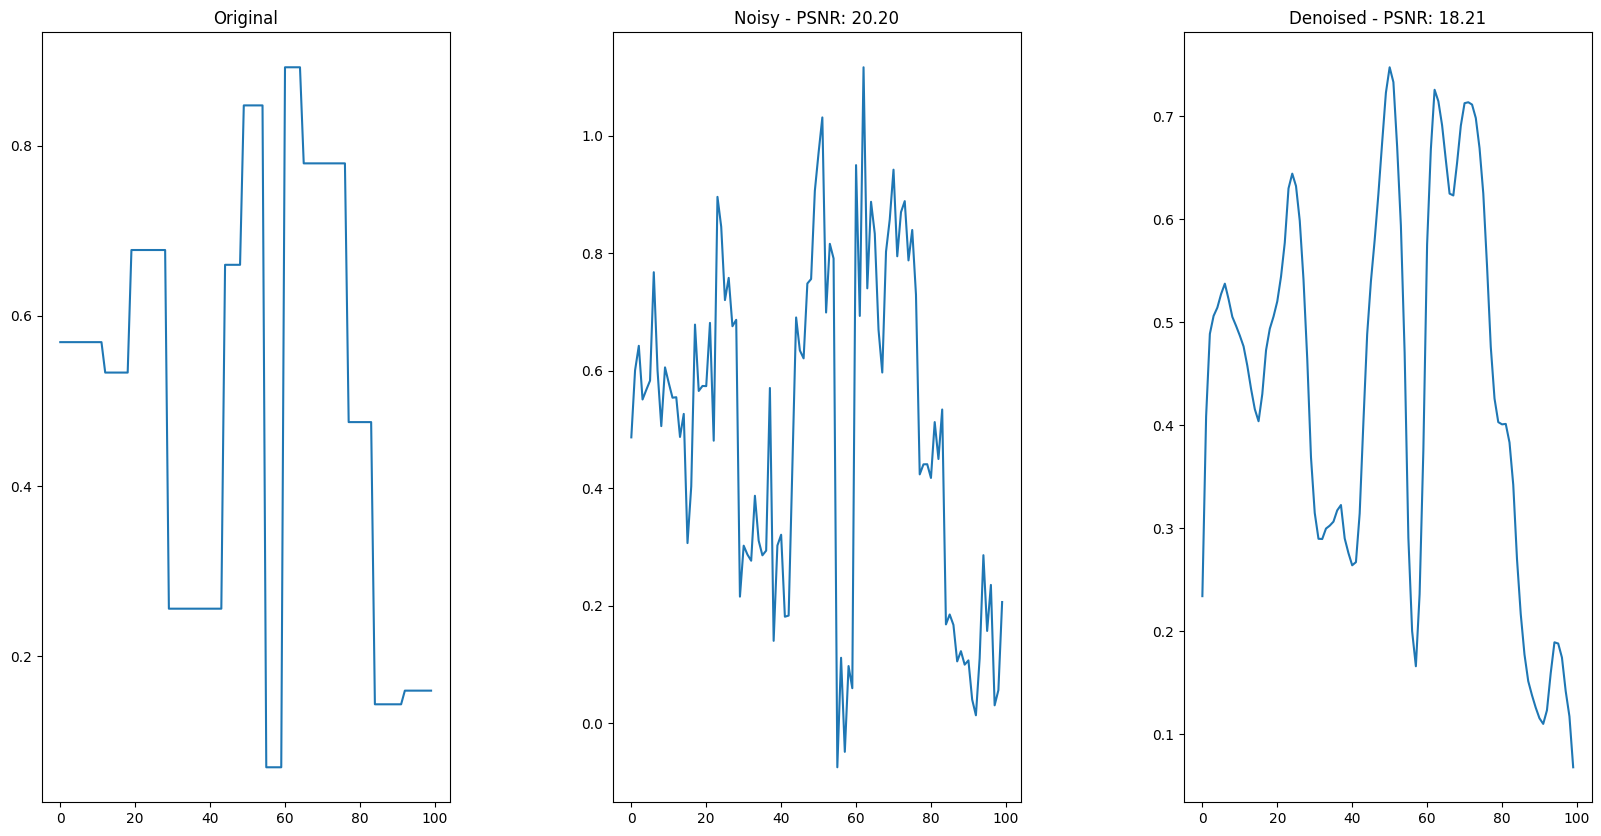

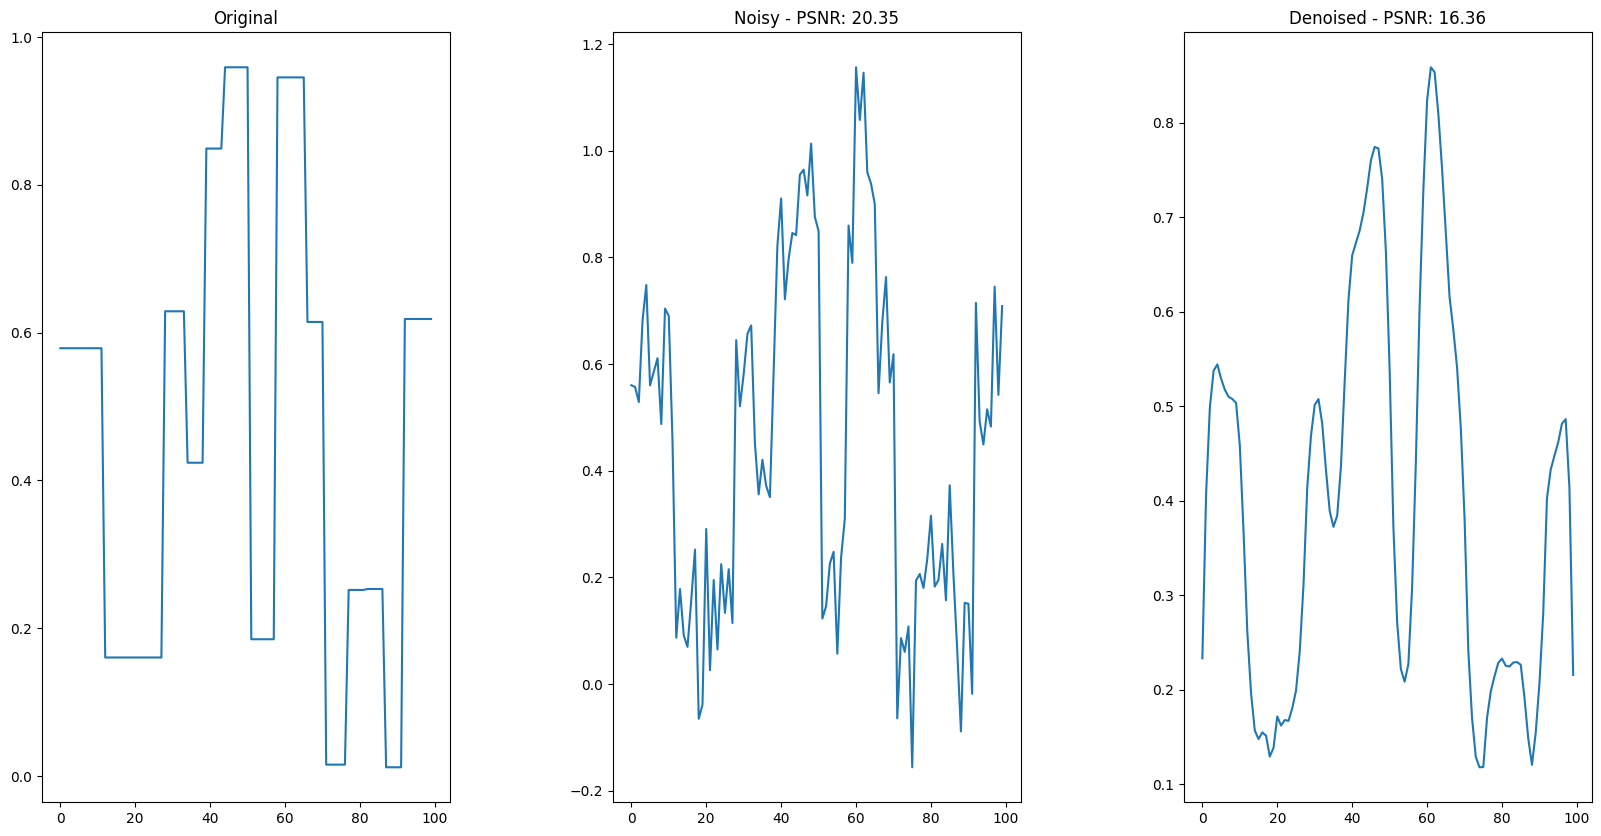

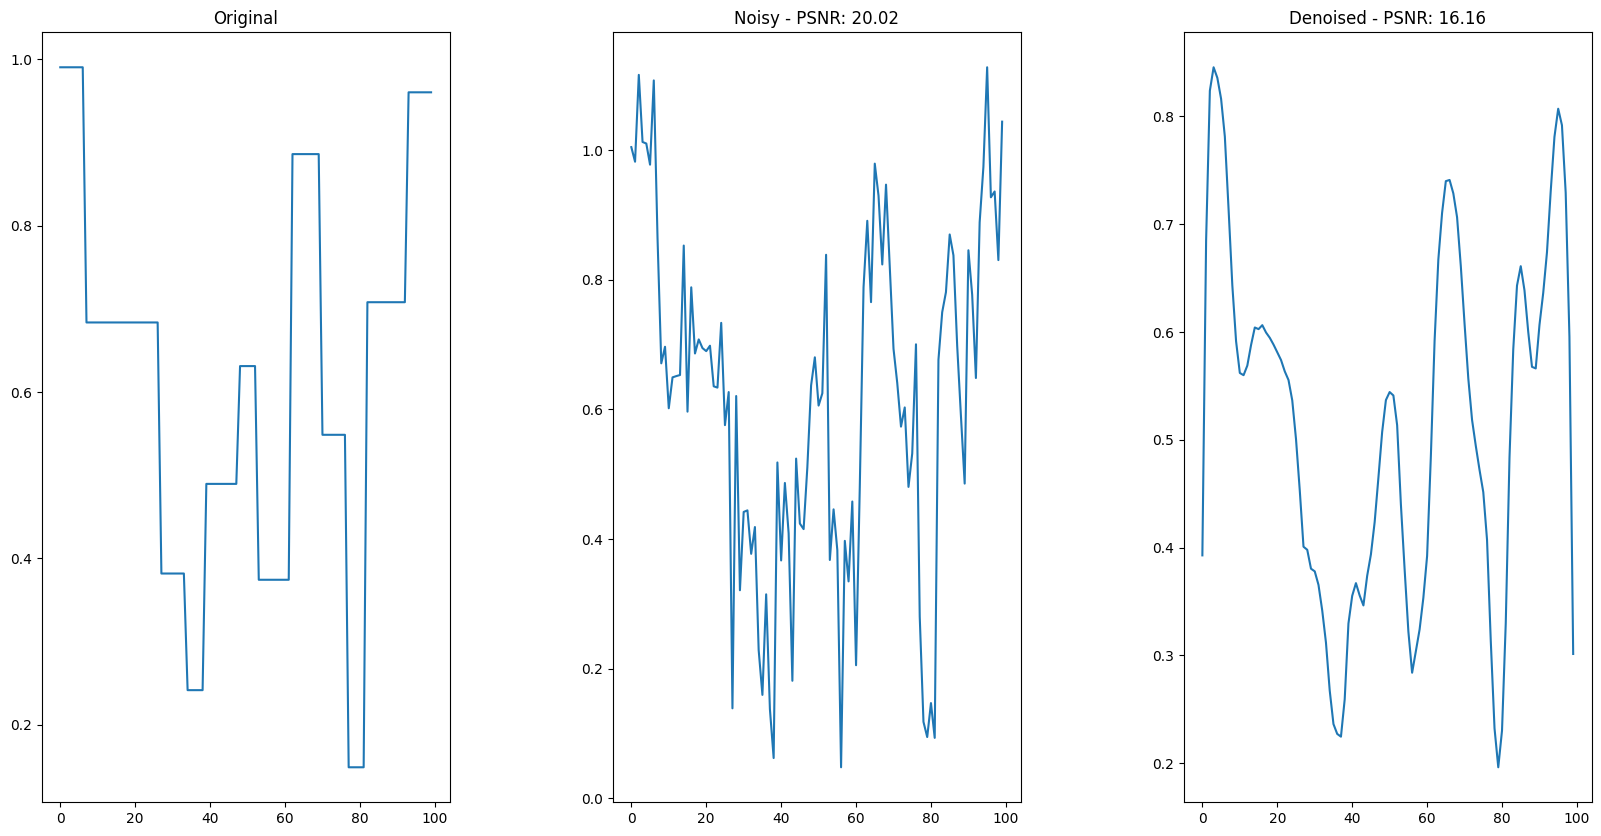

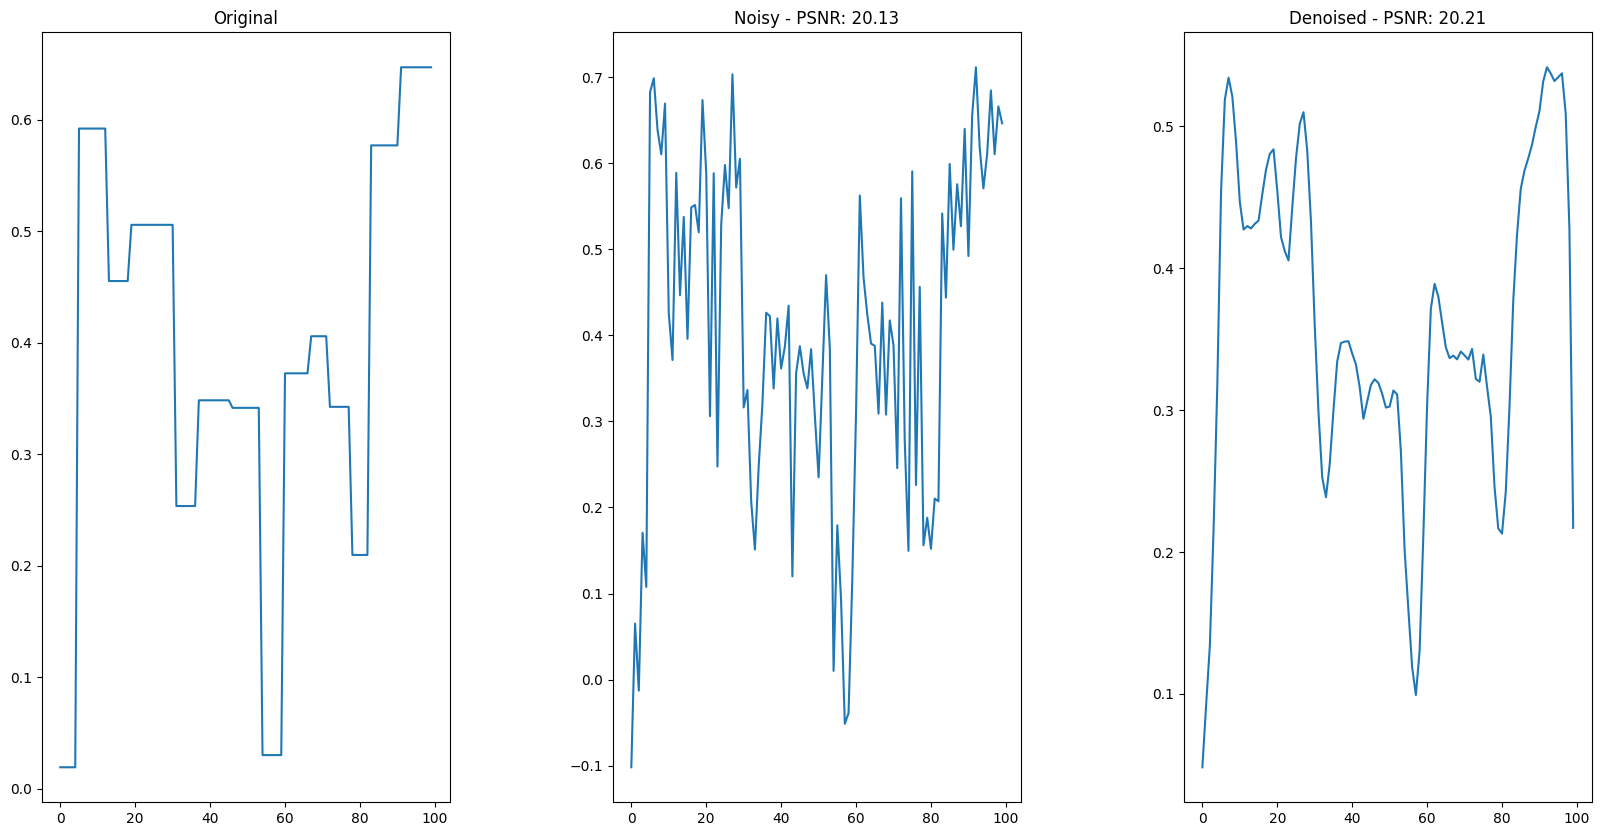

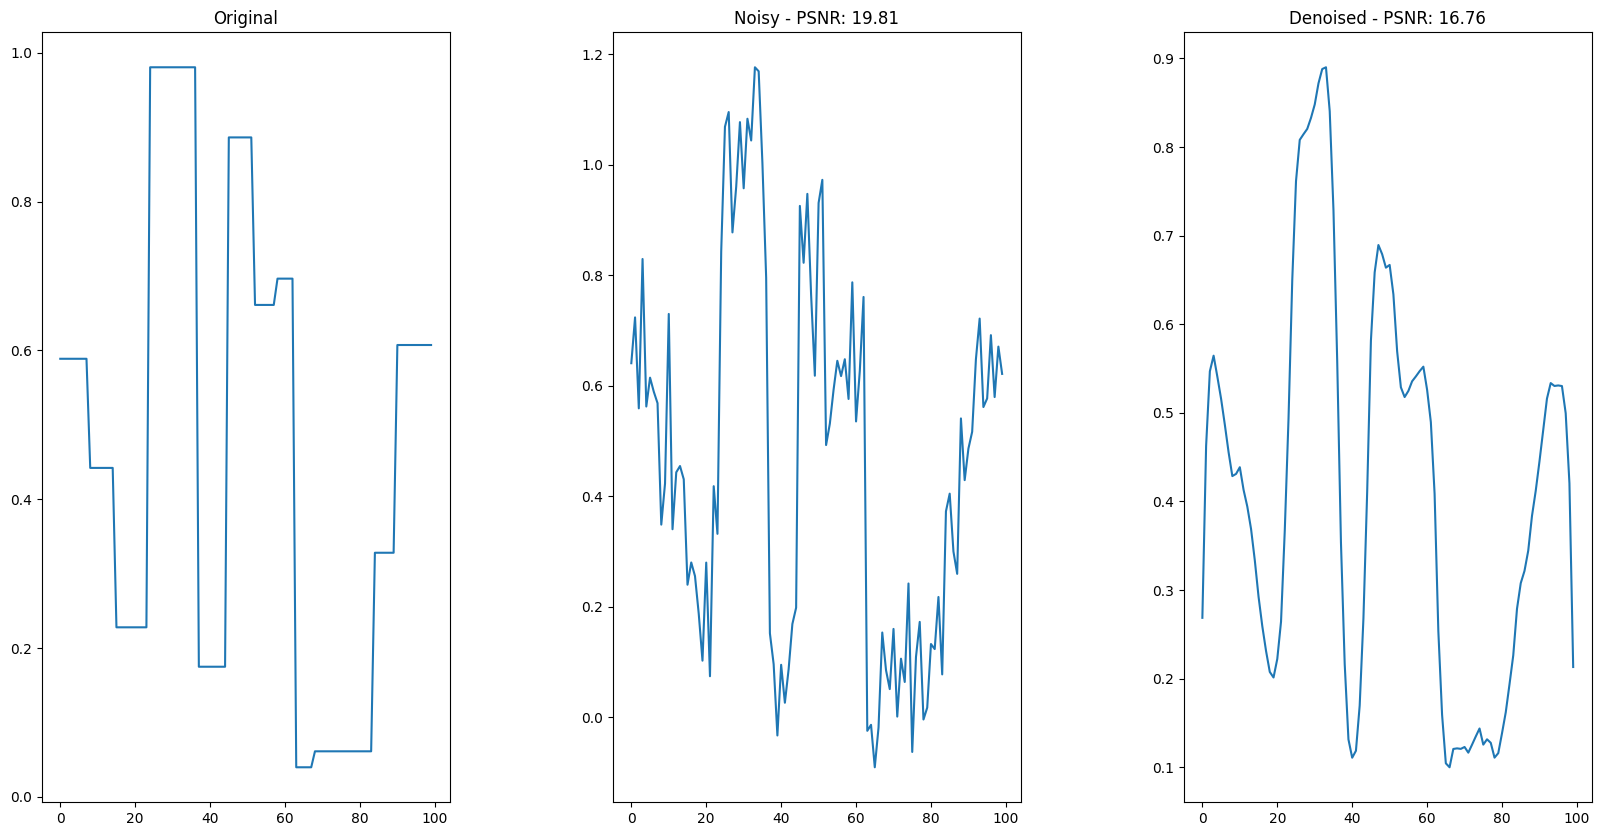

In [ ]:
# noise_std = np.random.choice(noise_std_array)
n_examples = 10
for i in range(n_examples):
    visualize_denoising(val_dataset[i].to(device), net_nn_wo_bn.to(device), noise_std=noise_std, noise_scale=noise_scale, figsize=(20, 10))

In [ ]:
net_nn_wo_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,  use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



0 train error:  9.260969161987305 val error:  8.727437014579772
1 train error:  0.8125882148742676 val error:  1.0280514430999756
2 train error:  0.9413332343101501 val error:  1.0864627981185913
3 train error:  1.1549615859985352 val error:  1.038775573372841
4 train error:  1.229512095451355 val error:  1.0257475650310517
5 train error:  1.4517858028411865 val error:  1.2308674031496047
6 train error:  0.9890181422233582 val error:  0.9941775518655777
7 train error:  0.9097379446029663 val error:  1.0120768439769745
8 train error:  0.9963648319244385 val error:  0.9984943598508835
9 train error:  1.388018012046814 val error:  1.015211165547371


KeyboardInterrupt: ignored

In [ ]:
net_nn_wo_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,  use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_wo_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,  use_bias=False)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_wo_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,  use_bias=False)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_wo_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,  use_bias=False)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_w_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3,  use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_w_bn, val_loss_dnn_w_bn = train_network_on_fixed_noise(net_nn_w_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_wo_bn = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,  use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_fixed_noise(net_nn_wo_bn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_fixed_noise = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_fixed_noise, val_loss_dnn_fixed_noise = train_network_on_fixed_noise(net_nn_fixed_noise, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_continous_noise = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3,use_bias=True)
train_loss_dnn_continous_noise, val_loss_dnn_continous_noise = train_network_on_noise(net_nn_continous_noise, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)

# train_loss_dnn_w_bn, val_loss_dnn_w_bn = train_network_on_fixed_noise(net_nn_w_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 100,
#                        milestone = 50,
#                       lr = 1e-2)



In [ ]:
# net_nn_wo_bn = DnCNN(depth=10, n_channels=16, image_channels=1, use_bnorm=False, kernel_size=3)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 100,
#                        milestone = 50,
#                       lr = 1e-1)


In [ ]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def plot_combined_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, wiener_star_loss, save_path='combined_losses.pdf', title1='DNN without Batch Normalization', title2='DNN with Batch Normalization', title='Combined Losses', y_max=0.2, smooth=False, xlim=100, figsize=(8,8), tick_font_size=14):
    y_min = 0
    y_max = y_max
    fig, ax = plt.subplots(figsize=figsize)

    if smooth:
        # Apply moving average if smoothing is desired
        train_loss = moving_average(train_loss)
        val_loss = moving_average(val_loss)
        train_loss_dnn = moving_average(train_loss_dnn)
        val_loss_dnn = moving_average(val_loss_dnn)

    # Plotting for the first experiment
    ax.plot(train_loss, label=title1 + ': Train Loss', color='blue')
    ax.plot(val_loss, label=title1 + ': Validation Loss', color='blue', linestyle='-.')
    # ax.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')

    # Plotting for the DNN experiment
    ax.plot(train_loss_dnn, label=title2 + ': Train Loss', color='green')
    ax.plot(val_loss_dnn, label=title2 + ': Validation Loss', color='green', linestyle='-.')

    # ax.set_title(title, fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.legend(fontsize=16)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2)

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, xlim)

    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)


    plt.tight_layout()
    save_path = title1 + title2 + '.png'
    plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
plot_combined_losses(train_loss_dnn_fixed_noise*signal_length, val_loss_dnn_fixed_noise, train_loss_dnn_continous_noise*signal_length, val_loss_dnn_continous_noise, wiener_star_loss, title1='Fixed noise', title2='Continuous noise', y_max=2, smooth=False, xlim=100, figsize=(7,7))

### skip connection

In [ ]:

prob_val = 0.3
min_sep = 5
signal_length = 100
n_sample = 10
train_dataset = PieceWiseConstantDataset(n_data = n_sample, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
net_nn_w_skipcon = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_w_skipcon, val_loss_dnn_w_skipcon = train_network_on_fixed_noise(net_nn_w_skipcon, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_wo_skipcon = DnCNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_skipcon, val_loss_dnn_wo_skipcon = train_network_on_fixed_noise(net_nn_wo_skipcon, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_validation_losses_seaborn(val_loss, val_loss_dnn, title1='DNN without Batch Normalization',
                                   title2='DNN with Batch Normalization', title='Validation Losses Comparison',
                                   y_max=0.2, smooth=False, xlim=100, figsize=(8,8), tick_font_size=14, ylabel='MSE',
                                  legend_font_size=16, append=''):

    # Apply moving average if smoothing is desired
    if smooth:
        val_loss = moving_average(val_loss)
        val_loss_dnn = moving_average(val_loss_dnn)

    # Create a DataFrame for Seaborn plotting
    epochs = range(1, len(val_loss) + 1)
    df = pd.DataFrame({
        'Epoch': np.concatenate((epochs, epochs)),
        'Loss': np.concatenate((val_loss, val_loss_dnn)),
        'Model': np.concatenate((([title1] * len(val_loss)), ([title2] * len(val_loss_dnn))))
    })

    # Plotting using Seaborn
    plt.figure(figsize=figsize)
    sns.lineplot(data=df, x='Epoch', y='Loss', hue='Model', palette=['blue', 'red'], linewidth=2.5)

#     plt.title(title)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.ylim(0, y_max)
    plt.xlim(0, xlim)
    plt.tick_params(axis='both', which='major', labelsize=tick_font_size)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.grid(False)
    plt.legend(fontsize=legend_font_size)
    plt.tight_layout()

    save_path = append + ylabel + title1 + '_' + title2 + 'piecewiseconstant_validation.png'
    plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
plot_validation_losses_seaborn(  val_loss_dnn_w_skipcon, val_loss_dnn_wo_skipcon, title1='Skip connection', title2='Without skip connection', y_max=40, smooth=False, xlim=100, figsize=(6,6))

In [ ]:
val_loss_dnn_w_skipcon

In [ ]:
plot_combined_losses(train_loss_dnn_w_skipcon*signal_length, val_loss_dnn_w_skipcon, train_loss_dnn_wo_skipcon*signal_length, val_loss_dnn_wo_skipcon, wiener_star_loss, title1='Skip connection', title2='Without skip connection', y_max=10, smooth=False)

In [ ]:

prob_val = 0.3
min_sep = 5
signal_length = 100
n_sample = 500
train_dataset = PieceWiseConstantDataset(n_data = n_sample, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
net_nn_w_skipcon_large = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_w_skipcon_large, val_loss_dnn_w_skipcon_large = train_network_on_fixed_noise(net_nn_w_skipcon_large, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_wo_skipcon_large = DnCNN(depth=10, n_channels=16, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wo_skipcon_large, val_loss_dnn_wo_skipcon_large = train_network_on_fixed_noise(net_nn_wo_skipcon_large, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Colors and fine-tuning sets as specified
category_colors = {
    'With Skip Connection': 'red',
    'Without Skip Connection': 'blue'
}

ft_sets = {
    'Small': [('With Skip Connection', 20.788661925792694150000), ('Without Skip Connection', 3.0075262880325315)],
    'Large': [('With Skip Connection', 0.22647472001612187), ('Without Skip Connection', 0.24923587411642076)],
}

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))

# Adjust the bar width and offset
bar_width = 0.2
offset = bar_width * len(category_colors)

# Track labels for the legend
legend_labels = {}

# Plot each Fine-Tuning Set
for i, (ft_set, data_tuples) in enumerate(ft_sets.items()):
    bottom = 0
    for j, (data_type, size) in enumerate(data_tuples):
        position = i - offset / 2 + j * bar_width
        ax.bar(position, size, width=bar_width, color=category_colors[data_type], label=data_type if data_type not in legend_labels else "")
        legend_labels[data_type] = category_colors[data_type]

# Adjust the axes and labels
ax.set_xticks(np.arange(len(ft_sets)) - offset / 2 + bar_width * (len(category_colors) - 1) / 2)
ax.set_xticklabels(ft_sets.keys())
ax.set_ylabel('MSE')
ax.set_title('Size of the training set')

# Add the legend
# ax.legend()
# Adjust the plot area and set the legend outside
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Resize plot to make space for legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Colors and fine-tuning sets as specified
category_colors = {
    'With Skip Connection': 'red',
    'Without Skip Connection': 'blue'
}

ft_sets = {
    'Small': [('With Skip Connection', 20.788661925792694150000), ('Without Skip Connection', 3.0075262880325315)],
    'Large': [('With Skip Connection', 0.22647472001612187), ('Without Skip Connection', 0.24923587411642076)],
}

# Further adjustments based on the new requirements:
# - Make bars much narrower
# - Place a shared legend at the bottom of the plots

# Adjust plot size
fig, axs = plt.subplots(1, 2, figsize=(8, 6))  # Width remains decreased

# Adjust the bar width to be much narrower
bar_width = 0.1

# Increase font size
plt.rcParams.update({'font.size': 14})

legend_labels = {}

# Plot each Fine-Tuning Set
for ax, (ft_set, data_tuples) in zip(axs, ft_sets.items()):
    for j, (data_type, size) in enumerate(data_tuples):
        position = j * bar_width
        ax.bar(position, size, width=bar_width, color=category_colors[data_type], label=data_type if data_type not in legend_labels else "")
        legend_labels[data_type] = category_colors[data_type]

    # Adjust the axes and labels
    ax.set_xticks(np.arange(len(data_tuples)) * bar_width)
    ax.set_xticklabels([])
    ax.set_ylabel('MSE')
    ax.set_title(f'{ft_set}')

# Adjust subplot layout
plt.tight_layout()

# Add a shared legend at the bottom of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.05))
plt.savefig("training_set_comparison_plot.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
plot_combined_losses(train_loss_dnn_w_skipcon*signal_length, val_loss_dnn_w_skipcon, train_loss_dnn_wo_skipcon*signal_length, val_loss_dnn_wo_skipcon, wiener_star_loss, title1='Skip connection', title2='Without skip connection', y_max=1, smooth=False)

In [ ]:
plot_validation_losses_seaborn(  val_loss_dnn_w_skipcon_large, val_loss_dnn_wo_skipcon_large, title1='Skip connection', title2='Without skip connection', y_max=1, smooth=False, xlim=100, figsize=(6,6),append='Large')

In [ ]:
params = { 'val_loss_dnn_w_skipcon':val_loss_dnn_w_skipcon,
          'val_loss_dnn_wo_skipcon':val_loss_dnn_wo_skipcon,
          'val_loss_dnn_w_skipcon_large':val_loss_dnn_w_skipcon_large,
          'val_loss_dnn_wo_skipcon_large':val_loss_dnn_wo_skipcon_large,
          }


filename = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/figure_for_paper/piecewise_skipconnect_stats.pkl'
with open(filename, 'wb') as file:
    pickle.dump(params, file)


### number of layers

In [ ]:

prob_val = 0.3
min_sep = 5
signal_length = 100
n_sample = 500
train_dataset = PieceWiseConstantDataset(n_data = n_sample, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
net_nn_linear = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True, non_linear=False)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_linear, val_loss_dnn_linear = train_network_on_fixed_noise(net_nn_linear, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_overfitting = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_overfitting, val_loss_dnn_overfitting = train_network_on_fixed_noise(net_nn_overfitting, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_2layer= DnCNNskipcon(depth=2, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_2layer, val_loss_dnn_2layer = train_network_on_fixed_noise(net_nn_2layer, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_5layer= DnCNNskipcon(depth=5, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_5layer, val_loss_dnn_5layer = train_network_on_fixed_noise(net_nn_5layer, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



In [ ]:
net_nn_15layer= DnCNNskipcon(depth=15, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_15layer, val_loss_dnn_15layer = train_network_on_fixed_noise(net_nn_15layer, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



0 train error:  1.00243696975708 val error:  0.9976916640996933
1 train error:  1.0118664932250976 val error:  0.9948268139362335
2 train error:  0.9159202690124512 val error:  0.9149398040771485
3 train error:  0.7195528469085694 val error:  0.7127649015188218
4 train error:  0.4755906620025635 val error:  0.46457135915756226
5 train error:  0.39849611568450927 val error:  0.3979770714044571
6 train error:  0.36624281978607176 val error:  0.3542924708127975
7 train error:  0.34371353912353514 val error:  0.34573850452899935
8 train error:  0.33217430114746094 val error:  0.3158260953426361
9 train error:  0.34196305561065676 val error:  0.34154282793402674
10 train error:  0.3219262752532959 val error:  0.3147881419956684
11 train error:  0.3075480327606201 val error:  0.29908636927604676
12 train error:  0.3267489242553711 val error:  0.32352435231208804
13 train error:  0.29519890403747556 val error:  0.30397668316960336
14 train error:  0.27470457458496095 val error:  0.28242290437

In [ ]:
net_nn_20layer= DnCNNskipcon(depth=20, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_20layer, val_loss_dnn_20layer = train_network_on_fixed_noise(net_nn_20layer, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



0 train error:  1.0039002571105957 val error:  0.9990409332513809
1 train error:  1.0142768898010255 val error:  0.997414510846138
2 train error:  0.9974809494018555 val error:  0.9862129372358323
3 train error:  1.0042244911193847 val error:  0.9918006199598313
4 train error:  1.0066818923950196 val error:  1.000164840221405
5 train error:  0.9985971984863281 val error:  1.0163737744092942
6 train error:  0.9942933082580566 val error:  1.000133872628212
7 train error:  0.9921327095031738 val error:  1.0076570057868957
8 train error:  0.9962624053955078 val error:  0.9596343272924424
9 train error:  0.9954686050415039 val error:  0.9823054736852646
10 train error:  1.0065743446350097 val error:  0.9636387449502944
11 train error:  0.9999019737243653 val error:  0.9875913232564926
12 train error:  0.9951649017333984 val error:  0.9957554602622986
13 train error:  1.0005907592773438 val error:  0.9990513074398041
14 train error:  0.988973503112793 val error:  1.0148733973503112
15 train 

[0.6122653645887061, 0.3367959952354431, 0.24160549022257327, 0.2328472763299942, 0.23142494209110737]


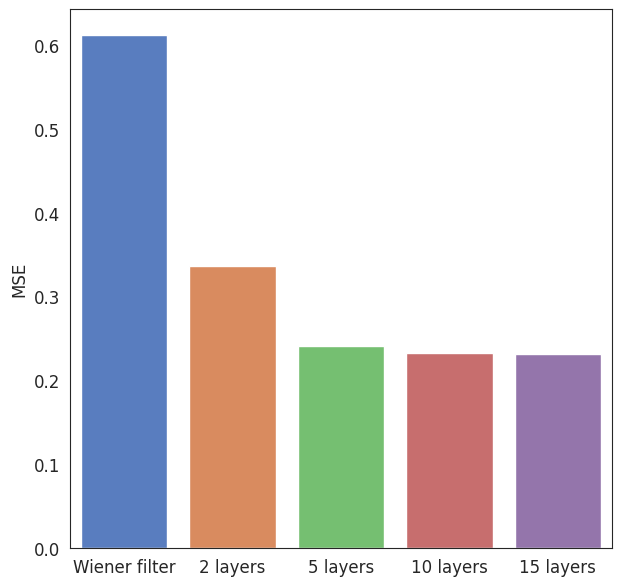

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
epoch_idx = 80
val_losses_list = [0.6122653645887061, val_loss_dnn_2layer[epoch_idx], val_loss_dnn_5layer[epoch_idx], val_loss_dnn_overfitting[epoch_idx], val_loss_dnn_15layer[epoch_idx]]
print(val_losses_list)
model_names = ['Wiener filter', '2 layers', '5 layers', '10 layers', '15 layers']

# Create a DataFrame for the data
data = {
    'Model': model_names,
    'Validation Loss': val_losses_list
}

df = pd.DataFrame(data)

# Set Seaborn style to white (no grid)
sns.set_style("white")

# Create the plot
plt.figure(figsize=(7,7))
sns.barplot(x='Model', y='Validation Loss', data=df, palette='muted')

# Set plot title and labels
plt.xlabel('')
plt.ylabel('MSE')

# Increase font size for better visibility
plt.rcParams.update({'font.size': 12})

plt.savefig("num_layers_training_set_comparison_plot.pdf", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
params = {          'Wiener filter': 0.6122653645887061, '2 layers':val_loss_dnn_2layer[epoch_idx],
                    '5 layers': val_loss_dnn_5layer[epoch_idx],
                    '10 layers':val_loss_dnn_overfitting[epoch_idx],
                    '15 layers':val_loss_dnn_15layer[epoch_idx]
          }


filename = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial/figure_for_paper/piecewise_layers_stats.pkl'
with open(filename, 'wb') as file:
    pickle.dump(params, file)


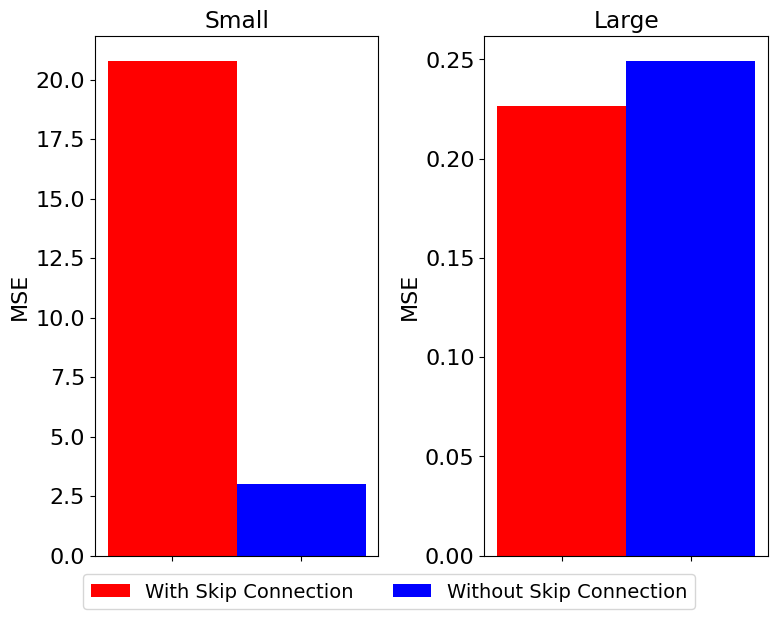

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Colors and fine-tuning sets as specified
category_colors = {
    'With Skip Connection': 'red',
    'Without Skip Connection': 'blue'
}


# Further adjustments based on the new requirements:
# - Make bars much narrower
# - Place a shared legend at the bottom of the plots

# Adjust plot size
fig, axs = plt.subplots(1, 2, figsize=(8, 6))  # Width remains decreased

# Adjust the bar width to be much narrower
bar_width = 0.1

# Increase font size
plt.rcParams.update({'font.size': 14})

legend_labels = {}

# Plot each Fine-Tuning Set
for ax, (ft_set, data_tuples) in zip(axs, ft_sets.items()):
    for j, (data_type, size) in enumerate(data_tuples):
        position = j * bar_width
        ax.bar(position, size, width=bar_width, color=category_colors[data_type], label=data_type if data_type not in legend_labels else "")
        legend_labels[data_type] = category_colors[data_type]

    # Adjust the axes and labels
    ax.set_xticks(np.arange(len(data_tuples)) * bar_width)
    ax.set_xticklabels([])
    ax.set_ylabel('MSE')
    ax.set_title(f'{ft_set}')

# Adjust subplot layout
plt.tight_layout()

# Add a shared legend at the bottom of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.05))
plt.savefig("training_set_comparison_plot.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_validation_losses_seaborn(val_losses, model_names, wiener_star_loss, title='Validation Losses Comparison',
                                   y_max=0.2, smooth=False, xlim=100, figsize=(5,5), tick_font_size=14, ylabel='MSE',
                                   legend_font_size=16, append=''):

    # Check if the lengths of val_losses and model_names are equal
    if len(val_losses) != len(model_names):
        raise ValueError("The lengths of val_losses and model_names must be the same.")

    # Apply moving average if smoothing is desired and prepare data for DataFrame
    epochs_list = []
    losses_list = []
    models_list = []

    for i, (val_loss, model_name) in enumerate(zip(val_losses, model_names)):
        if smooth:
            val_loss = moving_average(val_loss)

        epochs = range(1, len(val_loss) + 1)
        epochs_list.extend(epochs)
        losses_list.extend(val_loss)
        models_list.extend([model_name] * len(val_loss))

    # Create a DataFrame for Seaborn plotting
    df = pd.DataFrame({
        'Epoch': epochs_list,
        'Loss': losses_list,
        'Model': models_list
    })

    # Plotting using Seaborn
    plt.figure(figsize=figsize)
    lineplot = sns.lineplot(data=df, x='Epoch', y='Loss', hue='Model', palette=sns.color_palette("hsv", len(model_names)), linewidth=2.5)

    # Add horizontal line for wiener_star_loss in orange color
    wiener_line = plt.axhline(y=wiener_star_loss, color='orange', linestyle='--', linewidth=2)

    # Modify the legend to include wiener_star_loss
    handles, labels = lineplot.get_legend_handles_labels()
    handles.append(wiener_line)
    labels.append(f'Wiener Loss')
    plt.legend(handles=handles, labels=labels, fontsize=legend_font_size)

    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.ylim(0, y_max)
    plt.xlim(0, xlim)
    plt.tick_params(axis='both', which='major', labelsize=tick_font_size)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.grid(False)
    plt.tight_layout()

    save_path = append + ylabel + '_'.join(model_names) + '_validation.png'
    plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
val_losses_list = [val_loss_dnn_linear, val_loss_dnn_2layer, val_loss_dnn_5layer, val_loss_dnn_overfitting, val_loss_dnn_15layer]
model_names = ['10 layers linear','2 layers', '5 layers', '10 layers', '15 layers']

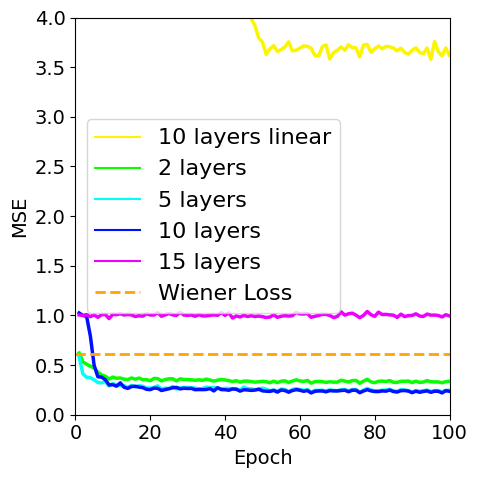

In [ ]:
plot_validation_losses_seaborn(val_losses_list, model_names, wiener_star_loss, y_max=4)

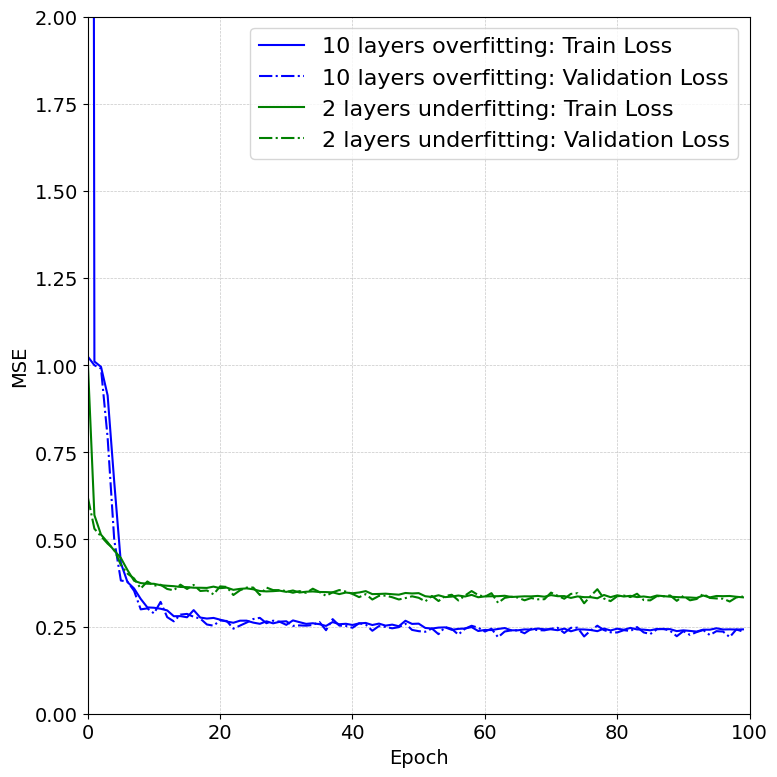

In [ ]:
plot_combined_losses(train_loss_dnn_overfitting*signal_length, val_loss_dnn_overfitting, train_loss_dnn_2layer*signal_length, val_loss_dnn_2layer, wiener_star_loss, title1='10 layers overfitting', title2='2 layers underfitting', y_max=2, smooth=False,  xlim=100)

### learning rate

In [ ]:
def train_network_on_fixed_noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001, seed=0, weight_decay=0, optimizer_type = 'Adam'):

    if optimizer_type == 'Adam':
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);
    torch.manual_seed(seed)

    noise_list = []
    for i, data in enumerate(train_loader):

      noise = torch.normal(0, noise_std, size=data.shape)

      noise = torch.clamp(noise, -1, 1)

      noise_list.append(noise)

    # print(noise_list)


    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + noise_list[i]);

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


def plot_combined_losses_train(train_loss, train_loss_dnn1, train_loss_dnn2, train_loss2, save_path='combined_losses.pdf', title1='0.0001', title2='0.001', title3='0.01',  title4='0.1', y_max=0.2, smooth=True, tick_font_size=14):
    y_min = 0
    y_max = y_max
    fig, ax = plt.subplots(figsize=(8, 8))

    if smooth:
        # Apply moving average if smoothing is desired
        train_loss = moving_average(train_loss)
        train_loss_dnn1 = moving_average(train_loss_dnn1)
        train_loss_dnn2 = moving_average(train_loss_dnn2)
        train_loss2 = moving_average(train_loss2)

    # Plotting for the first experiment
    ax.plot(train_loss, label=title1 + '', color='blue')
    # ax.plot(val_loss, label=title1 + ':Validation Loss', color='blue', linestyle='-.')
    # ax.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')

    # Plotting for the DNN experiment
    ax.plot(train_loss_dnn1, label=title2 + '', color='orange')
    ax.plot(train_loss_dnn2, label=title3 + '', color='green')
    # ax.plot(val_loss_dnn, label=title2 + ':Validation Loss', color='green', linestyle='-.')

    ax.plot(train_loss2, label=title4 + '', color='red')





    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    # ax.set_title(title, fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    # ax.legend()
    ax.legend(fontsize=16)

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=2)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, 100)

    plt.tight_layout()
    save_path =  'learning_rate.png'
    plt.savefig(save_path,dpi=300)
    plt.show()


In [ ]:
net_nn_lr_small = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=False)


train_loss_dnn_lr_small, val_loss_dnn_lr_small = train_network_on_fixed_noise(net_nn_lr_small, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-4, optimizer_type='SGD')



0 train error:  0.9985643806457519 val error:  0.9949205112457276
1 train error:  1.0105078964233398 val error:  0.9932765716314316
2 train error:  0.993388370513916 val error:  0.982958258986473
3 train error:  1.0003967933654785 val error:  0.9881145256757736
4 train error:  1.0029876441955567 val error:  0.9967551630735397
5 train error:  0.9949490814208984 val error:  1.0116360700130462
6 train error:  0.9905282058715821 val error:  0.9970460444688797
7 train error:  0.9885018196105957 val error:  1.0036265498399735
8 train error:  0.9921646575927734 val error:  0.9557451528310775
9 train error:  0.9913799514770508 val error:  0.9788741546869278
10 train error:  1.0027360610961915 val error:  0.9594681578874588
11 train error:  0.9959950065612793 val error:  0.9836921966075898
12 train error:  0.9915917549133301 val error:  0.9920956122875214
13 train error:  0.996843074798584 val error:  0.9952171957492828
14 train error:  0.9854900093078613 val error:  1.0106807762384415
15 train

In [ ]:
net_nn_lr_small2 = DnCNNskipcon(depth=10, n_channels=16, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=False)


train_loss_dnn_lr_small2, val_loss_dnn_lr_small2 = train_network_on_fixed_noise(net_nn_lr_small2, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-3,optimizer_type='Adam')



0 train error:  0.9403966178894043 val error:  0.9348418772220611
1 train error:  0.6243339538574219 val error:  0.6100439524650574
2 train error:  0.5095393581390381 val error:  0.49841961830854414
3 train error:  0.4410700378417969 val error:  0.44600824564695357
4 train error:  0.40696368789672854 val error:  0.4006983470916748
5 train error:  0.36884245014190675 val error:  0.3636516647040844
6 train error:  0.34125941467285154 val error:  0.332136692404747
7 train error:  0.3376707458496094 val error:  0.3395274230837822
8 train error:  0.32330774974822996 val error:  0.3075414673984051
9 train error:  0.31357587814331056 val error:  0.3125378495454788
10 train error:  0.3069360380172729 val error:  0.3024160251021385
11 train error:  0.3055655279159546 val error:  0.29507989570498466
12 train error:  0.300011869430542 val error:  0.29889225125312807
13 train error:  0.298511004447937 val error:  0.30619445979595183
14 train error:  0.2903051643371582 val error:  0.300638975948095

In [ ]:
net_nn_lr_mid = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=False)


train_loss_dnn_lr_mid, val_loss_dnn_lr_mid = train_network_on_fixed_noise(net_nn_lr_mid, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2,optimizer_type='SGD')



0 train error:  0.9975368843078614 val error:  0.993936613202095
1 train error:  1.007821174621582 val error:  0.9906576687097549
2 train error:  0.9892114219665528 val error:  0.9786023110151291
3 train error:  0.9946397094726562 val error:  0.9825955754518509
4 train error:  0.9959582481384277 val error:  0.9897154796123505
5 train error:  0.9867515182495117 val error:  1.0038602262735368
6 train error:  0.9812488021850586 val error:  0.9869815397262574
7 train error:  0.9779889678955078 val error:  0.9929926699399948
8 train error:  0.9807558860778809 val error:  0.9445372223854065
9 train error:  0.9785998420715332 val error:  0.9659704214334488
10 train error:  0.9885203552246093 val error:  0.9461157631874084
11 train error:  0.9806383094787597 val error:  0.9688144755363465
12 train error:  0.9752340393066407 val error:  0.9752837520837784
13 train error:  0.9792508773803711 val error:  0.9778492987155915
14 train error:  0.966513011932373 val error:  0.992056799530983
15 train 

In [ ]:
net_nn_lr_mid_adam = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)


train_loss_dnn_lr_mid_adam, val_loss_dnn_lr_mid_adam = train_network_on_fixed_noise(net_nn_lr_mid_adam, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2,optimizer_type='Adam')



0 train error:  1.0358250198364258 val error:  1.0258980309963226
1 train error:  1.0160475463867187 val error:  0.9993221932649612
2 train error:  0.9797176208496093 val error:  0.974585981965065
3 train error:  0.7864924201965332 val error:  0.7755574584007263
4 train error:  0.4815622844696045 val error:  0.47904047012329104
5 train error:  0.3812105216979981 val error:  0.3798566092550755
6 train error:  0.36824417877197263 val error:  0.35869177177548406
7 train error:  0.3364832229614258 val error:  0.3394163747131824
8 train error:  0.31068480682373045 val error:  0.2960956874489784
9 train error:  0.29856430625915525 val error:  0.29930910527706145
10 train error:  0.286564510345459 val error:  0.27925454154610635
11 train error:  0.31742769050598146 val error:  0.3050927709043026
12 train error:  0.2816592073440552 val error:  0.2807368797063827
13 train error:  0.2722928533554077 val error:  0.2812545896321535
14 train error:  0.2672966213226318 val error:  0.2766239862143993

In [ ]:
net_nn_lr_large = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)


train_loss_dnn_lr_large, val_loss_dnn_lr_large = train_network_on_fixed_noise(net_nn_lr_large, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-1,
                      optimizer_type='SGD')



0 train error:  0.973763801574707 val error:  0.9699637854099273
1 train error:  0.9514166221618653 val error:  0.9348894286155701
2 train error:  0.8902554702758789 val error:  0.8797126227617263
3 train error:  0.8224365043640137 val error:  0.811727774143219
4 train error:  0.7176185054779053 val error:  0.705868452489376
5 train error:  0.6044915904998779 val error:  0.611301707625389
6 train error:  0.5131847534179688 val error:  0.5033541566133499
7 train error:  0.46364656448364255 val error:  0.47209612771868703
8 train error:  0.4463974723815918 val error:  0.4294393301010132
9 train error:  0.42826851272583005 val error:  0.4324679984152317
10 train error:  0.4186148338317871 val error:  0.4127259361743927
11 train error:  0.4087069149017334 val error:  0.4001227569580078
12 train error:  0.4015186748504639 val error:  0.40132528185844424
13 train error:  0.3938491611480713 val error:  0.39883613124489786
14 train error:  0.38221303367614745 val error:  0.39332634925842286
15

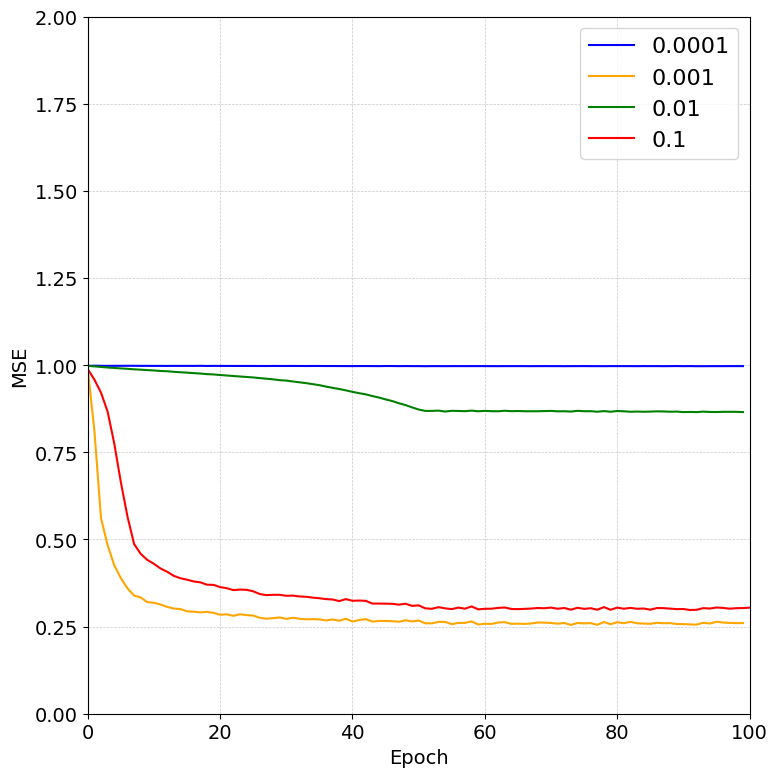

In [ ]:
plot_combined_losses_train( train_loss_dnn_lr_small*signal_length, train_loss_dnn_lr_small2*signal_length, train_loss_dnn_lr_mid*signal_length, train_loss_dnn_lr_large*signal_length, y_max=2, smooth=False)

### weight decay

In [ ]:
net_nn_wd = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)
# train_loss_dnn_wo_bn, val_loss_dnn_wo_bn = train_network_on_noise(net_nn_wo_bn, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 200,
#                        milestone = 50,
#                       lr = 1e-2)

train_loss_dnn_wd, val_loss_dnn_wd = train_network_on_fixed_noise(net_nn_wd, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-2,weight_decay=1e-6)



0 train error:  1.0027157516479492 val error:  0.999273129105568
1 train error:  1.011880226135254 val error:  0.9954053318500519
2 train error:  0.9530614509582519 val error:  0.9467100352048874
3 train error:  0.6777902317047119 val error:  0.6687112298607826
4 train error:  0.41060504531860353 val error:  0.4039864718914032
5 train error:  0.3807568941116333 val error:  0.37683857560157774
6 train error:  0.3374867401123047 val error:  0.32796521708369253
7 train error:  0.3183480396270752 val error:  0.31940902218222617
8 train error:  0.31211530685424804 val error:  0.3002853526175022
9 train error:  0.3014031581878662 val error:  0.30406183198094366
10 train error:  0.2987348489761353 val error:  0.28762125864624977
11 train error:  0.3063476543426514 val error:  0.29774961091578006
12 train error:  0.29578222274780275 val error:  0.29427229762077334
13 train error:  0.28576380062103274 val error:  0.29366825371980665
14 train error:  0.2770071334838867 val error:  0.291304340511

In [ ]:
# net_nn_w_bn = DnCNN(depth=10, n_channels=16, image_channels=1, use_bnorm=False, kernel_size=3)
net_nn_no_wd = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3, use_bias=True)

train_loss_dnn_no_wd, val_loss_dnn_no_wd = train_network_on_fixed_noise(net_nn_no_wd, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 200,
                       milestone = 50,
                      lr = 1e-2,weight_decay=0)


0 train error:  1.002689239501953 val error:  0.9973836302757263
1 train error:  0.7929243869781494 val error:  0.77578837454319
2 train error:  0.4776032199859619 val error:  0.4676355880498886
3 train error:  0.4012473249435425 val error:  0.40819222122430804
4 train error:  0.35661643695831297 val error:  0.3512300035357475
5 train error:  0.33785247230529786 val error:  0.33699826419353485
6 train error:  0.31931002807617187 val error:  0.3102882334589958
7 train error:  0.2969374294281006 val error:  0.2973615883290768
8 train error:  0.31626330471038816 val error:  0.3044176022708416
9 train error:  0.28869162368774415 val error:  0.2899288663268089
10 train error:  0.28896555519104006 val error:  0.2858308866620064
11 train error:  0.26793919658660886 val error:  0.26192185424268244
12 train error:  0.27433392143249513 val error:  0.270926428809762
13 train error:  0.2552525472640991 val error:  0.264428510889411
14 train error:  0.2555406646728516 val error:  0.2678789512813091

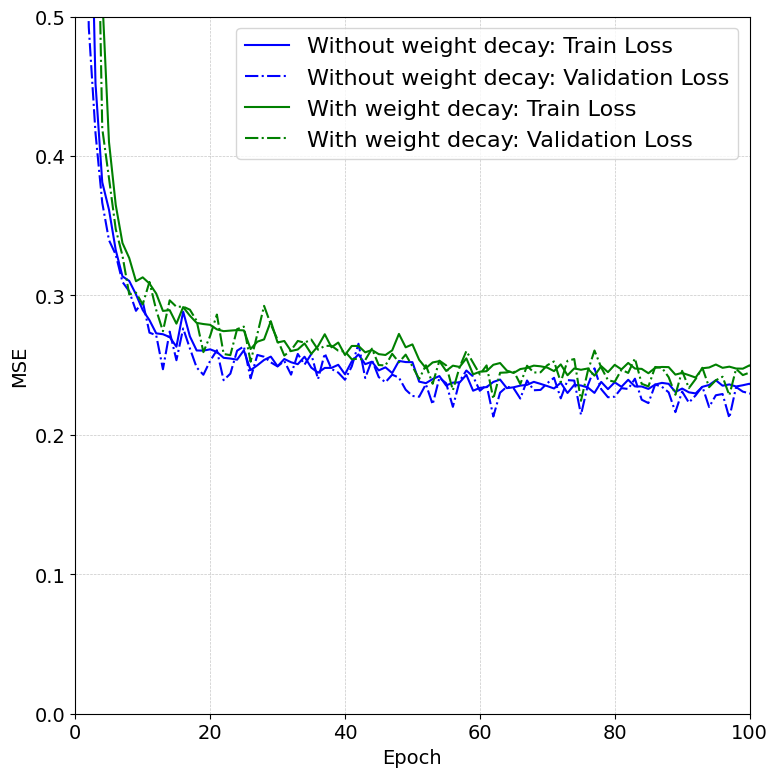

In [ ]:
plot_combined_losses(train_loss_dnn_no_wd*signal_length, val_loss_dnn_no_wd, train_loss_dnn_wd*signal_length, val_loss_dnn_wd, wiener_star_loss, title1='Without weight decay', title2='With weight decay', y_max=0.5, smooth=False)

In [ ]:
# def moving_average(data, window_size=5):
#     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# def plot_combined_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, wiener_star_loss, save_path='combined_losses.pdf', title1='DNN without Batch Normalization', title2='DNN with Batch Normalization', title='Combined Losses', y_max=0.2, smooth=False):
#     y_min = 0
#     y_max = y_max
#     fig, ax = plt.subplots(figsize=(10, 6))

#     if smooth:
#         # Apply moving average if smoothing is desired
#         train_loss = moving_average(train_loss)
#         val_loss = moving_average(val_loss)
#         train_loss_dnn = moving_average(train_loss_dnn)
#         val_loss_dnn = moving_average(val_loss_dnn)

#     # Plotting for the first experiment
#     ax.plot(train_loss, label=title1 + ': Train Loss', color='blue')
#     ax.plot(val_loss, label=title1 + ':Validation Loss', color='green')
#     ax.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')

#     # Plotting for the DNN experiment
#     ax.plot(train_loss_dnn, label=title2 + ':Train Loss', color='blue', linestyle='-.')
#     ax.plot(val_loss_dnn, label=title2 + ':Validation Loss', color='green', linestyle='-.')

#     ax.set_title(title, fontsize=16)
#     ax.set_xlabel('Epoch', fontsize=14)
#     ax.set_ylabel('Loss', fontsize=14)
#     ax.legend()
#     ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
#     ax.set_ylim(y_min, y_max)

#     plt.tight_layout()
#     plt.savefig(save_path)
#     plt.show()


In [ ]:
# plot_combined_losses(train_loss_dnn_wo_bn*signal_length, val_loss_dnn_wo_bn, train_loss_dnn_w_bn*signal_length, val_loss_dnn_w_bn, wiener_star_loss, title1='DNN 10 layers: overfitting', title2='DNN 2 layers: underfitting', y_max=1.5)

## Noise2Noise

## Small training set

In [ ]:
def train_network_on_noise_noise2noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );
            target = data + get_noise(data, noise_std)

            loss = criterion(out_train, target)
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

def train_network_on_neighbor2neighbor(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();
            noisy = data + get_noise(data, noise_std)
            # print(noisy.shape)
            mask1, mask2 = generate_mask_pair(noisy)
            noisy_sub1 = generate_subimages(noisy, mask1)
            noisy_sub2 = generate_subimages(noisy, mask2)
            with torch.no_grad():
              noisy_denoised = model(noisy)
            noisy_sub1_denoised = generate_subimages(noisy_denoised, mask1)
            noisy_sub2_denoised = generate_subimages(noisy_denoised, mask2)
            noisy_output = model(noisy_sub1)
            noisy_target = noisy_sub2

            diff = noisy_output - noisy_target
            exp_diff = noisy_sub1_denoised - noisy_sub2_denoised
            loss1 = torch.mean(diff**2)
            loss2 =  torch.mean((diff - exp_diff)**2)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
def train_network_on_neighbor2neighbor(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();
            noisy = data + get_noise(data, noise_std)
            # print(noisy.shape)
            mask1, mask2 = generate_mask_pair(noisy)
            noisy_sub1 = generate_subimages(noisy, mask1)
            noisy_sub2 = generate_subimages(noisy, mask2)
            with torch.no_grad():
              noisy_denoised = model(noisy)
            noisy_sub1_denoised = generate_subimages(noisy_denoised, mask1)
            noisy_sub2_denoised = generate_subimages(noisy_denoised, mask2)
            noisy_output = model(noisy_sub1)
            noisy_target = noisy_sub2

            diff = noisy_output - noisy_target
            exp_diff = noisy_sub1_denoised - noisy_sub2_denoised
            loss1 = torch.mean(diff**2)
            loss2 =  torch.mean((diff - exp_diff)**2)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_combined_three_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, train_loss_dnn2, val_loss_dnn2, save_path='combined_losses.pdf', title1='supervised', title2='noise2noise', title3='neighbor2neighbor', title='Combined Losses', y_max=0.2, smooth=True):
    y_min = 0
    y_max = y_max
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjusted for more data

    if smooth:
        # Apply moving average if smoothing is desired
        train_loss = moving_average(train_loss)
        val_loss = moving_average(val_loss)
        train_loss_dnn = moving_average(train_loss_dnn)
        val_loss_dnn = moving_average(val_loss_dnn)
        train_loss_dnn2 = moving_average(train_loss_dnn2)
        val_loss_dnn2 = moving_average(val_loss_dnn2)

    # Plotting for the first experiment
    ax.plot(train_loss, label=title1 + ': Train Loss', color='blue')
    ax.plot(val_loss, label=title1 + ':Validation Loss', color='blue', linestyle='-.')

    # Plotting for the second experiment
    ax.plot(train_loss_dnn, label=title2 + ': Train Loss', color='green')
    ax.plot(val_loss_dnn, label=title2 + ': Validation Loss', color='green', linestyle='-.')

    # Plotting for the third experiment
    ax.plot(train_loss_dnn2, label=title3 + ': Train Loss', color='orange')
    ax.plot(val_loss_dnn2, label=title3 + ': Validation Loss', color='orange', linestyle='-.')

    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)  # Adjusted legend

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, 100)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:

prob_val = 0.3
min_sep = 5
signal_length = 100
train_dataset = PieceWiseConstantDataset(n_data = 10, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
net_nn_lr_final_noise2noise = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)


train_loss_dnn_final_noise2noise, val_loss_dnn_final_noise2noise = train_network_on_noise_noise2noise(net_nn_lr_final_noise2noise, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



0 train error:  37.949179077148436 val error:  39.19589534759521
1 train error:  1.0610578536987305 val error:  1.026539331674576
2 train error:  1.0730262756347657 val error:  1.1624853169918061
3 train error:  1.133509349822998 val error:  1.2219795727729796
4 train error:  1.0611043930053712 val error:  1.0913428807258605
5 train error:  1.0077637672424316 val error:  0.9836630886793136
6 train error:  0.9851041793823242 val error:  1.00610486805439
7 train error:  1.0542885780334472 val error:  1.0590274208784103
8 train error:  1.0805058479309082 val error:  1.0548489379882813
9 train error:  1.0312984466552735 val error:  0.9951654690504074
10 train error:  1.0831565856933594 val error:  1.1330155205726624
11 train error:  1.0364874839782714 val error:  0.9702308875322342
12 train error:  1.1052456855773927 val error:  1.000239341855049
13 train error:  1.009172534942627 val error:  1.008644078373909
14 train error:  0.986638069152832 val error:  1.027545331120491
15 train error:

In [ ]:
net_nn_lr_final_supervised= DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)


train_loss_dnn_final_supervised, val_loss_dnn_final_supervised = train_network_on_noise(net_nn_lr_final_supervised, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



0 train error:  1.4216130256652832 val error:  1.404706580042839
1 train error:  2.643534278869629 val error:  2.532926563024521
2 train error:  1.0806923866271974 val error:  1.027003373503685
3 train error:  0.9773249626159668 val error:  0.993071323633194
4 train error:  1.1102232933044434 val error:  1.0139931678771972
5 train error:  0.9692147254943848 val error:  0.998595381975174
6 train error:  1.0770438194274903 val error:  1.0496318924427033
7 train error:  0.9696177482604981 val error:  1.0019887483119965
8 train error:  1.0007911682128907 val error:  1.0162367802858352
9 train error:  1.0291736602783204 val error:  1.0263969802856445
10 train error:  0.9152352333068847 val error:  1.022486263513565
11 train error:  1.0198542594909668 val error:  1.0001774317026138
12 train error:  1.0349438667297364 val error:  0.9925190877914428
13 train error:  0.9659998893737793 val error:  1.0123562067747116
14 train error:  0.9490882873535156 val error:  1.0228817474842071
15 train err

In [ ]:
def validation_error_psnr(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;
    mean_noisy_psnr = 0;

    criterion = nn.MSELoss(reduction='sum');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += data.shape[0];
        # print(data)
        # print(out_val.shape)
        mean_noisy_psnr += compare_psnr(data.data.numpy(), out_val.data.numpy(), data_range=1.)
    print(mean_noisy_psnr/total_length)
    return error_val/total_length

In [ ]:
print(validation_error_psnr(net_nn_lr_final_noise2noise,val_loader,noise_std))
print(validation_error_psnr(net_nn_lr_final_supervised,val_loader,noise_std))

20.072053027268982
0.9939727079868317
24.041862013247137
0.40323767900466917


In [ ]:
# net_nn_lr_final = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)


# train_loss_dnn_final, val_loss_dnn_final = train_network_on_neighbor2neighbor(net_nn_lr_final, train_loader, val_loader,
#                        noise_std=noise_std,
#                        max_epoch = 100,
#                        milestone = 50,
#                       lr = 1e-2)



## Large training set

In [ ]:
# plot_combined_three_losses(train_loss_dnn_final_supervised*signal_length, val_loss_dnn_final_supervised, train_loss_dnn_final_noise2noise*signal_length, val_loss_dnn_final_noise2noise, train_loss_dnn_final*signal_length, val_loss_dnn_final,  y_max=3)

In [ ]:

prob_val = 0.3
min_sep = 5
signal_length = 100
train_dataset = PieceWiseConstantDataset(n_data = 500, prob = prob_val, n_signal = signal_length, fix_datapoints = True, min_sep = min_sep, use_circular_shift=False, circular_shift_get_item=False)
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = prob_val, min_sep =min_sep, use_circular_shift=False,circular_shift_get_item=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [ ]:
def train_network_on_noise_noise2noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );
            target = data + get_noise(data, noise_std)

            loss = criterion(out_train, target)
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
import torch

# def space_to_depth(x, block_size):
#     n, c, h = x.size()
#     unfolded_x = torch.nn.functional.unfold(x, block_size, stride=block_size)
#     return unfolded_x.view(n, c * block_size**2, h // block_size)

def space_to_depth(x, block_size):
    # x is expected to have shape [n, c, l] where l is the length of the sequence
    n, c, l = x.size()

    # Ensure the length is divisible by block_size
    if l % block_size != 0:
        raise ValueError("The length of the sequence must be divisible by the block_size.")

    # Reshape and transpose to interleave the blocks into the depth dimension
    x_reshaped = x.view(n, c, l // block_size, block_size)
    x_transposed = x_reshaped.permute(0, 1, 3, 2)
    return x_transposed.contiguous().view(n, c * block_size, l // block_size)


def generate_subimages(img, mask):
    n, c, h = img.shape
    subimage = torch.zeros(n,
                           c,
                           h // 2,
                           dtype=img.dtype,
                           layout=img.layout,
                           device=img.device)

    # per channel
    for i in range(c):
        img_per_channel = space_to_depth(img[:, i:i + 1, :], block_size=2)
        img_per_channel = img_per_channel.permute(0, 2, 1).reshape(-1)
        subimage[:, i:i + 1, :] = img_per_channel[mask].reshape(n, h // 2, 1).permute(0, 2, 1)

    return subimage


# def get_generator():
#     global operation_seed_counter
#     operation_seed_counter += 1
#     g_cuda_generator = torch.Generator(device="cpu")
#     g_cuda_generator.manual_seed(operation_seed_counter)
#     return g_cuda_generator


def generate_mask_pair(img):
    # prepare masks (N x C x H/2)
    n, c, h = img.shape
    mask1 = torch.zeros(size=(n * h // 2 * 2, ),
                        dtype=torch.bool,
                        device=img.device)
    mask2 = torch.zeros(size=(n * h // 2 * 2, ),
                        dtype=torch.bool,
                        device=img.device)

    # prepare random mask pairs
    idx_pair = torch.tensor(
        [[0, 1], [1, 0]],  # Adjusted for 1D case
        dtype=torch.int64,
        device=img.device)

    rd_idx = torch.zeros(size=(n * h // 2, ),
                         dtype=torch.int64,
                         device=img.device)
    torch.randint(low=0,
                  high=2,  # Adjusted for 1D case
                  size=(n * h // 2, ),
                  out=rd_idx)
    rd_pair_idx = idx_pair[rd_idx]
    rd_pair_idx += torch.arange(start=0,
                                end=n * h // 2 * 2,
                                step=2,  # Adjusted for 1D case
                                dtype=torch.int64,
                                device=img.device).reshape(-1, 1)

    # get masks
    mask1[rd_pair_idx[:, 0]] = 1
    mask2[rd_pair_idx[:, 1]] = 1

    return mask1, mask2

In [ ]:
def train_network_on_noise_noise2noise(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );
            target = data + get_noise(data, noise_std)

            loss = criterion(out_train, target)
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
def train_network_on_neighbor2neighbor(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();
            noisy = data + get_noise(data, noise_std)
            # print(noisy.shape)
            mask1, mask2 = generate_mask_pair(noisy)
            noisy_sub1 = generate_subimages(noisy, mask1)
            noisy_sub2 = generate_subimages(noisy, mask2)
            with torch.no_grad():
              noisy_denoised = model(noisy)
            noisy_sub1_denoised = generate_subimages(noisy_denoised, mask1)
            noisy_sub2_denoised = generate_subimages(noisy_denoised, mask2)
            noisy_output = model(noisy_sub1)
            noisy_target = noisy_sub2

            diff = noisy_output - noisy_target
            exp_diff = noisy_sub1_denoised - noisy_sub2_denoised
            loss1 = torch.mean(diff**2)
            loss2 =  torch.mean((diff - exp_diff)**2)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
            loss_all += loss.item()
            total_length+=1

        train_loss[epoch] = loss_all/total_length
#         train_loss[epoch] = validation_error(model, train_loader, noise_std)
        val_loss[epoch] =  validation_error(model, val_loader, noise_std)

        if epoch % 1 == 0:
            print(epoch, 'train error: ', validation_error(model, train_loader, noise_std),
                                                     'val error: ', validation_error(model, val_loader, noise_std));

    return train_loss, val_loss

In [ ]:
net_nn_lr_final = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)


train_loss_dnn_final, val_loss_dnn_final = train_network_on_neighbor2neighbor(net_nn_lr_final, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



19.970178571630758
0.6380503856525804


KeyboardInterrupt: ignored

In [ ]:
net_nn_lr_final_noise2noise_large = DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)


train_loss_dnn_final_noise2noise, val_loss_dnn_final_noise2noise = train_network_on_noise_noise2noise(net_nn_lr_final_noise2noise_large, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



20.05552850062898
0.6405291581979097
19.957150332855523
0 train error:  0.9963639526367187 val error:  1.0214114528894425
21.171697833141792
0.6739486884290512
21.19696775284895
1 train error:  0.7826563529968261 val error:  0.7669888138771057
23.48267390721104
0.7507770272185345
23.51497954772796
2 train error:  0.4514167346954346 val error:  0.454124781191349
24.232255000938995
0.7735821313004454
24.315753298263477
3 train error:  0.3822587928771973 val error:  0.37925142735242845
23.858451918699313
0.7642181068595173
23.969415571439477
4 train error:  0.4101989164352417 val error:  0.4125023964047432
24.790355356056743
0.7825607552287603
24.696017214867446
5 train error:  0.3594847707748413 val error:  0.34894356787204744
24.455829957711455
0.7801035891333685
24.505262610479008
6 train error:  0.3653954734802246 val error:  0.3642994686961174
25.10775984398643
0.797543242570793
25.176774169806645
7 train error:  0.3222243413925171 val error:  0.3123490762710571
25.311920051171498
0.

In [ ]:
net_nn_lr_final_supervised_large= DnCNNskipcon(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)


train_loss_dnn_final_supervised, val_loss_dnn_final_supervised = train_network_on_noise(net_nn_lr_final_supervised_large, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)



20.11724630371341
0.6410648051436862
20.10889580580759
0 train error:  0.992597541809082 val error:  0.9842258143424988
20.044099901107998
0.6412468473304964
20.0379690680701
1 train error:  0.9907470321655274 val error:  1.0001501178741454
21.631119993166738
0.6881917181510125
21.492290529208162
2 train error:  0.7067966899871826 val error:  0.7174087417125702
23.561908407817956
0.7525841170294698
23.61880574142456
3 train error:  0.44482462882995605 val error:  0.44331538140773774
24.198723637214947
0.7785441003606067
24.41824604594418
4 train error:  0.36925636196136474 val error:  0.37057821825146675
24.636277218700453
0.7900856870407861
24.950722212399263
5 train error:  0.3395950603485107 val error:  0.3308783783018589
25.129738325754015
0.7996493964077188
25.109303249696175
6 train error:  0.3175233449935913 val error:  0.31981763437390326
25.288967540104405
0.8029726583655282
25.153115249914872
7 train error:  0.3102253475189209 val error:  0.3167017163336277
25.15576412773729


In [ ]:
print(validation_error_psnr(net_nn_lr_final_noise2noise_large,val_loader,noise_std))
print(validation_error_psnr(net_nn_lr_final_supervised_large,val_loader,noise_std))

26.52729070958658
0.23648037888109685
26.803838835366882
0.22272467516362668


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Colors and fine-tuning sets as specified
category_colors = {
    'Noise2Noise': 'red',
    'Supervised': 'blue'
}

ft_sets = {
    'Small': [('Noise2Noise', 0.9462258213758469), ('Supervised', 0.4796674281358719)],
    'Large': [('Noise2Noise', 0.2483864478766918), ('Supervised', 0.241942210868001)],
}

# Further adjustments based on the new requirements:
# - Make bars much narrower
# - Place a shared legend at the bottom of the plots

# Adjust plot size
fig, axs = plt.subplots(1, 2, figsize=(8, 6))  # Width remains decreased

# Adjust the bar width to be much narrower
bar_width = 0.1

# Increase font size
plt.rcParams.update({'font.size': 14})

legend_labels = {}

# Plot each Fine-Tuning Set
for ax, (ft_set, data_tuples) in zip(axs, ft_sets.items()):
    for j, (data_type, size) in enumerate(data_tuples):
        position = j * bar_width
        ax.bar(position, size, width=bar_width, color=category_colors[data_type], label=data_type if data_type not in legend_labels else "")
        legend_labels[data_type] = category_colors[data_type]

    # Adjust the axes and labels
    ax.set_xticks(np.arange(len(data_tuples)) * bar_width)
    ax.set_xticklabels([])
    ax.set_ylabel('MSE')
    ax.set_title(f'{ft_set}')

# Adjust subplot layout
plt.tight_layout()

# Add a shared legend at the bottom of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.5, -0.05))
plt.savefig("unsupervised_training_set_comparison_plot.png", dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Adjusting the plot to show 'Large' and 'Small' on the x-axis and use category colors as legend

# Colors and fine-tuning sets as specified
category_colors = {
    'Noise2Noise': 'red',
    'Supervised': 'blue'
}

ft_sets = {
    'Small': [('Noise2Noise', 0.9462258213758469), ('Supervised', 0.4796674281358719)],
    'Large': [('Noise2Noise', 0.2483864478766918), ('Supervised', 0.241942210868001)],
}


fig, ax = plt.subplots(figsize=(8, 6))

# Adjust the bar width and offset
bar_width = 0.2
offset = bar_width * len(category_colors)

# Track labels for the legend
legend_labels = {}

# Plot each Fine-Tuning Set
for i, (ft_set, data_tuples) in enumerate(ft_sets.items()):
    bottom = 0
    for j, (data_type, size) in enumerate(data_tuples):
        position = i - offset / 2 + j * bar_width
        ax.bar(position, size, width=bar_width, color=category_colors[data_type], label=data_type if data_type not in legend_labels else "")
        legend_labels[data_type] = category_colors[data_type]

# Adjust the axes and labels
ax.set_xticks(np.arange(len(ft_sets)) - offset / 2 + bar_width * (len(category_colors) - 1) / 2)
ax.set_xticklabels(ft_sets.keys())
ax.set_ylabel('MSE')
# ax.set_title('Composition of Fine-Tuning Sets')

# Add the legend
# ax.legend()
# Adjust the plot area and set the legend outside
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Resize plot to make space for legend
fig.legend(handles, labels, loc='lower center', ncol=len(legend_labels), bbox_to_anchor=(0.45, -0.03))
plt.savefig("unsupervised_training_set_comparison_plot.png", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_combined_three_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, train_loss_dnn2, val_loss_dnn2, save_path='combined_losses.pdf', title1='supervised', title2='noise2noise', title3='neighbor2neighbor', title='Combined Losses', y_max=0.2, smooth=True):
    y_min = 0
    y_max = y_max
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjusted for more data

    if smooth:
        # Apply moving average if smoothing is desired
        train_loss = moving_average(train_loss)
        val_loss = moving_average(val_loss)
        train_loss_dnn = moving_average(train_loss_dnn)
        val_loss_dnn = moving_average(val_loss_dnn)
        train_loss_dnn2 = moving_average(train_loss_dnn2)
        val_loss_dnn2 = moving_average(val_loss_dnn2)

    # Plotting for the first experiment
    ax.plot(train_loss, label=title1 + ': Train Loss', color='blue')
    ax.plot(val_loss, label=title1 + ':Validation Loss', color='blue', linestyle='-.')

    # Plotting for the second experiment
    ax.plot(train_loss_dnn, label=title2 + ': Train Loss', color='green')
    ax.plot(val_loss_dnn, label=title2 + ': Validation Loss', color='green', linestyle='-.')

    # Plotting for the third experiment
    ax.plot(train_loss_dnn2, label=title3 + ': Train Loss', color='orange')
    ax.plot(val_loss_dnn2, label=title3 + ': Validation Loss', color='orange', linestyle='-.')

    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)  # Adjusted legend

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, 100)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


In [ ]:
plot_combined_three_losses(train_loss_dnn_final_supervised*signal_length, val_loss_dnn_final_supervised, train_loss_dnn_final_noise2noise*signal_length, val_loss_dnn_final_noise2noise, train_loss_dnn_final*signal_length, val_loss_dnn_final,  y_max=2)

In [ ]:
plot_combined_three_losses(train_loss_dnn_final_supervised*signal_length, val_loss_dnn_final_supervised, train_loss_dnn_final_noise2noise*signal_length, val_loss_dnn_final_noise2noise, train_loss_dnn_final*signal_length, val_loss_dnn_final,  y_max=0.4)

### visualization

In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['axes.titlesize'] = 16

# ... (rest of your code)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 30  # Title font size
plt.rcParams['axes.labelsize'] = 25  # Label font size
plt.rcParams['xtick.labelsize'] = 20  # Tick label font size
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2  # Line width


def save_image(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap='gray')
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def save_fft(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap=plt.cm.Blues)
    fig.savefig(filename, dpi=300)
    plt.close(fig)


def save_subplot(ax, filename):
    fig = ax.get_figure()
    # Ensure the figure is drawn, so that we have correct information for saving
    fig.canvas.draw()
    bbox = ax.get_tightbbox(fig.canvas.renderer)
    fig.savefig(filename, bbox_inches=bbox)


def compare_all_three(source, noise_std, wiener_star, unet, unet1, unet2, figsize=(35, 20), fft_sample=100, noise_scale=50, output_directory='output_constant_fig1', tick_font_size=25):
    noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Convert to numpy for processing
    source_numpy = source.cpu().detach().numpy()
    unet_denoised = unet(noisy.to(device))
    denoised2 = unet1(noisy.to(device))
    denoised3 = unet2(noisy.to(device))

    # Clone the source for PSNR comparison later and squeeze for FFT
    source_torch = source.clone()
    source = np.squeeze(source.numpy())
    noisy = np.squeeze(noisy.numpy())

    # Perform FFT and IFFT
    source_fft = fftshift(fft(source, n=fft_sample))
    noisy_fft = fftshift(fft(noisy, n=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
    noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
    denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))

    # Calculate PSNR values
    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
    psnr_unet = round(batch_PSNR(unet_denoised, source_torch, 1.), 2)
    # Add PSNR calculations for denoised2 and denoised3
    psnr_denoised2 = round(batch_PSNR(denoised2, source_torch, 1.), 2)
    psnr_denoised3 = round(batch_PSNR(denoised3, source_torch, 1.), 2)

    # Setup the subplots
    fig, axes = plt.subplots(2, 3, sharex=True, sharey='row', figsize=figsize)

    # Include the two new denoised results in the plots and titles
    plots = [
        source_ifft,
        noisy_ifft,
        denoised_ifft,
        tensor_to_signal_1D(unet_denoised[0]),
        tensor_to_signal_1D(denoised2[0]),
        tensor_to_signal_1D(denoised3[0])
    ]
    titles = [
        "Source",
        f"Noisy Image:\n PSNR {psnr_noisy}",
        f"Wiener Denoised:\n PSNR {psnr_denoised}",
        f"Neighbor2neighbor Denoised:\n PSNR {psnr_unet}",
        f"Noise2noise Denoised:\n PSNR {psnr_denoised2}",
        f"Supervised Denoised:\n PSNR {psnr_denoised3}"
    ]

    y_min, y_max = 0, 1

    # Plot the results
    for i in range(2):  # Iterate over rows
        for j in range(3):  # Iterate over columns
            idx = i * 3 + j  # Calculate the index for plots and titles
            axes[i, j].plot(plots[idx])
            axes[i, j].set_title(titles[idx])
            axes[i, j].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
            axes[i, j].minorticks_on()
            axes[i, j].grid(False)
            axes[i, j].set_ylim(y_min, y_max)

            if idx == 0:
                axes[i, j].set_ylabel('Signal Amplitude')

    aspect_ratio = 40  # or use a numerical value
    for ax_row in axes:
        for ax in ax_row:
            ax.set_aspect(aspect_ratio)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig(os.path.join(output_directory, 'comparison_plot_piecewise_const.pdf'), bbox_inches='tight', dpi=300)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.fftpack import fft, ifft, fftshift

def save_image(img, filename, cmap='gray'):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap=cmap)
    fig.savefig(filename, dpi=300)
    plt.close(fig)

def compare_all_three(source, noise_std, wiener_star, unet, unet1, unet2, figsize=(35, 20), fft_sample=100, noise_scale=50, output_directory='output_constant_fig1', tick_font_size=25):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Add noise, denoise, and prepare data
    noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
    source_numpy = source.cpu().detach().numpy()
    unet_denoised = unet(noisy.to(device))
    denoised2 = unet1(noisy.to(device))
    denoised3 = unet2(noisy.to(device))
    source_torch = source.clone()
    source = np.squeeze(source.numpy())
    noisy = np.squeeze(noisy.numpy())

    # Perform FFT and IFFT
    source_fft = fftshift(fft(source, n=fft_sample))
    noisy_fft = fftshift(fft(noisy, n=fft_sample))
    denoised_fft = noisy_fft * wiener_star
    source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
    noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
    denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))

    # Calculate PSNR values
    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
    psnr_unet = round(batch_PSNR(unet_denoised, source_torch, 1.), 2)
    psnr_denoised2 = round(batch_PSNR(denoised2, source_torch, 1.), 2)
    psnr_denoised3 = round(batch_PSNR(denoised3, source_torch, 1.), 2)

    plots = [
        source_ifft,
        noisy_ifft,
        denoised_ifft,
        tensor_to_signal_1D(unet_denoised[0]),
        tensor_to_signal_1D(denoised2[0]),
        tensor_to_signal_1D(denoised3[0])
    ]
    titles = [
        "Source",
        f"Noisy Image: PSNR {psnr_noisy}",
        f"Wiener Denoised: PSNR {psnr_denoised}",
        f"Neighbor2neighbor Denoised: PSNR {psnr_unet}",
        f"Noise2noise Denoised: PSNR {psnr_denoised2}",
        f"Supervised Denoised: PSNR {psnr_denoised3}"
    ]

    y_min, y_max = 0, 1.2
    aspect_ratio = 100  # Numerical value or 'auto'

    # Plot and save the results individually
    for i, (plot, title) in enumerate(zip(plots, titles)):
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(plot)
        # ax.set_title(title, fontsize=tick_font_size)
        ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
        ax.minorticks_on()
        ax.grid(False)
        ax.set_ylim(y_min, y_max)
        ax.set_aspect(aspect_ratio)

        # if i == 0:
        #     ax.set_ylabel('Signal Amplitude', fontsize=tick_font_size)
        ax.axis('off')
        plt.tight_layout()
        fig.savefig(os.path.join(output_directory, f'{title.replace(" ", "_").replace(":", "_")}.png'), bbox_inches='tight', dpi=300)
        plt.show()
        plt.close(fig)

# Add the definitions of get_noise, batch_PSNR, compare_psnr, tensor_to_signal_1D and any other necessary functions.


In [ ]:
# output_directory_root = 'output_constant_fig1'

# count = 0
# for data in test_loader:
#     for idx in range(1):
#         image_tensor = data[idx].unsqueeze(0)
#         compare_all_three(image_tensor,noise_std, wiener_star, net_nn_lr_final, fft_sample = 40,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(idx)))
#         count += 1
#     if count > 10:
#         break

In [ ]:
output_directory_root = 'output_constant_fig1'

count = 0
for b_idx, data in enumerate(test_loader):
    for idx in range(1):
        image_tensor = data[idx].unsqueeze(0)
        compare_all_three(image_tensor,noise_std, wiener_star, net_nn_lr_final,net_nn_lr_final_noise2noise, net_nn_lr_final_supervised,  figsize=(8, 5), fft_sample = 100,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(b_idx)))
        count += 1
    if count > 10:
        break

In [ ]:
def validation_error(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;
    mean_noisy_psnr = 0;

    criterion = nn.MSELoss(reduction='sum');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += data.shape[0];
        # print(data)
        # print(out_val.shape)
        mean_noisy_psnr += compare_psnr(data.data.numpy(), out_val.data.numpy(), data_range=1.)
    print(mean_noisy_psnr/total_length)
    return error_val/total_length

In [ ]:
test_loader

In [ ]:
validation_error(net_nn_lr_final_supervised,test_loader,noise_std)

In [ ]:
validation_error(net_nn_lr_final_noise2noise,test_loader,noise_std)

In [ ]:
def plot_1d_log_fft(signal, ax=None, ax_off=True, title_string=None):
    fft_shifted = np.fft.fftshift(np.fft.fft(signal))
    mat = np.log10(np.abs(fft_shifted) + 1e-9)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if ax_off:
        ax.axis('off')

    ax.plot(mat)
    ax.set_xlabel('Frequency')
#     ax.set_ylabel('Amplitude (Log Scale)')

    if title_string is not None:
        ax.set_title(title_string)

    return mat


In [ ]:
test_loader

In [ ]:
# output_directory_root = 'output_constant_fig1'

# count = 0
# for data in test_loader:
#     for idx in range(1):
#         image_tensor = data[idx].unsqueeze(0)
#         compare_all(image_tensor,noise_std, wiener_star, net_nn_wo_bn, fft_sample = 40,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(idx)))
#         count += 1
#     if count > 10:
#         break

In [ ]:
# output_directory_root = 'output_constant_fig1'

# count = 0
# for data in test_loader:
#     for idx in range(1):
#         image_tensor = data[idx].unsqueeze(0)
#         compare_all(image_tensor,noise_std, wiener_star,
#                                    onelayer_net_dict[noise_std][9], net_nn_w_bn, fft_sample = 40,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(idx)))
#         count += 1
#     if count > 10:
#         break

In [ ]:
# output_directory_root = 'output_constant_fig1'

# count = 0
# for data in test_loader:
#     for idx in range(1):
#         image_tensor = data[idx].unsqueeze(0)
#         compare_all(image_tensor,noise_std, wiener_star,
#                                    onelayer_net_dict[noise_std][9], net_nn_w_bn, fft_sample = 40,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(idx)))
#         count += 1
#     if count > 10:
#         break

In [ ]:
# output_directory_root = 'output_constant_fig1'

# count = 0
# for data in test_loader:
#     for idx in range(1):
#         image_tensor = data[idx].unsqueeze(0)
#         compare_all(image_tensor,noise_std, wiener_star,
#                                    onelayer_net_dict[noise_std][9], net_nn_wo_bn, fft_sample = 40,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(idx)))
#         count += 1
#     if count > 10:
#         break

# One layer Linear Network without the nolinear activation function

Here we show that one layer CNN without nonlinear layers can not outperform Wiener filter. This was put into a wavelet framework and optimized over a dataset to minimize the mean squared error. Please look into the the folder `multiscale_py` for details on implementation

### Training

In [ ]:
# def get_noise(signal, mode, noise_std=0.1, noise_scale=1, max_noise=1):
#     if mode == 'poisson':
#         scaled_signal = signal * noise_scale
#         noise_sample = torch.tensor(np.random.poisson(scaled_signal.numpy()))
#         noise = (noise_sample - scaled_signal) / noise_scale
#     else:
#         noise = torch.normal(0, noise_std, size=signal.shape)

#     noise = torch.clamp(noise, -max_noise, max_noise)
#     return noise


In [ ]:
import os
import pickle

In [ ]:
def validation_error_psnr(model, dataset_val, add_noise = False, noise_mode = 'G', noise_std=0.1, max_noise = 5e-1, noise_scale=50):
    model.eval()
    error_val = 0;
    psnr_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction = 'sum');

    for data in dataset_val:
        data = data[0]
#         print(data.shape)
#         data = data['image']
#         data = data.resize((256,256))
        target = data.clone()

        if add_noise:
#             data = data + get_noise(data, noise_std, mode = noise_mode, max_noise = max_noise);
#             data = Poisson(data).sample()

            data = data + get_noise(data, mode = noise_mode,noise_std=noise_std, max_noise = max_noise, noise_scale=noise_scale)



#             scaled_source = source * noise_scale
#             # Generate Poisson noise sample based on the scaled source
#             noise_sample = Poisson(scaled_source).sample()
#             # Scale back the generated noise
#             noise_sample = (noise_sample - scaled_source) / noise_scale
#             noisy = source + noise_sample
# #             noisy = noisy.numpy()[0]
#             data = noisy
        data = data.to(device)
        target = target.to(device)
        out_val = model( data );

        error_val += criterion(out_val, target).item()
        psnr_val += ( batch_PSNR(out_val, target, 1.0) * data.shape[0] )
        total_length += data.shape[0];

    return error_val/total_length, psnr_val/total_length

In [ ]:
def train_network_on_noise(model, train_loader, val_loader,
                            add_noise = False, noise_mode = 'G', max_noise = 5e-1, noise_std = 0.1,
                            max_epoch = 50,  milestone = 50, lr=0.001, plot_loss = True, verbose = False,
                            verbose_freq = 100, early_stopping = True, noise_scale=50):
    model = model.to(device)

    optimizer = optim.Adam( filter(lambda p: p.requires_grad, model.parameters()) , lr=lr);
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience = 5, factor = 0.5)
    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    train_psnr = np.zeros(max_epoch);
    val_psnr = np.zeros(max_epoch);

    best_model = None;
    best_val_loss = np.inf;

    for epoch in range(max_epoch):

#         if epoch > milestone:
#             for param_group in optimizer.param_groups:
#                 param_group["lr"] = lr/10;

        for i, data in enumerate(train_loader):
            data = data.squeeze()
            optimizer.zero_grad();
            model.train();
#             data = data['image']
            target = data.clone();

            if add_noise:
#                 data = Poisson(data).sample()
                data = data + get_noise(data, mode = noise_mode,noise_std=noise_std, max_noise = max_noise, noise_scale=noise_scale)

            data = data.to(device)
            target = target.to(device)

            out_train = model(data);
            loss = criterion(out_train, target);
            loss.backward()
            optimizer.step()

        train_loss[epoch], train_psnr[epoch] = validation_error_psnr(model, train_loader,
                                                                add_noise = add_noise);
        val_loss[epoch], val_psnr[epoch] = validation_error_psnr(model, val_loader,
                                                            add_noise = add_noise);
        scheduler.step(val_psnr[epoch])

        if (epoch+1) % verbose_freq == 0 and verbose:
            print(epoch+1, 'train error: ', train_loss[epoch],
                             'val error: ', val_loss[epoch],
                              'train psnr: ', train_psnr[epoch],
                             'val psnr: ', val_psnr[epoch]);

        if val_loss[epoch] < best_val_loss:
            best_model = model.state_dict();
            best_val_loss = val_loss[epoch]

    if early_stopping:
        model.load_state_dict(best_model)

    if plot_loss:
        plt.semilogy(np.arange(1, max_epoch+1), train_loss, label = 'train loss');
        plt.semilogy(np.arange(1, max_epoch+1), val_loss, label = 'val loss')
        plt.legend()
        plt.show()

        plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
        plt.plot(np.arange(1, max_epoch+1), val_psnr, label = 'val psnr')
        plt.legend()
        plt.show()

    return model, train_psnr, val_psnr, train_loss, val_loss

In [ ]:
kernel_size_list = [3,5,7,9];
onelayer_net_dict = {};

In [ ]:
# noise_std = noise_scale = 50
# string_noise_std = str(int(noise_std*1000))

# net_dict_filename = 'haar_image_'+string_noise_std+'.pth'

# if os.path.exists(os.path.join(path_to_saved_models, net_dict_filename)):
#     print('Loaded from file..')
#     net_dict = pickle.load( open( os.path.join(path_to_saved_models, net_dict_filename), "rb" ) )
#     #         kernel_size_list = list(net_dict.keys());
#     wavelets_net_dict[noise_std] = net_dict

In [ ]:
validation_dict = {}
# noise_std_array = [float(10)/255];

# for noise_std in noise_std_array:
# validation_dict[noise_std] ={}
# print('='*50)
# print('noise std: ', noise_std);

string_noise_scale = str(int(noise_scale))

net_dict_filename = 'onelayerln7_'+string_noise_scale+'.pth';

# if os.path.exists(os.path.join(path_to_saved_models, net_dict_filename)):
#     net_dict = pickle.load( open( os.path.join(path_to_saved_models, net_dict_filename), "rb" ) )
#     onelayer_net_dict[noise_scale] = net_dict
#     print('load pretained')

# else:


net_dict = {}
print('Training..')
for kernel_size in kernel_size_list:
    print(kernel_size)
    net_temp = LinearCNN1D(kernel_size=kernel_size).to(device);

    net_temp, train_psnr_tmpt, val_psnr_tmpt, train_loss_tempt, val_loss_tempt = train_network_on_noise(net_temp, train_loader, val_loader,
                            add_noise = True,
                            noise_mode = 'G',
                            max_epoch = 100,
                            milestone = 100,
                            lr = 1e-1,
                            verbose = True,
                            verbose_freq = 5,
                            plot_loss = True)
#             visualize_filters(net_temp)
    validation_dict[kernel_size] = val_psnr_tmpt
    plt.show()
    print('='*50)
    net_dict[kernel_size] = net_temp;
    pickle.dump(net_dict, open( os.path.join(path_to_saved_models, net_dict_filename), "wb" ) )
onelayer_net_dict[noise_scale] = net_dict
#     kernal_size = 3
max_epoch=30
# for noise_std in noise_std_array:
validation_dict[kernel_size]
#     plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
plt.plot(np.arange(1, 100+1), validation_dict[kernel_size_list[0]], label = 'kernal_size' + str(kernel_size_list[0]))
#     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[1]], label = 'kernal_size' + str(kernel_size_list[1]))
#     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[2]], label = 'kernal_size' + str(kernel_size_list[2]))
plt.axhline(y=wiener_star_psnr, color="red", linestyle="-", label = 'wiener')
plt.xlabel('training epochs')
plt.ylabel('validation psnr')
#     plt.title('noise level ' + str(noise_std))
plt.legend()
plt.show()

In [ ]:
# pickle.dump(net_dict, open( os.path.join(path_to_saved_models, net_dict_filename), "wb" ) )

In [ ]:
# train_loss_tempt


In [ ]:
# val_loss_tempt

In [ ]:
# train_loss_dnn

In [ ]:
# val_loss_dnn

In [ ]:
# wiener_star_loss

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_loss, val_loss, wiener_star_loss):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot train and validation losses
    ax.plot(train_loss, label='Train Loss', color='blue')
    ax.plot(val_loss, label='Validation Loss', color='green')

    # Plot the constant wiener_star_loss value
    ax.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')

    # Set titles and labels
    ax.set_title('Loss Curves', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

    # Display a legend
    ax.legend()

    # Make the plot grid less pronounced
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Ensure a tight layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
train_loss_dnn

In [ ]:
import matplotlib.pyplot as plt

def plot_side_by_side_losses(train_loss, val_loss, train_loss_dnn, val_loss_dnn, wiener_star_loss, save_path='side_by_side_losses.pdf'):


    y_min = 0  # Replace with your desired minimum value
    y_max = 1  # Replace with your desired maximum value
    # Create a figure with two side-by-side subplots that share the y-axis
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Plotting for the first experiment on the first subplot
    ax1.plot(train_loss, label='Train Loss', color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='green')
    ax1.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')
    ax1.set_title('Linear Net Loss Curves', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax1.set_ylim(y_min, y_max)

    # Plotting for the DNN experiment on the second subplot
    ax2.plot(train_loss_dnn, label='Train Loss (DNN)', color='blue', linestyle='-.')
    ax2.plot(val_loss_dnn, label='Validation Loss (DNN)', color='green', linestyle='-.')
    ax2.axhline(y=wiener_star_loss, color='red', linestyle='--', label='Wiener Star Loss')
    ax2.set_title('DNN Loss Curves', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=14)
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax2.set_ylim(y_min, y_max)

    # Ensure a tight layout and save
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

In [ ]:
plot_side_by_side_losses(train_loss_tempt, val_loss_tempt, train_loss_dnn*signal_length, val_loss_dnn, wiener_star_loss)

In [ ]:
# plot_side_by_side_losses(train_loss_dnn_large, val_loss_dnn_large, train_loss_dnn*signal_length, val_loss_dnn, wiener_star_loss)

### Val MSE and PNR for different kernel size

In [ ]:
best_kernel_size = {};
# kernel_size_list = [3]
# for noise_std in noise_std_array:

# print('noise std: ', noise_std)
best_kernel_psnr = 0;
best_kernel = 0;
for kernel_size in kernel_size_list:
    val_loss, val_psnr= validation_error_psnr(net_dict[kernel_size], val_loader,
                                                            add_noise = True);
    print('Kernel Size: ', kernel_size, 'Val MSE: ', val_loss, 'Val PSNR: ', val_psnr)
#         visualize_filters(net_dict[kernel_size])
    plt.show()
    if val_psnr > best_kernel_psnr:
        best_kernel_psnr = val_psnr;
        best_kernel = kernel_size;

best_kernel_size = best_kernel;
print('='*50 + '\n\n')

In [ ]:
net_dict[best_kernel].conv1.weight

In [ ]:
net_dict[best_kernel].conv1.bias

## Simple multilayer for denoisng

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NonlinearMultilayerCNN1D(nn.Module):
    def __init__(self, kernel_size=3, num_layers=3):
        super(NonlinearMultilayerCNN1D, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        for i in range(num_layers):
            self.convs.append(nn.Conv1d(1 if i == 0 else 16, 16, kernel_size, padding=(kernel_size-1)//2))

        self.final_conv = nn.Conv1d(16, 1, kernel_size, padding=(kernel_size-1)//2)

    def forward(self, x):
        # Assuming input x is of shape (batch_size, signal_length)
        # Reshape to (batch_size, 1, signal_length) for 1D convolution
        x = x.unsqueeze(1)

        for i in range(self.num_layers):
            x = self.convs[i](x)
            x = F.relu(x)

        rec_img = self.final_conv(x)

        # Reshape back to (batch_size, signal_length)
        rec_img = rec_img.squeeze(1)

        return rec_img

# Test the model
if __name__ == '__main__':
    model = NonlinearMultilayerCNN1D()
    x = torch.randn(5, 100)  # 5 samples, each of length 100
    output = model(x)
    print(output.shape)  # Should be [5, 100]


In [ ]:
# import torch.nn.functional as F
# import torch.nn.init as init

# class NonlinearMultilayerCNN1D(nn.Module):
# 	def __init__(self, depth=3, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
# 		super(NonlinearMultilayerCNN1D, self).__init__()
# 		# 		kernel_size = 3
# 		padding = 1

# 		self.use_bnorm = use_bnorm;
# 		self.depth = depth;

# 		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size,
# 									 padding=padding, bias=False)

# 		self.hidden_layer_list = [None] * (self.depth - 2);
# 		if self.use_bnorm:
# 			self.bn_layer_list = [None] * (self.depth - 2);

# 		for i in range(self.depth - 2):
# 			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels,
# 												  kernel_size=kernel_size, padding=padding, bias=False);
# 			if self.use_bnorm:
# 				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum=0.95)

# 		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
# 		if self.use_bnorm:
# 			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
# 		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size,
# 									padding=padding, bias=False)

# 		self._initialize_weights()

# 	def forward(self, x):
# 		if len(x.shape) == 2:
# 			x = x.unsqueeze(1)

# 		out = self.first_layer(x);
# 		out = F.relu(out);

# 		for i in range(self.depth - 2):
# 			out = self.hidden_layer_list[i](out);
# 			if self.use_bnorm:
# 				out = self.bn_layer_list[i](out);
# 			out = F.relu(out)

# 		out = self.last_layer(out)
# 		if len(out.shape) == 2:
# 			out = out.squeeze(1)

# 		return out


# 	def _initialize_weights(self):
# 		for m in self.modules():
# 			if isinstance(m, nn.Conv1d):
# 				init.orthogonal_(m.weight)
# 				# print('init weight')
# 				if m.bias is not None:
# 					init.constant_(m.bias, 0)
# 			elif isinstance(m, nn.BatchNorm1d):
# 				init.constant_(m.weight, 1)
# 				init.constant_(m.bias, 0)

In [ ]:
# kernel_size_list = [3,5,7,9];
kernel_size_list = [3];
multilayer_net_dict = {};

In [ ]:
validation_dict = {}
# noise_std_array = [float(10)/255];

# for noise_std in noise_std_array:
# validation_dict[noise_std] ={}
# print('='*50)
# print('noise std: ', noise_std);

string_noise_scale = str(int(noise_scale))

net_dict_filename = 'multilayercnnv3_'+string_noise_scale+'.pth';

if os.path.exists(os.path.join(path_to_saved_models, net_dict_filename)):
    net_dict = pickle.load( open( os.path.join(path_to_saved_models, net_dict_filename), "rb" ) )
    multilayer_net_dict[noise_scale] = net_dict
    print('load pretained')

else:


    net_dict = {}
    print('Training..')
    for kernel_size in kernel_size_list:
        print(kernel_size)
        net_temp = NonlinearMultilayerCNN1D(kernel_size=kernel_size).to(device);

        net_temp, train_psnr_tmpt, val_psnr_tmpt = train_network_on_noise(net_temp, train_loader, val_loader,
                                add_noise = True,
                                noise_mode = 'G',
                                max_epoch = 100,
                                milestone = 50,
                                lr = 1e-3,
                                verbose = True,
                                verbose_freq = 5,
                                plot_loss = True)
    #             visualize_filters(net_temp)
        validation_dict[kernel_size] = val_psnr_tmpt
        plt.show()
        print('='*50)
        net_dict[kernel_size] = net_temp;
        pickle.dump(net_dict, open( os.path.join(path_to_saved_models, net_dict_filename), "wb" ) )
    multilayer_net_dict[noise_scale] = net_dict
#     kernal_size = 3
    max_epoch=30
    # for noise_std in noise_std_array:
    validation_dict[kernel_size]
    #     plt.plot(np.arange(1, max_epoch+1), train_psnr, label = 'train psnr');
#     plt.plot(np.arange(1, max_epoch+1), validation_dict[kernel_size_list[0]], label = 'kernal_size' + str(kernel_size_list[0]))
#     #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[1]], label = 'kernal_size' + str(kernel_size_list[1]))
#     #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[2]], label = 'kernal_size' + str(kernel_size_list[2]))
#     plt.axhline(y=wiener_star_psnr, color="red", linestyle="-", label = 'wiener')
#     plt.xlabel('training epochs')
#     plt.ylabel('validation psnr')
#     #     plt.title('noise level ' + str(noise_std))
#     plt.legend()
#     plt.show()
    plt.plot(np.arange(1, 100+1), validation_dict[kernel_size_list[0]], label = 'kernal_size' + str(kernel_size_list[0]))
    #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[1]], label = 'kernal_size' + str(kernel_size_list[1]))
    #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[2]], label = 'kernal_size' + str(kernel_size_list[2]))
    plt.axhline(y=wiener_star_psnr, color="red", linestyle="-", label = 'wiener')
    plt.xlabel('training epochs')
    plt.ylabel('validation psnr')
    #     plt.title('noise level ' + str(noise_std))
    plt.legend()
    plt.show()

In [ ]:
# plt.plot(np.arange(1, 100+1), validation_dict[kernel_size_list[0]], label = 'kernal_size' + str(kernel_size_list[0]))
# #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[1]], label = 'kernal_size' + str(kernel_size_list[1]))
# #     plt.plot(np.arange(1, max_epoch+1), validation_dict[noise_std][kernel_size_list[2]], label = 'kernal_size' + str(kernel_size_list[2]))
# plt.axhline(y=wiener_star_psnr, color="red", linestyle="-", label = 'wiener')
# plt.xlabel('training epochs')
# plt.ylabel('validation psnr')
# #     plt.title('noise level ' + str(noise_std))
# plt.legend()
# plt.show()

# Further visualization

## Compare ALL

In [ ]:
# def compare_all(source, noise_std, wiener_star, net, net_linear, unet, figsize=(30, 10), fft_sample=100,noise_scale=50):
#     noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
# #     wavelet_denoised = net(noisy.unsqueeze(0))
#     source_numpy = source.cpu().detach().numpy()

# #     wavelet_denoised = denoise_wavelet(noisy.cpu().detach().numpy(), method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')
# #     wavelet_denoised = torch.tensor(wavelet_denoised).unsqueeze(0)
#     wavelet_denoised = net(noisy.unsqueeze(0)).squeeze(0)
#     linear_denoised = net_linear(noisy.unsqueeze(0))
#     unet_denoised = unet(noisy.to(device).unsqueeze(0))

#     source_torch = source.clone().unsqueeze(0)
#     source = source.numpy()
#     noisy = noisy.numpy()
# #     print(type(source))


# #         # Convert tensors to numpy arrays if necessary
# #     source = source if isinstance(source, np.ndarray) else source.numpy()
# #     noisy = noisy if isinstance(noisy, np.ndarray) else noisy.numpy()

#     # Compute FFT
# #     print(source)
#     source_fft = fftshift(fft(source, n=fft_sample))
#     noisy_fft = fftshift(fft(noisy, n=fft_sample))
#     denoised_fft = noisy_fft * wiener_star


#     source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
#     noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
#     denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))




# #     source_fft = np.fft.fftshift(np.fft.fft2(source, s=fft_sample))
# #     noisy_fft = np.fft.fftshift(np.fft.fft2(noisy, s=fft_sample))
# #     denoised_fft = noisy_fft * wiener_star

# #     source_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(source_fft), s=fft_sample)), 0., 1.)
# #     noisy_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(noisy_fft), s=fft_sample)), 0., 1.)
# #     denoised_ifft = np.clip(np.real(np.fft.ifft2(np.fft.ifftshift(denoised_fft), s=fft_sample)), 0., 1.)

#     psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
#     psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)
# #     psnr_wavelet = round(batch_PSNR(torch.clamp(wavelet_denoised, 0.0, 1.0), source_torch, 1.), 2)
# #     psnr_linear = round(batch_PSNR(torch.clamp(linear_denoised, 0.0, 1.0), source_torch, 1.), 2)
# #     psnr_unet = round(batch_PSNR(torch.clamp(unet_denoised, 0.0, 1.0), source_torch, 1.), 2)

#     psnr_wavelet = round(batch_PSNR(wavelet_denoised, source_torch, 1.), 2)
#     psnr_linear = round(batch_PSNR(linear_denoised, source_torch, 1.), 2)
#     psnr_unet = round(batch_PSNR(unet_denoised, source_torch, 1.), 2)


#     fig, axes = plt.subplots(2, 6, sharex=True, sharey='row', figsize=figsize)
#     axes[0, 0].plot(source_ifft)
#     axes[0, 0].axis('off')
#     plot_1d_log_fft(source_ifft, axes[1, 0])

#     axes[0, 1].plot(noisy_ifft)
#     axes[0, 1].set_title(f'noisy image: {psnr_noisy}')
#     axes[0, 1].axis('off')
#     plot_1d_log_fft(noisy_ifft, axes[1, 1])

#     axes[0, 2].plot(denoised_ifft)
#     axes[0, 2].set_title(f'wiener_denoised: {psnr_denoised}')
#     axes[0, 2].axis('off')
#     plot_1d_log_fft(denoised_ifft, axes[1, 2])

#     axes[0, 3].plot(tensor_to_signal_1D(wavelet_denoised))
#     axes[0, 3].set_title(f'wavelet_denoised: {psnr_wavelet}')
#     axes[0, 3].axis('off')
#     plot_1d_log_fft(tensor_to_signal_1D(wavelet_denoised), axes[1, 3])

#     axes[0, 4].plot(tensor_to_signal_1D(linear_denoised))
#     axes[0, 4].set_title(f'linearnet_denoised: {psnr_linear}')
#     axes[0, 4].axis('off')
#     plot_1d_log_fft(tensor_to_signal_1D(linear_denoised), axes[1, 4])

#     axes[0, 5].plot(tensor_to_signal_1D(unet_denoised))
#     axes[0, 5].set_title(f'DNN_denoised: {psnr_unet}')
#     axes[0, 5].axis('off')
#     plot_1d_log_fft(tensor_to_signal_1D(unet_denoised), axes[1, 5])

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()


In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['axes.titlesize'] = 16

# ... (rest of your code)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 30  # Title font size
plt.rcParams['axes.labelsize'] = 25  # Label font size
plt.rcParams['xtick.labelsize'] = 20  # Tick label font size
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2  # Line width


def compare_all(source, noise_std, wiener_star, net_linear, unet, figsize=(30, 15), fft_sample=100, noise_scale=50):
    noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)

    source_numpy = source.cpu().detach().numpy()
    linear_denoised = net_linear(noisy[0])
    unet_denoised = unet(noisy.to(device))

    source_torch = source.clone()
    source = np.squeeze(source.numpy())
    noisy = np.squeeze(noisy.numpy())

    source_fft = fftshift(fft(source, n=fft_sample))
    noisy_fft = fftshift(fft(noisy, n=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
    noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
    denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))

    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)

    psnr_linear = round(batch_PSNR(linear_denoised, source_torch, 1.), 2)
    psnr_unet = round(batch_PSNR(unet_denoised, source_torch, 1.), 2)

    fig, axes = plt.subplots(2, 5, sharex=True, sharey='row', figsize=figsize)

    plots = [source_ifft, noisy_ifft, denoised_ifft, tensor_to_signal_1D(linear_denoised), tensor_to_signal_1D(unet_denoised[0])]


    for idx, ax in enumerate(axes[0]):
        ax.plot(plots[idx])
        ax.set_title(titles[idx])
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
        ax.grid(which='minor', linestyle=':', linewidth='0.5')
        if idx == 0:
            ax.set_ylabel('Signal Amplitude')

    for idx, ax in enumerate(axes[1]):
        plot_1d_log_fft(plots[idx], ax)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
        ax.grid(which='minor', linestyle=':', linewidth='0.5')
        if idx == 0:
            ax.set_ylabel('FFT Amplitude')
        ax.set_xlabel('Frequency')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig('comparison_plot_piecewise_const.pdf', bbox_inches='tight', dpi=300)

In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['axes.titlesize'] = 16

# ... (rest of your code)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 30  # Title font size
plt.rcParams['axes.labelsize'] = 25  # Label font size
plt.rcParams['xtick.labelsize'] = 20  # Tick label font size
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2  # Line width


def save_image(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap='gray')
    fig.savefig(filename, dpi=300)
    plt.close(fig)



def save_fft(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap=plt.cm.Blues)
    fig.savefig(filename, dpi=300)
    plt.close(fig)


def save_subplot(ax, filename):
    fig = ax.get_figure()
    # Ensure the figure is drawn, so that we have correct information for saving
    fig.canvas.draw()
    bbox = ax.get_tightbbox(fig.canvas.renderer)
    fig.savefig(filename, bbox_inches=bbox)

def compare_all(source, noise_std, wiener_star, net_linear, unet, figsize=(30, 15), fft_sample=100, noise_scale=50,output_directory='output_constant_fig1'):
    noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    source_numpy = source.cpu().detach().numpy()
    linear_denoised = net_linear(noisy[0])
    unet_denoised = unet(noisy.to(device))

    source_torch = source.clone()
    source = np.squeeze(source.numpy())
    noisy = np.squeeze(noisy.numpy())

    source_fft = fftshift(fft(source, n=fft_sample))
    noisy_fft = fftshift(fft(noisy, n=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
    noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
    denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))

    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)

    psnr_linear = round(batch_PSNR(linear_denoised, source_torch, 1.), 2)
    psnr_unet = round(batch_PSNR(unet_denoised, source_torch, 1.), 2)

    fig, axes = plt.subplots(2, 5, sharex=True, sharey='row', figsize=figsize)

    plots = [source_ifft, noisy_ifft, denoised_ifft, tensor_to_signal_1D(linear_denoised), tensor_to_signal_1D(unet_denoised[0])]
    titles = ["Source", f"Noisy Image:\n PSNR {psnr_noisy}", f"Wiener Denoised:\n PSNR {psnr_denoised}", f"LinearNet Denoised:\n PSNR {psnr_linear}", f"DNN Denoised:\n PSNR {psnr_unet}"]


    for idx, ax in enumerate(axes[0]):
        figure = ax.plot(plots[idx])
#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
#         fig.savefig(filename)
        ax.set_title(titles[idx])
#         ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
#         ax.grid(which='minor', linestyle=':', linewidth='0.5')
        ax.grid(False)

#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
# #         save_image(plots[idx], filename)
#         save_subplot(ax, filename)

        if idx == 0:
            ax.set_ylabel('Signal Amplitude')


#             fig_temp, ax_temp = plt.subplots(figsize=ax.get_figure().get_size_inches())

        # Redraw the content of ax on ax_temp
#         ax.get_figure().canvas.draw()
#         ax_temp.imshow(ax.get_figure().canvas.buffer_rgba())

#         # Save the temporary figure
#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
#         fig_temp.savefig(filename)



    for idx, ax in enumerate(axes[1]):
        fft_display = plot_1d_log_fft(plots[idx], ax, ax_off=False)
#         ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
#         ax.grid(which='minor', linestyle=':', linewidth='0.5')
        ax.grid(False)


        # Enable x-axis and y-axis
        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)
        if idx == 0:
            ax.set_ylabel('FFT Amplitude')
        ax.set_xlabel('Frequency')

#         fig = ax.get_figure()

#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + "_FFT.pdf")
#         save_subplot(ax, filename)
#         fig.savefig(filename)
#         print(fft_display.shape)
#         save_fft(fft_display,filename)

#         fig_temp, ax_temp = plt.subplots(figsize=ax.get_figure().get_size_inches())

#         # Redraw the content of ax on ax_temp
#         ax.get_figure().canvas.draw()
#         ax_temp.imshow(ax.get_figure().canvas.buffer_rgba())

#         # Save the temporary figure
#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + "_FFT.pdf")
#         fig_temp.savefig(filename)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig('comparison_plot_piecewise_const.pdf', bbox_inches='tight', dpi=300)

In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['axes.titlesize'] = 16

# ... (rest of your code)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 30  # Title font size
plt.rcParams['axes.labelsize'] = 25  # Label font size
plt.rcParams['xtick.labelsize'] = 20  # Tick label font size
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 2  # Line width


# def save_image(img, filename):
#     # fig = plt.figure(frameon=False)
#     # ax = plt.Axes(fig, [0., 0., 1., 1.], )
#     # ax.set_axis_off()
#     # fig.add_axes(ax)
#     # ax.imshow(img, aspect='equal', cmap='gray')

#     figure = ax.plot(img)
# #         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
# #         fig.savefig(filename)
#     # ax.set_title(titles[idx])
# #         ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     ax.minorticks_on()
# #         ax.grid(which='minor', linestyle=':', linewidth='0.5')
#     ax.grid(False)
#     fig.savefig(filename, dpi=300)
#     plt.close(fig)

def save_image(signal, filename, ymin=0, ymax=1):
    # Create a figure
    fig, ax = plt.subplots()

    # Plot the signal
    ax.plot(signal)

    if ymin is not None and ymax is not None:
      ax.set_ylim([ymin, ymax])

    # Optional: Customize the plot
    # ax.set_title("Signal Plot")
    # ax.set_xlabel("X-axis Label")
    # ax.set_ylabel("Y-axis Label")

    # Turn off grid if not needed
    ax.grid(False)


    # Save the figure to the specified filename at 300 dpi
    fig.savefig(filename, dpi=300)

    # Close the plot to free up memory
    plt.close(fig)

def save_fft(img, filename):
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, aspect='equal', cmap=plt.cm.Blues)
    fig.savefig(filename, dpi=300)
    plt.close(fig)


def save_subplot(ax, filename):
    fig = ax.get_figure()
    # Ensure the figure is drawn, so that we have correct information for saving
    fig.canvas.draw()
    bbox = ax.get_tightbbox(fig.canvas.renderer)
    fig.savefig(filename, bbox_inches=bbox)

def compare_all(source, noise_std, wiener_star, net_linear, unet, figsize=(30, 15), fft_sample=100, noise_scale=50,output_directory='output_constant_fig1'):
    noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    source_numpy = source.cpu().detach().numpy()
    linear_denoised = net_linear(noisy[0])
    unet_denoised = unet(noisy.to(device))

    source_torch = source.clone()
    source = np.squeeze(source.numpy())
    noisy = np.squeeze(noisy.numpy())

    source_fft = fftshift(fft(source, n=fft_sample))
    noisy_fft = fftshift(fft(noisy, n=fft_sample))
    denoised_fft = noisy_fft * wiener_star

    source_ifft = np.real(ifft(fftshift(source_fft), n=fft_sample))
    noisy_ifft = np.real(ifft(fftshift(noisy_fft), n=fft_sample))
    denoised_ifft = np.real(ifft(fftshift(denoised_fft), n=fft_sample))

    psnr_noisy = round(compare_psnr(source_ifft, noisy_ifft, data_range=1.), 2)
    psnr_denoised = round(compare_psnr(source_ifft, denoised_ifft, data_range=1.), 2)

    psnr_linear = round(batch_PSNR(linear_denoised, source_torch, 1.), 2)
    psnr_unet = round(batch_PSNR(unet_denoised, source_torch, 1.), 2)

    fig, axes = plt.subplots(2, 4, sharex=True, sharey='row', figsize=figsize)

    plots = [source_ifft, noisy_ifft, denoised_ifft, tensor_to_signal_1D(unet_denoised[0])]
    titles = ["Source", f"Noisy Image:\n PSNR {psnr_noisy}", f"Wiener Denoised:\n PSNR {psnr_denoised}", f"DNN Denoised:\n PSNR {psnr_unet}"]


    for idx, ax in enumerate(axes[0]):
        figure = ax.plot(plots[idx])
#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
#         fig.savefig(filename)
        ax.set_title(titles[idx])
#         ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
#         ax.grid(which='minor', linestyle=':', linewidth='0.5')
        ax.grid(False)

        filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
        save_image(plots[idx], filename)
#         save_subplot(ax, filename)

        if idx == 0:
            ax.set_ylabel('Signal Amplitude')


#             fig_temp, ax_temp = plt.subplots(figsize=ax.get_figure().get_size_inches())

        # Redraw the content of ax on ax_temp
#         ax.get_figure().canvas.draw()
#         ax_temp.imshow(ax.get_figure().canvas.buffer_rgba())

#         # Save the temporary figure
#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + ".pdf")
#         fig_temp.savefig(filename)



    for idx, ax in enumerate(axes[1]):
        fft_display = plot_1d_log_fft(plots[idx], ax, ax_off=False)
#         ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
#         ax.grid(which='minor', linestyle=':', linewidth='0.5')
        ax.grid(False)


        # Enable x-axis and y-axis
        ax.xaxis.set_visible(True)
        ax.yaxis.set_visible(True)
        if idx == 0:
            ax.set_ylabel('FFT Amplitude')
        ax.set_xlabel('Frequency')

#         fig = ax.get_figure()

#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + "_FFT.pdf")
#         save_subplot(ax, filename)
#         fig.savefig(filename)
#         print(fft_display.shape)
#         save_fft(fft_display,filename)

#         fig_temp, ax_temp = plt.subplots(figsize=ax.get_figure().get_size_inches())

#         # Redraw the content of ax on ax_temp
#         ax.get_figure().canvas.draw()
#         ax_temp.imshow(ax.get_figure().canvas.buffer_rgba())

#         # Save the temporary figure
#         filename = os.path.join(output_directory, titles[idx].replace(" ", "_").replace(":", "") + "_FFT.pdf")
#         fig_temp.savefig(filename)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    fig.savefig('comparison_plot_piecewise_const.pdf', bbox_inches='tight', dpi=300)

In [ ]:
compare_all

## Compare image in the test set

In [ ]:
# count = 0
# for data in test_loader:

# #     image_tensor = data[0]
# #     compare_all(image_tensor,noise_std, wiener_star,wavelets_net_dict[noise_std][2][0],
# #                                onelayer_net_dict[noise_std][3], net_dict_unet[noise_std], fft_sample = (256, 256),noise_scale=noise_scale)
#     count += 1
# #     if count > 10:
# #         break

In [ ]:
def plot_1d_log_fft(signal, ax=None, ax_off=True, title_string=None):
    fft_shifted = np.fft.fftshift(np.fft.fft(signal))
    mat = np.log10(np.abs(fft_shifted) + 1e-9)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if ax_off:
        ax.axis('off')

    ax.plot(mat)
    ax.set_xlabel('Frequency')
#     ax.set_ylabel('Amplitude (Log Scale)')

    if title_string is not None:
        ax.set_title(title_string)

    return mat


In [ ]:
noise_std

0.1

In [ ]:
output_directory_root = 'output_constant_fig1_v2'

count = 0
for data_id, data in enumerate(test_loader):
    for idx in range(1):
        image_tensor = data[idx].unsqueeze(0)
        compare_all(image_tensor,noise_std, wiener_star,
                                   onelayer_net_dict[noise_std][9], net_nn_lr_final, fft_sample = 100,noise_scale=noise_scale, output_directory = os.path.join(output_directory_root, str(data_id)))
        count += 1
    if count > 10:
        break

NameError: ignored

In [ ]:
# count

In [ ]:
# net_nn

In [ ]:
def zero_gradients(inputs):
    for inp in inputs:
        if inp.grad is not None:
            inp.grad.data.zero_()


def compute_jacobian_and_bias_1d(inputs, net):

    inputs.requires_grad = True
    assert inputs.requires_grad

    outputs = net(inputs);

    assert(outputs.dim() == 3)
    assert(outputs.shape[0] == 1)
    assert(inputs.shape[1] == 1)

    channels = outputs.shape[1]
    n = inputs.shape[-1];

    total_dim = n*channels;

    jacobian = torch.zeros([total_dim, n]);
    grad_output = torch.zeros(n);

    if inputs.is_cuda:
        grad_output = grad_output.cuda()
        jacobian = jacobian.cuda()

    for j in range(channels):
        for i in range(n):
            zero_gradients(inputs)
            outputs[0, j, i].backward(retain_graph = True)
            jacobian[ j*channels + i, :] = inputs.grad.data.view(-1)


    bias = outputs[0].view(-1) - torch.matmul(jacobian, inputs[0,0])

    return jacobian.cpu().numpy(), bias.data.cpu().numpy()

In [ ]:
import torch

def zero_gradients(inputs):
    for inp in inputs:
        if inp.grad is not None:
            inp.grad.data.zero_()

def compute_jacobian_and_bias_1d(inputs, net):
    inputs.requires_grad = True
    assert inputs.requires_grad

    outputs = net(inputs)

    assert(outputs.dim() == 3)
    assert(outputs.shape[0] == 1)
    assert(inputs.shape[1] == 1)

    channels = outputs.shape[1]
    n = inputs.shape[-1]
    total_dim = n*channels

    jacobian = torch.zeros([total_dim, n])
    grad_output = torch.zeros(n)

    if inputs.is_cuda:
        grad_output = grad_output.cuda()
        jacobian = jacobian.cuda()

    for j in range(channels):
        for i in range(n):
            zero_gradients([inputs])
            outputs[0, j, i].backward(retain_graph=True)
            jacobian[j*channels + i, :] = inputs.grad.data.view(-1)

    bias = outputs[0].view(-1) - torch.matmul(jacobian, inputs[0,0])

    return jacobian.cpu().numpy(), bias.data.cpu().numpy()


In [ ]:
noise_scale

0.1

In [ ]:
net_nn = net_nn_15layer

In [ ]:
sample_idex = 1
source = test_dataset[sample_idex]
noisy = source + get_noise(source, mode='G', noise_std=noise_std, noise_scale=noise_scale)
# noisy = source + get_noise(source, noise_std=noise_std, noise_scale=noise_scale)


In [ ]:
jac, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn_15layer)

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))

# output_position = 70


# # plot source
# axes[0].plot(source[0].cpu().data.numpy())
# axes[0].set_title("Source")
# axes[0].axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
# axes[0].legend()


# axes[1].plot(noisy[0].cpu().data.numpy())
# axes[1].set_title("Noisy")
# axes[1].set_title(f"Gradient for Output Position {output_position}")
# axes[1].axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')

# # denoise
# noisy.requires_grad = True
# denoised = net_nn(noisy.unsqueeze(0))

# # Plot denoised signal
# axes[2].plot(denoised[0,0].cpu().data.numpy())
# axes[2].set_title("Denoised")
# # Indicate the output position in the denoised figure
# axes[2].axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
# axes[2].legend()

# # Compute Jacobian for the denoised tensor
# jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

# # Choose a specific position in the output to visualize its gradient
# gradient = jacobian[output_position, :]
# axes[3].plot(gradient)
# axes[3].set_title(f"Gradient for Output Position {output_position}")
# axes[3].axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
# axes[3].legend()

# plt.tight_layout()
# plt.show()


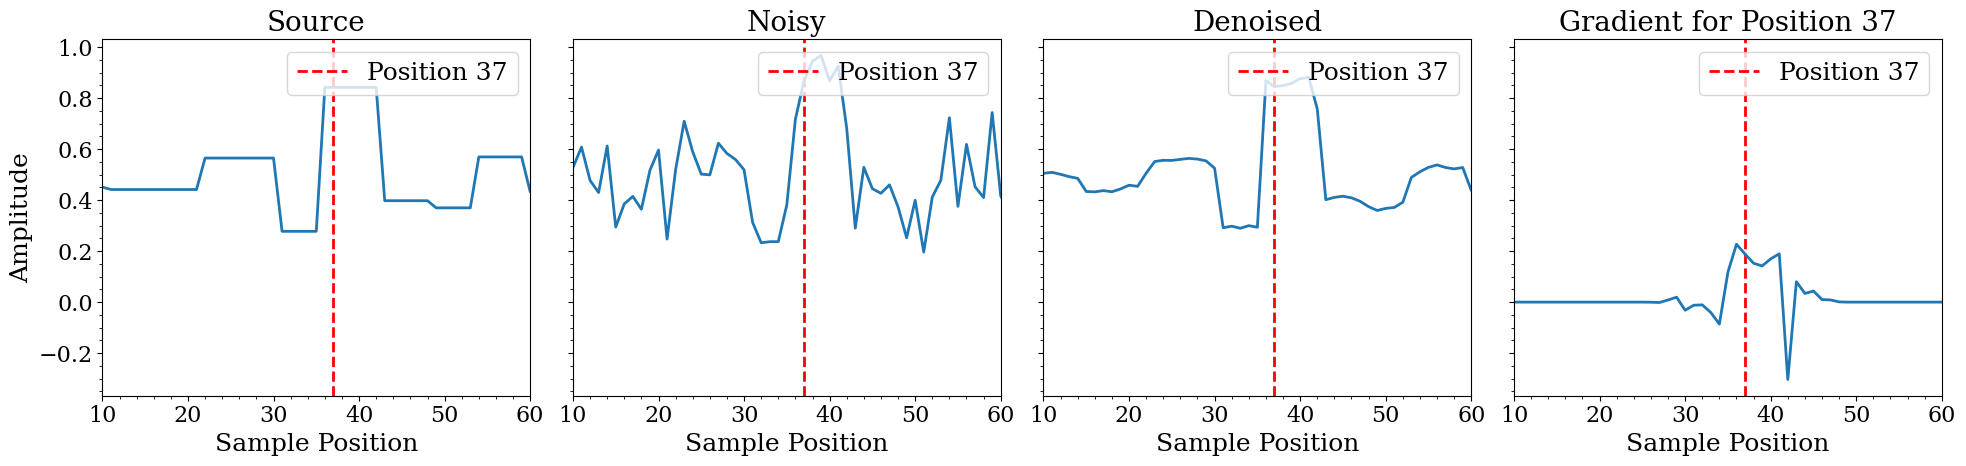

In [ ]:
import matplotlib.pyplot as plt

# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))
output_position = 37

# Common settings for all plots
for ax in axes:
    # ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Adjusted line width
    ax.grid(False)  # Grid turned off
    ax.minorticks_on()
    # ax.grid(which='minor', linestyle=':', linewidth='0.5')
    ax.axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Sample Position')

axes[0].set_ylabel('Amplitude')  # Only one y-label for shared y-axis

# plot source
axes[0].plot(source[0].cpu().data.numpy())
axes[0].set_title("Source")
axes[0].set_xlim(10,60)

axes[1].plot(noisy[0].cpu().data.numpy())
axes[1].set_title("Noisy")
axes[1].set_xlim(10,60)

# denoise
noisy.requires_grad = True
denoised = net_nn(noisy.unsqueeze(0))

# Plot denoised signal
axes[2].plot(denoised[0,0].cpu().data.numpy())
axes[2].set_title("Denoised")
axes[2].set_xlim(10,60)

# Compute Jacobian for the denoised tensor
jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

# Choose a specific position in the output to visualize its gradient
gradient = jacobian[output_position, :]
axes[3].plot(gradient)
axes[3].set_title(f"Gradient for Position {output_position}")
axes[3].set_xlim(10,60)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('comparison_plot_piecewise_const_gradient.pdf', bbox_inches='tight', dpi=300)

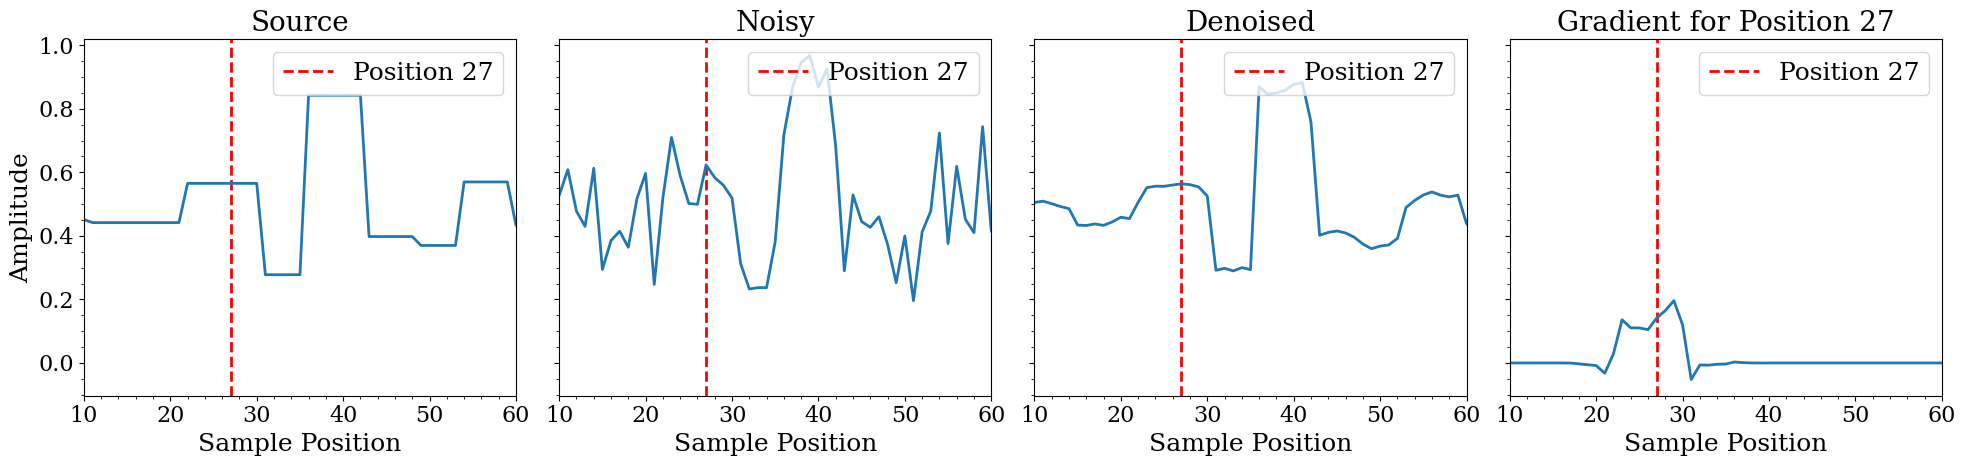

In [ ]:
import matplotlib.pyplot as plt

# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))
output_position = 27

# Common settings for all plots
for ax in axes:
    # ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Adjusted line width
    ax.grid(False)  # Grid turned off
    ax.minorticks_on()
    # ax.grid(which='minor', linestyle=':', linewidth='0.5')
    ax.axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Sample Position')

axes[0].set_ylabel('Amplitude')  # Only one y-label for shared y-axis

# plot source
axes[0].plot(source[0].cpu().data.numpy())
axes[0].set_title("Source")
axes[0].set_xlim(10,60)

axes[1].plot(noisy[0].cpu().data.numpy())
axes[1].set_title("Noisy")
axes[1].set_xlim(10,60)

# denoise
noisy.requires_grad = True
denoised = net_nn(noisy.unsqueeze(0))

# Plot denoised signal
axes[2].plot(denoised[0,0].cpu().data.numpy())
axes[2].set_title("Denoised")
axes[2].set_xlim(10,60)

# Compute Jacobian for the denoised tensor
jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

# Choose a specific position in the output to visualize its gradient
gradient = jacobian[output_position, :]
axes[3].plot(gradient)
axes[3].set_title(f"Gradient for Position {output_position}")
axes[3].set_xlim(10,60)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('comparison_plot_piecewise_const_gradient.pdf', bbox_inches='tight', dpi=300)

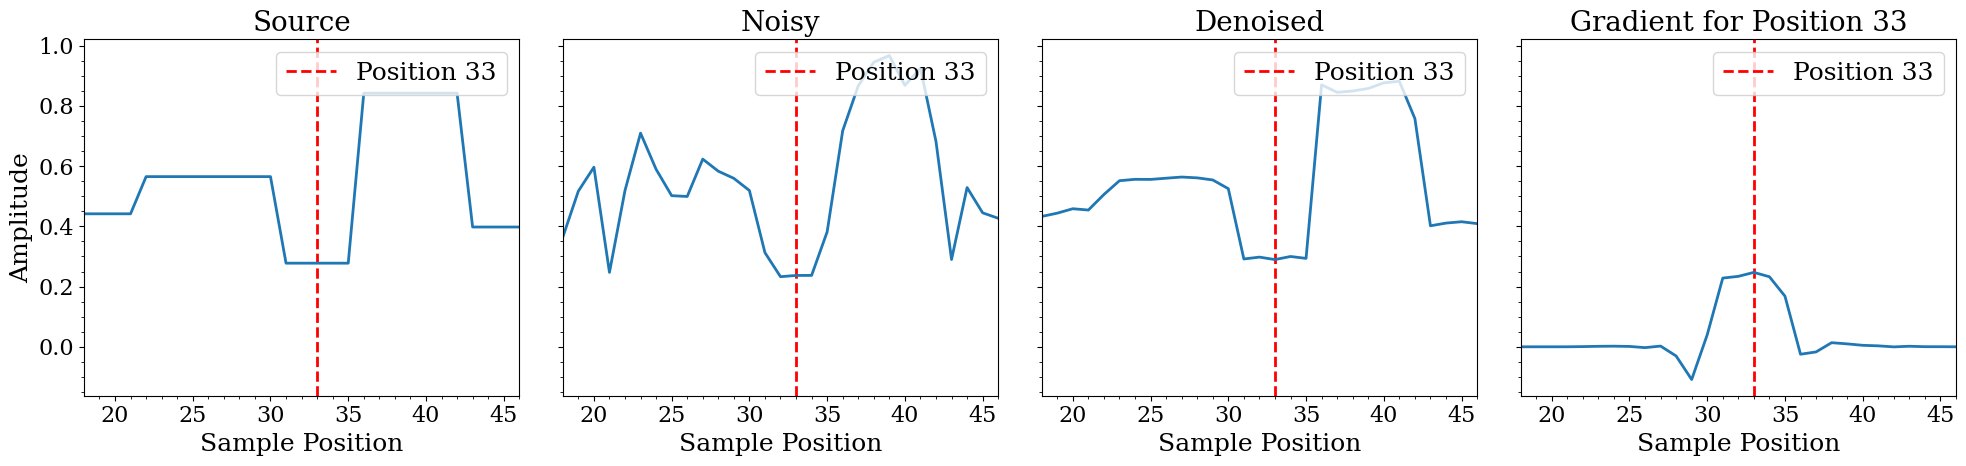

In [ ]:
import matplotlib.pyplot as plt
xlim_min = 18
xlim_max = 46
# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))
output_position = 33

# Common settings for all plots
for ax in axes:
    # ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Adjusted line width
    ax.grid(False)  # Grid turned off
    ax.minorticks_on()
    # ax.grid(which='minor', linestyle=':', linewidth='0.5')
    ax.axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Sample Position')

axes[0].set_ylabel('Amplitude')  # Only one y-label for shared y-axis

# plot source
axes[0].plot(source[0].cpu().data.numpy())
axes[0].set_title("Source")
axes[0].set_xlim(xlim_min,xlim_max)

axes[1].plot(noisy[0].cpu().data.numpy())
axes[1].set_title("Noisy")
axes[1].set_xlim(xlim_min,xlim_max)

# denoise
noisy.requires_grad = True
denoised = net_nn(noisy.unsqueeze(0))

# Plot denoised signal
axes[2].plot(denoised[0,0].cpu().data.numpy())
axes[2].set_title("Denoised")
axes[2].set_xlim(xlim_min,xlim_max)

# Compute Jacobian for the denoised tensor
jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

# Choose a specific position in the output to visualize its gradient
gradient = jacobian[output_position, :]
axes[3].plot(gradient)
axes[3].set_title(f"Gradient for Position {output_position}")
axes[3].set_xlim(xlim_min,xlim_max)

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('comparison_plot_piecewise_const_gradient.pdf', bbox_inches='tight', dpi=300)

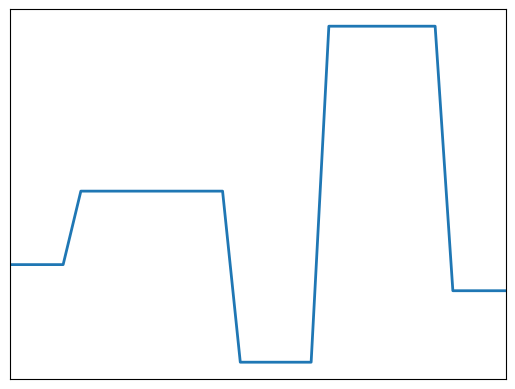

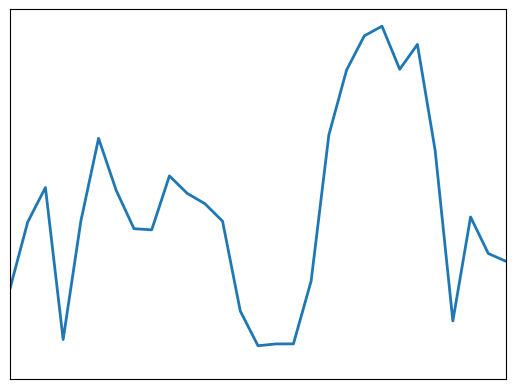

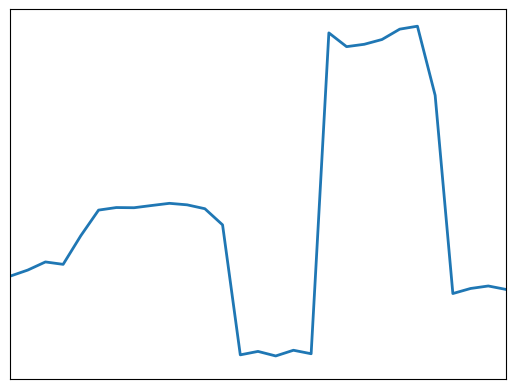

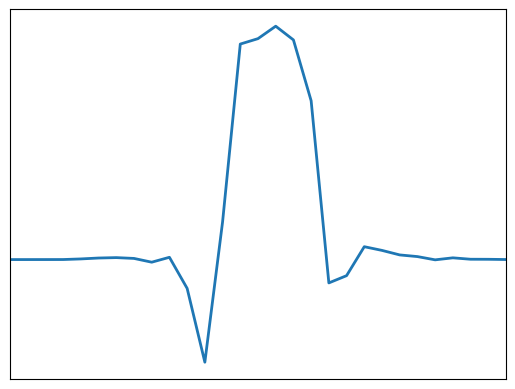

In [ ]:
import matplotlib.pyplot as plt
xlim_min = 18
xlim_max = 46
# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width


# Generate individual plots without subplots, text, ticks, or labels


jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

output_position = 27
# Choose a specific position in the output to visualize its gradient
gradient1 = jacobian[output_position, :]

output_position1 = 33
gradient2 = jacobian[output_position1, :]

output_position2 = 37
gradient3 = jacobian[output_position2, :]

# Using the dummy data for demonstration purposes
data_list = [noisy[0].cpu().data.numpy(), denoised[0,0].cpu().data.numpy(), gradient1,gradient2,gradient3]
for i, data in enumerate(data_list):
    # Create a new figure for each plot
    fig, ax = plt.subplots()
    ax.plot(data)
    ax.set_xlim(xlim_min, xlim_max)  # Set the x-limits as specified
    # ax.axis('off')  # Turn off the axis
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Re-enable the spines (borders) of the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
    # Save each plot individually without any text or ticks
    fig.savefig(f'individual_plot_{i}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)  # Close the plot to avoid displaying it again


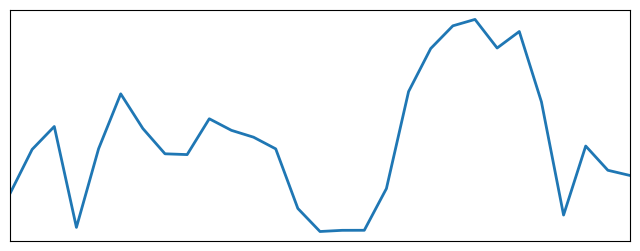

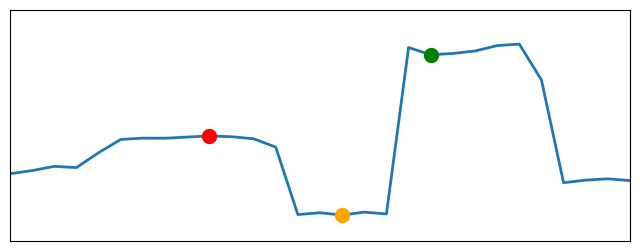

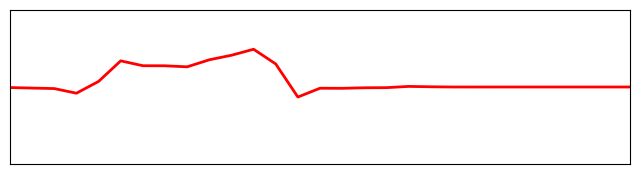

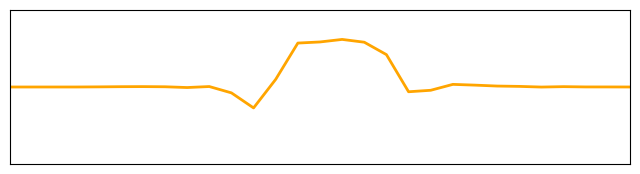

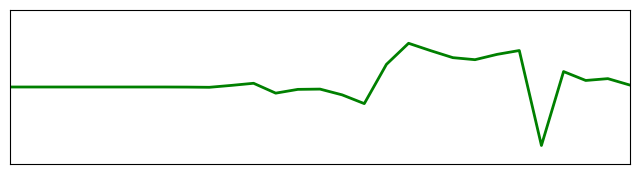

In [ ]:
# Since we are using dummy data for demonstration, we will create dummy jacobian data.
# The following line is just for demonstration and should be replaced with the actual computation of the jacobian.


xlim_min = 18
xlim_max = 46


ylim_min = 0.2
ylim_max = 1
figsize = (8, 3)  # Example size, adjust as needed
output_positions = [27, 33, 37]
colors = ['red', 'orange', 'green']  # Colors for the marker points

# Using the dummy data for demonstration purposes
noisy_data = noisy[0].cpu().data.numpy()
denoised_data = denoised[0,0].cpu().data.numpy()

# Plot and save the noisy and denoised signals with marker points at specified positions
fig, ax = plt.subplots(figsize=figsize)
ax.plot(noisy_data, label='Noisy')
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig.savefig('noisy_signals_with_markers.pdf', bbox_inches='tight', dpi=300)


fig, ax = plt.subplots(figsize=figsize)
ax.plot(denoised_data, label='Denoised')

# Add marker points to the denoised signal
for pos, color in zip(output_positions, colors):
    ax.plot(pos, denoised_data[pos], 'o', color=color, markersize=10)  # Marker point on denoised signal

ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Re-enable the spines (borders) of the plot
for spine in ax.spines.values():
    spine.set_visible(True)

# Save the noisy and denoised signals plot
fig.savefig('denoised_signals_with_markers.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

figsize = (8, 2)

ylim_min = -0.4
ylim_max = 0.4
# Now plot and save the gradients with corresponding colors
for i, (pos, color) in enumerate(zip(output_positions, colors)):
    fig, ax = plt.subplots(figsize=figsize)
    gradient = jacobian[pos, :]
    ax.plot(gradient, color=color)
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Re-enable the spines (borders) of the plot
    for spine in ax.spines.values():
        spine.set_visible(True)

    # Save the gradient plot with corresponding color
    fig.savefig(f'gradient_at_position_{pos}_color_{color}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close(fig)


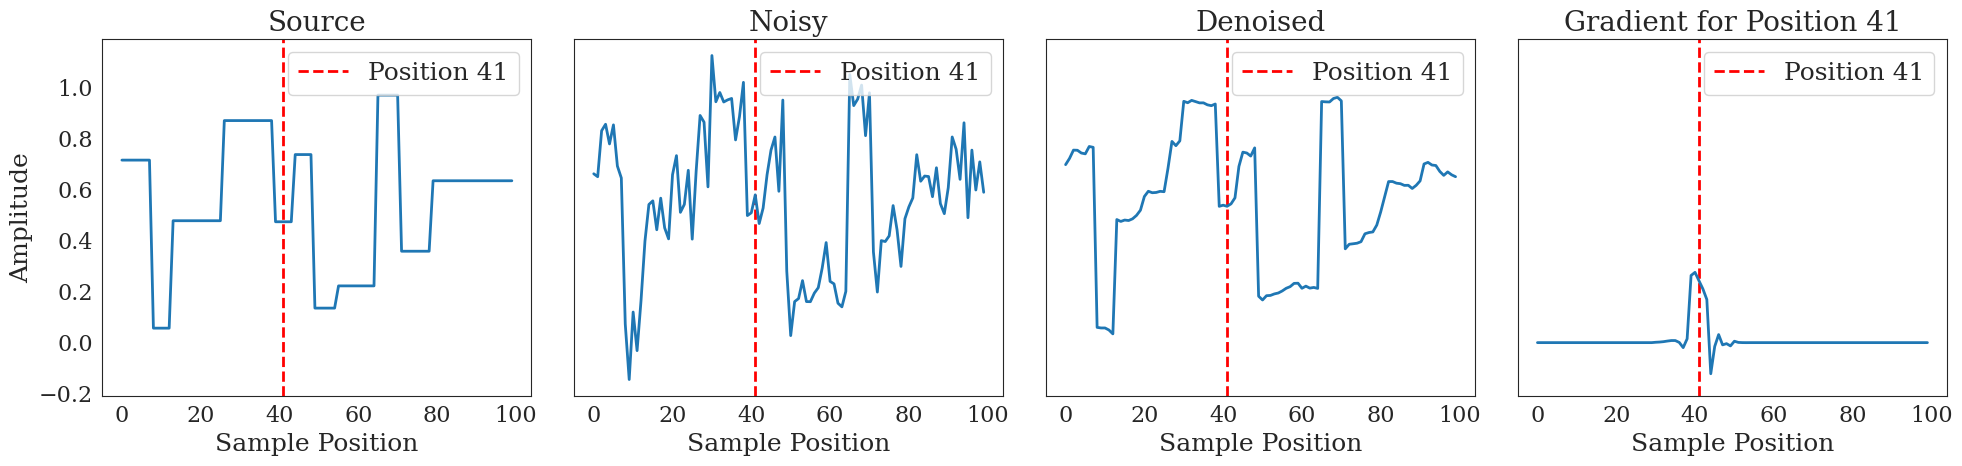

In [ ]:
import matplotlib.pyplot as plt

# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))
output_position = 41

# Common settings for all plots
for ax in axes:
    # ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Adjusted line width
    ax.grid(False)  # Grid turned off
    ax.minorticks_on()
    # ax.grid(which='minor', linestyle=':', linewidth='0.5')
    ax.axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Sample Position')

axes[0].set_ylabel('Amplitude')  # Only one y-label for shared y-axis

# plot source
axes[0].plot(source[0].cpu().data.numpy())
axes[0].set_title("Source")

axes[1].plot(noisy[0].cpu().data.numpy())
axes[1].set_title("Noisy")

# denoise
noisy.requires_grad = True
denoised = net_nn(noisy.unsqueeze(0))

# Plot denoised signal
axes[2].plot(denoised[0,0].cpu().data.numpy())
axes[2].set_title("Denoised")

# Compute Jacobian for the denoised tensor
jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

# Choose a specific position in the output to visualize its gradient
gradient = jacobian[output_position, :]
axes[3].plot(gradient)
axes[3].set_title(f"Gradient for Position {output_position}")

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('comparison_plot_piecewise_const_gradient_2.pdf', bbox_inches='tight', dpi=300)

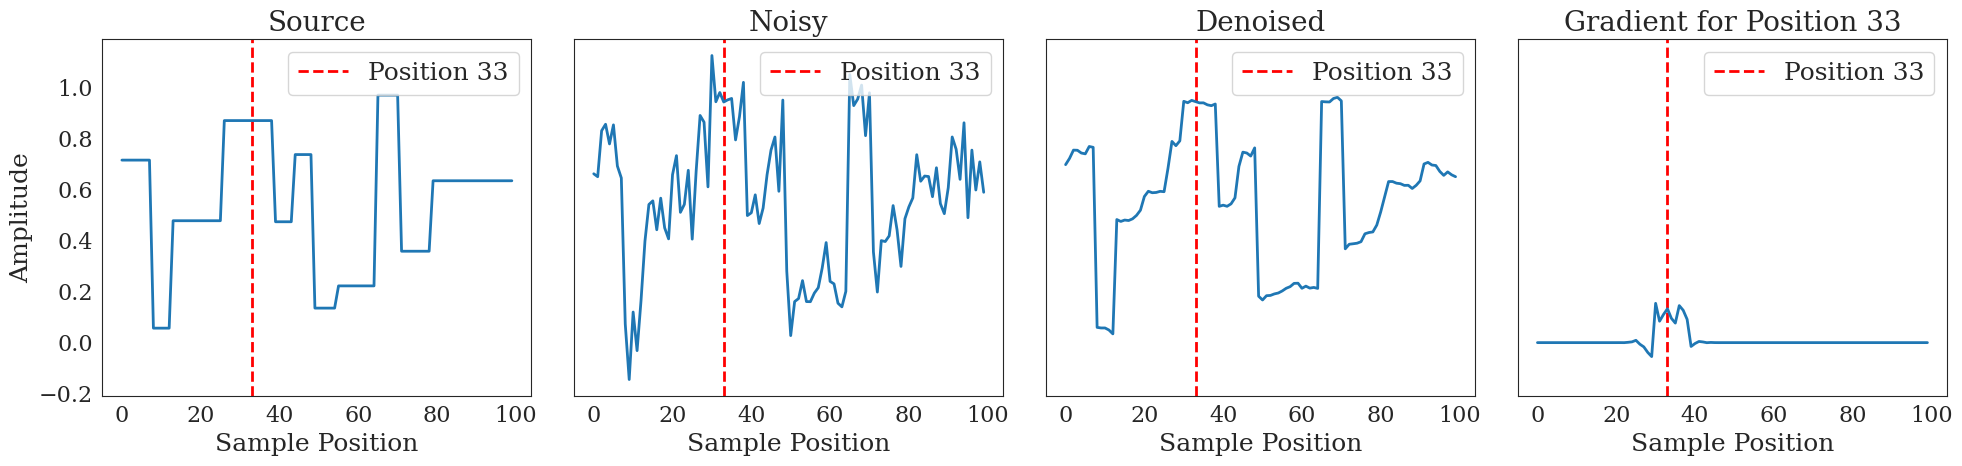

In [ ]:
import matplotlib.pyplot as plt

# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20, 5))
output_position = 33

# Common settings for all plots
for ax in axes:
    # ax.grid(True, which='both', linestyle='--', linewidth=0.7)  # Adjusted line width
    ax.grid(False)  # Grid turned off
    ax.minorticks_on()
    # ax.grid(which='minor', linestyle=':', linewidth='0.5')
    ax.axvline(x=output_position, color='red', linestyle='--', label=f'Position {output_position}')
    ax.legend(loc='upper right')
    ax.set_xlabel('Sample Position')

axes[0].set_ylabel('Amplitude')  # Only one y-label for shared y-axis

# plot source
axes[0].plot(source[0].cpu().data.numpy())
axes[0].set_title("Source")

axes[1].plot(noisy[0].cpu().data.numpy())
axes[1].set_title("Noisy")

# denoise
noisy.requires_grad = True
denoised = net_nn(noisy.unsqueeze(0))

# Plot denoised signal
axes[2].plot(denoised[0,0].cpu().data.numpy())
axes[2].set_title("Denoised")

# Compute Jacobian for the denoised tensor
jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

# Choose a specific position in the output to visualize its gradient
gradient = jacobian[output_position, :]
axes[3].plot(gradient)
axes[3].set_title(f"Gradient for Position {output_position}")

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
plt.show()
fig.savefig('comparison_plot_piecewise_const_gradient_3.pdf', bbox_inches='tight', dpi=300)

In [ ]:
# jac.shape

In [ ]:
# grad_output.shape

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3, sharex = True, sharey = False, figsize = (10, 5))

# # plot noisy
# axes[0].plot(noisy[0].cpu().data.numpy())

# # denoise
# noisy.requires_grad = True
# denoised = net_nn(noisy.unsqueeze(0))

# # plot denoised
# axes[1].plot(denoised[0,0].cpu().data.numpy())

# axes[2].plot(grad_output[0,0])



In [ ]:
# width = 100
# photo_num = 0
# for j, (ix, iy) in enumerate(pixels):

#     fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (22, 6))

#     im = axes[0].imshow(denoised[0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)


#     filt = torch.autograd.grad(denoised[0,0,iy,ix], noisy, retain_graph=True)[0][0,0].cpu().data.numpy()

#     photo_num += 1
#     print(photo_num, denoised[0, 0, iy, ix].cpu().data.numpy(),
#           np.sum(noisy.cpu().data.numpy()*filt),
#           denoised[0, 0, iy, ix].cpu().data.numpy() - np.sum(noisy.cpu().data.numpy()*filt) )

#     limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
#     limit /= 2
#     im = axes[1].imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
#     axes[2].imshow(denoised[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)
#     axes[3].imshow(filt[iy-width:iy+width, ix-width:ix+width], 'coolwarm' if True else 'gray', vmin= -limit, vmax = limit)
#     axes[4].imshow(noisy[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

#     pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
#     axes[0].add_patch(pa1)

#     pa2 = patches.Rectangle( ( width, width) ,
#                     width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
#     axes[2].add_patch(pa2)

#     plt.show()

In [ ]:
def plot_singular_vectors(u, k = 5, figsize=(20, 5), top = True ):
	## Assume vectors are along column

	fig, axes = plt.subplots(1, k, sharex=True, sharey=True, figsize=figsize);

	n = u.shape[1]

	for i in range(k):
		if top:
			axes[i].plot(u[:, i]);
			axes[i].set_title('Top : ' +str(i+1))
		else:
			axes[i].plot(u[:, n-i-1]);
			axes[i].set_title('Bottom : ' + str(i+1))

def project_to_u_s_vt(u, s, vt, x):
	out = np.dot(vt, x);
	out = np.dot(np.diag(s), out);
	out = np.dot(u, out);
	return out



In [ ]:
noisy.shape

In [ ]:
u, s, vt = np.linalg.svd(jac)

fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(20, 5) );
axes[0].plot(noisy[0].data.cpu().numpy())
axes[0].set_title('y_0')
axes[1].plot(bias)
axes[1].set_title('bias')
axes[2].plot(s)
axes[2].set_title('Singular Values')
plt.show()

print('Right Singular Vectors')
plot_singular_vectors(vt.T, k = 5, top = True)
plt.show()
